<br><font size="8">MLFTW<br><br><strong>Análise de Sentimento em Áudio - Parte 2</strong></font>

por Peterson Katagiri Zilli (<peterson.zilli@gmail.com>) - 2017/10/04<br>

Esta é a Parte final da nossa abordagem de análise de sentimentos usando Aprendizado de máquina.

Aqui abordamos a extração de características (*features*, em inglês) de arquivos de áudio no formato wav.

O vídeo deste tutorial está disponível **em breve**. Também faremos um _teaser_ ou resumo do vídeo para falar dos pontos que abordamos neste par de vídeos..

Dois pontos antes de começarmos:
* O objetivo do MLFTW é dividir e gerar conhecimento sobre Aprendizado de Máquina e assuntos afins.
* O Cientista desenvolve [3 áreas de conhecimento](https://www.oreilly.com/ideas/beyond-the-venn-diagram): Matemática/Estatistica, Hacking Skills/Programação e Conhecimento do Domínio do Problema.

# Ferramentas

<img src="assets/jupyter.jpg" alt="Jupyter Logo" style="height: 100px; display: inline; margin: 0 5px;"/>
<img src="assets/pythonlogo.png" alt="Python Logo" style="height: 100px; display: inline; margin: 0 5px;"/>
<img src="assets/numpy.jpg" alt="Numpy Logo" style="height: 120px; display: inline; margin: 0 5px;"/>
<img src="https://www.tensorflow.org/_static/images/tensorflow/logo.png" alt="Tensoflow Logo" style="height: 100px; display: inline; margin: 0 5px;"/>
<img src="assets/matplotlib.svg" alt="Matplotlib Logo" style="height: 80px; display: inline; margin: 0 5px;"/>
<img src="assets/ipython.png" alt="Ipython Logo" style="height: 100px; display: inline; margin: 0 5px;"/>
<img src="http://www.dobitaobyte.com.br/wp-content/uploads/2016/10/keras0.png" alt="Keras Logo" style="height: 100px; display: inline; margin: 0 5px;"/>


* **jupyter**: é esta aplicação web que permite criar e compartilhar documentos que contém código executável em python e outras linguagens.
* **python**: nossa linguagem de programação que cola tudo.
* **numpy**: é um pacote do Python que adiciona suporte a matrizes multidimensionais e vetores e também uma série de funções de alto nível que operam sobre estes objetos.
* **matplotlib**: é uma biblioteca para plotar gráficos
* **IPython.display.Audio**: é uma biblioteca que deixa você rodar áudio diretamente de um Notebook.
* **TensorFlow**: uma biblioteca open-source de funções para Machine Learing entre outros usos.
* **Keras**: uma biblioteca de funções mas abstratas para Machine Learning que funciona sobre TensorFlow (entre outros...). Simplifica nosso desenvolvimento do modelo!

### Você pode executar todo este tutorial a partir de servidores na Azure!

Para isso:
* Crie uma conta no [Azure Notebooks](https://notebooks.azure.com) (se você já tem uma conta da Microsoft é só logar com ela!)
* Entre na minha Library pública [https://notebooks.azure.com/**petersonzilli/libraries/mlftw**](https://notebooks.azure.com/petersonzilli/libraries/mlftw)
* Clone a Library para o seu espaço na Azure. Assim você terá o notebook *MLFTW_Extracao_de_features_de_audio.ipynb* na Sua Library

Criar e Executar Notebooks na Azure Notebooks **É gratuíto!**

## O que veremos nesta parte?

<img src="assets/InferTrain_Parte2.png" alt="Diagrama ML" style="width: 700px;"/>


1. **Qual é o nosso objetivo?** Análise de Sentimentos em Áudio!
<br><br>
2. **Qual o artigo que nos inspirou?** [Neste link](https://arxiv.org/abs/1706.02901) você encontra o artigo de Che-Wei Huang e Shrikanh S Narayanan, chamado *Characterizing Types of Convolution in Deep Convolutional Recurrent Neural Networks for Robust Speech Emotion Recognition*[1], publicado em 7 Jun 2017.
<br><br>
3. **Por que este artigo?** Há outros artigos, como [este](https://arxiv.org/pdf/1701.08071.pdf).
<br>Mas escolhemos estes porque propôe um modelo de arquitetura simples, fácil de implementar, tem um dataset livre e tem resultados muito bons!
<br><br>
4. **Qual a base de treinamento e validação?**
Utilizamos o corpus da eNTERFACE'05 emotion database [2], disponível [neste link](http://www.enterface.net/results/). São os dados apresentados no workshop da [eNTERFACE](http://www.enterface.net/) de 2005, para o paper do projeto *Multimodal Caricatural Mirror*.
<br><br>
5. **Quais são os sentimentos que tem nessa base?**
Os sentimentos são: anger, disgust, fear, happiness, sadness e surprise.
<br><br>
6. **O que desenvolvemos e como foram rodados os testes?**
Neste experimento nós:
    - Extraímos o áudio dos vídeos do dataset
    - Extraímos features *log-mels* dos áudios (conforme a [primeira parte deste tutorial](https://www.youtube.com/watch?v=49G-FE4Kpfo) - código abaixo!)
    - Construímos um classificador entre os 6 tipos de sentimentos acima
    - Testamos o classificador num setup de *Leave One Subject Out*.
<br><br>
7. **Quais os resultados que chegamos?**
    - Classificamos corretamente cerca de ~71% das vezes (um classificador aleatório uniforme em a experança de classificar 16%)

In [6]:
1/6.0

0.16666666666666666

# Extração do áudio dos arquivos de Vídeo do Dataset

Conforme [MFTW_Preprocessando_o_dataset_da_eNTERFACE'05_no_Windows.ipynb](https://notebooks.azure.com/petersonzilli/libraries/mlftw)

# Extração das *log-Mels*

<img src="assets/InputSomente.png" alt="Modelo" style="width: 900px;"/>

In [1]:
import os
import numpy as np
import scipy.io.wavfile

In [3]:
pre_emphasis = 0.95
frame_size = 0.025
frame_stride = 0.01
NFFT = 512
nfilt = 40
printevery = 100

def preprocess_dataset(in_path='data/raw2_audio_enterface', out_path='data/proc_audio_enterface'):
    # Cria uma pasta para os dados não processados
    if not os.path.exists(out_path):
        os.mkdir(out_path, 755);

    files = [x for x in os.listdir(in_path) if x.endswith('.wav')]
   
    for idx, in_filename in enumerate(files):
        audio_path = os.path.join(in_path, in_filename)
        #print(audio_path)
        if (0 == idx % printevery):
            print('\r Careregando arquivo {:s}: {:2d} of {:2d} arquivos'.format(files[idx], idx+1, len(files)))

        # lendo o arquivo
        sample_rate, signal = scipy.io.wavfile.read(audio_path)
        emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

        # calculando o tamanho e número dos frames
        signal_length = len(emphasized_signal)
        frame_length, frame_step = int(round(frame_size * sample_rate)), int(round(frame_stride * sample_rate))
        num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # sempre temos pelo menos 1 frame

        # aplicando pad para o último frame
        pad_signal_length = num_frames * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        pad_signal = np.append(emphasized_signal, z) # Pad do sinal com zeros
        
        # fatiando o sinal em frames
        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
        frames = pad_signal[indices.astype(np.int32, copy=False)]
        
        # aplicando a janela de hamming nos frames
        frames *= np.hamming(frame_length)
        #for frame in range(len(frames)):
        #    for sample in range(len(frames[frame])):
        #        frames[frame][sample] *= 0.54 - 0.46 * np.cos((2 * np.pi * sample) / (frame_length - 1))
        
        # Calculando a magnitude e potência para cada frequência presente nos frames
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
        pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

        # Agora passou de domínio do tempo para domínio da frequência
        
        # Aplicando a transformação de mel 
        low_freq_mel = 0
        high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Converte Hz para Escala Mel
        #print (low_freq_mel, high_freq_mel)

        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Igualmente espaçados na escala Mel
        hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
        bin = np.floor((NFFT + 1) * hz_points / sample_rate)

        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
        for m in range(1, nfilt + 1):
            f_m_minus = int(bin[m - 1])   # esqurda
            f_m = int(bin[m])             # centro
            f_m_plus = int(bin[m + 1])    # direita

            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Estabilidade numérica
        filter_banks = 20 * np.log10(filter_banks)  # dB

        # Normalizando os filtros
        filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
        
        out_file = os.path.join(out_path, in_filename + '.npy')
        np.save(out_file, filter_banks)

In [4]:
preprocess_dataset()

# Classificação do áudio

<img src="assets/Modelo.png" alt="Modelo" style="width: 900px;"/>

# Funções Auxiliares

In [7]:
import numpy as np
def encode_class(class_name, class_names): # cria um vetor one-hot para a classe
    try:
        idx = class_names.index(class_name)
        enc = np.zeros(len(class_names))
        enc[idx] = 1
        return enc
    except ValueError:
        return None

In [8]:
encode_class('ha', ['sa', 'di', 'fe', 'an', 'ha', 'su'])

array([ 0.,  0.,  0.,  0.,  1.,  0.])

In [9]:
import numpy as np
import os
def get_melgram_dimensions_from_file(audio_filepath):
    melgram = np.load(audio_filepath)
    return melgram.shape

In [11]:
get_melgram_dimensions_from_file('data/proc_audio_enterface/s10_an_1.wav.npy')

(598, 40)

In [10]:
from os import listdir
from os.path import isfile, join

def get_num_melgram_frames_from_dir(dirpath):
    files = [join(dirpath, f) for f in listdir(dirpath) if isfile(join(dirpath, f)) and f.endswith('.wav.npy')]
    nframes = []
    max_frames_melgram_in_dir = 0
    for f in files:
        nframes.append(max(max_frames_melgram_in_dir, np.load(f).shape[0]))    
    return nframes

In [14]:
from os import listdir
from os.path import isfile, join

def build_set(path, selected_files, nclasses, features_range, max_frames_len_out=None):   
    print('* Gerando batch')
    print('\tpath:', path)
    print('first 10 selected_files', selected_files[:10])
    print('\tnclasses', nclasses)
    print('\tfeatures_range', features_range)
    print('\tmax_frames_len_out',max_frames_len_out)
    
    mel_dims = get_melgram_dimensions_from_file(join(path, files[0]))
    print('mel_dims:', mel_dims)
    
    features_range[0], features_range[1] = max(0, features_range[0]), min(mel_dims[1], features_range[1])
    
    nfiles_out = len(selected_files)
    nfeatures_out = features_range[1] - features_range[0]
    
    
    # pre-allocate memory for speed (old method used np.concatenate, slow)
    X = np.zeros((nfiles_out, max_frames_len_out, nfeatures_out))
    Y = np.zeros((nfiles_out, nclasses))

    print(X.shape, Y.shape)
    # Construindo treinamento
    
    # Tamanho máximo de frames no input
    max_frames_len_in = 0    
        
    for i, file_name in enumerate(selected_files):
        
        numpy_features_file_path = os.path.join(path, file_name)
        max_frames_len_in = max(max_frames_len_in, len(numpy_features_file_path))
        
        fsubject = file_name.split('_')[0]
        fclass = file_name.split('_')[1]
 
        aux = np.load(numpy_features_file_path)
        X[i, 0:min(aux.shape[0], max_frames_len_out), 0:nfeatures_out] = aux[:, features_range[0]:features_range[1]] 
    
        Y[i] = encode_class(fclass, class_names)
        
    print('Max melgram frames len input', max_frames_len_out)
    print('Dataset Construído') 
    
    
    return X, Y

In [15]:
files = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('.wav.npy')]
classes = [f.split('_')[1] for f in files]
print("first 10 CLASSES:", classes[:10])
class_names = list(set(classes))
print("all CLASS NAMES:", class_names)

first 10 CLASSES: ['su', 'sa', 'sa', 'ha', 'di', 'ha', 'di', 'ha', 'an', 'sa']
all CLASS NAMES: ['sa', 'di', 'fe', 'an', 'ha', 'su']


In [16]:
x = build_set(path, files, 6, [0, 40], 1366)

* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1257, 1366, 40) (1257, 6)
Max melgram frames len input 1366
Dataset Construído


In [17]:
x[0].shape, x[1].shape

((1257, 1366, 40), (1257, 6))

In [18]:
del x

# Qual é o tamanho dos meus Áudios?

In [8]:
path = 'data/proc_audio_enterface'

In [9]:
!sudo pip3 install matplotlib 

The directory '/home/peterson/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/peterson/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_histogram(x, num_bins=50, xlabel='', ylabel='', title=''):
    fig, ax = plt.subplots()

    # cria o histograma
    n, bins, patches = ax.hist(x, num_bins, normed=1)

    # coloca os títulos nos eixos e no plot
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # previne o clipping do layout
    fig.tight_layout()
    plt.show()

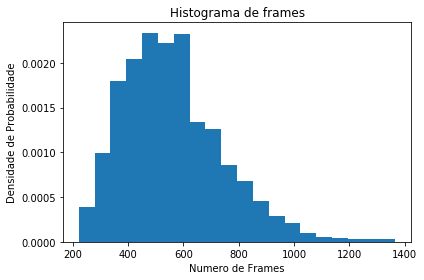

In [12]:
melgrams_sizes = get_num_melgram_frames_from_dir(path)
plot_histogram(melgrams_sizes, 20, xlabel = 'Numero de Frames', ylabel = 'Densidade de Probabilidade', title='Histograma de frames')

In [13]:
max(melgrams_sizes)

1366

# Construindo o Modelo

<img src="assets/ModeloSomente.png" alt="Modelo" style="width: 900px;"/>

* A saída é uma Softmax sobre uma rede neural de tamanho 6 (uma para cada sentimento), totalmente conectada a mais 3 camadas de redes neurais, de tamanho 32, 32 e 128.
    - SoftMax:
        - https://en.wikipedia.org/wiki/Softmax_function
    - Redes Neurais:
        - um neurônio: http://www.psiqweb.med.br/site/?area=NO/LerNoticia&idNoticia=290
        - como implementar com python e numpy: http://neuralnetworksanddeeplearning.com/chap1.html
* Uma Bi-LSTM é alimentada com as features do áudio
    - RNN: https://medium.com/@camrongodbout/recurrent-neural-networks-for-beginners-7aca4e933b82
    - LSTM por Karpathy: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [23]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.recurrent import LSTM #(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)
from keras.layers.normalization import BatchNormalization #(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
from keras.layers.advanced_activations import ELU
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.engine.topology import Layer, InputSpec
from keras import backend as T

Using TensorFlow backend.


In [24]:
class TemporalMeanPooling(Layer):
    """
    - Conforme https://github.com/fchollet/keras/issues/2151
    
    This is a custom Keras layer. This pooling layer accepts the temporal
    sequence output by a recurrent layer and performs temporal pooling,
    looking at only the non-masked portion of the sequence. The pooling
    layer converts the entire variable-length hidden vector sequence
    into a single hidden vector, and then feeds its output to the Dense
    layer.

    input shape: (nb_samples, nb_timesteps, nb_features)
    output shape: (nb_samples, nb_features)
    """
    def __init__(self, **kwargs):
        super(TemporalMeanPooling, self).__init__(**kwargs)
        self.supports_masking = True
        self.input_spec = [InputSpec(ndim=3)]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])    
    
    def call(self, x, mask=None): #mask: (nb_samples, nb_timesteps)
        if mask is None:
            mask = T.mean(T.ones_like(x), axis=-1)
        ssum = T.sum(x,axis=-2) #(nb_samples, np_features)
        mask = T.cast(mask,T.floatx())
        rcnt = T.sum(mask,axis=-1,keepdims=True) #(nb_samples)
        return ssum/rcnt

    def compute_mask(self, input, mask):
        return None

In [25]:
def build_model(X, Y, bn=False):
    
    input_shape = X.shape[1:]
    nb_classes = Y.shape[1]
    
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    if bn:
        model.add(BatchNormalization())
    model.add(TemporalMeanPooling())
    model.add(Dense(128))
    model.add(Dense(32))
    model.add(Dense(32))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    return model

# Rodando os Testes

first 10 FILES: ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy']
first 10 SUBJECTS: ['s30', 's39', 's30', 's29', 's32', 's24', 's14', 's36', 's38', 's13']
all SUBJECTS: ['s1', 's10', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's3', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's4', 's40', 's41', 's42', 's43', 's44', 's5', 's7', 's8', 's9']
first 10 CLASSES: ['su', 'sa', 'sa', 'ha', 'di', 'ha', 'di', 'ha', 'an', 'sa']
all CLASS NAMES: ['sa', 'di', 'fe', 'an', 'ha', 'su']
number of subjects: 42
number of classes: 6
features range [0, 40]
chosen_subject: 0 s1
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.w

1227/1227 [==============================] - 18s - loss: 0.8061 - acc: 0.7270 - val_loss: 0.7498 - val_acc: 0.8000
Epoch 16/100
1227/1227 [==============================] - 19s - loss: 0.7207 - acc: 0.7742 - val_loss: 0.7117 - val_acc: 0.7333
Epoch 17/100
1227/1227 [==============================] - 18s - loss: 0.6504 - acc: 0.7995 - val_loss: 0.6074 - val_acc: 0.9000
Epoch 18/100
1227/1227 [==============================] - 18s - loss: 0.6012 - acc: 0.8240 - val_loss: 0.6756 - val_acc: 0.8333
Epoch 19/100
1227/1227 [==============================] - 18s - loss: 0.5298 - acc: 0.8525 - val_loss: 0.5800 - val_acc: 0.8667
Epoch 20/100
1227/1227 [==============================] - 18s - loss: 0.4641 - acc: 0.8802 - val_loss: 0.5030 - val_acc: 0.8333
Epoch 21/100
1227/1227 [==============================] - 18s - loss: 0.3859 - acc: 0.9055 - val_loss: 0.4549 - val_acc: 0.8667
Epoch 22/100
1227/1227 [==============================] - 18s - loss: 0.3408 - acc: 0.9136 - val_loss: 0.4101 - val_a

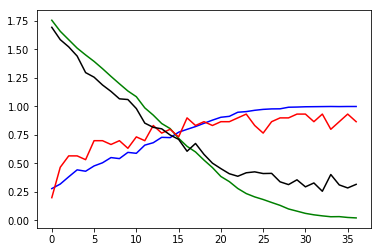

features range [0, 40]
chosen_subject: 1 s10
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1227, 1366, 40) (1227, 6)
Max melgram frames len input 1366
Dataset Construído
criando dataset de teste
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s10_ha_1.wav.npy', 's10_su_4.wav.npy', 's10_fe_5.wav.npy', 's10_sa_1.wav.npy', 's10_sa_4.wav.npy', 's10_di_4.wav.npy', 's10_an_5.wav.npy', 's10_ha_5.wav.npy', 's10_di_2.wav.npy', 's10_an_2.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(30, 1366, 40) (30, 6)
Max melgram frames len input 1366
Dataset Construído
X_train.shape: (1227, 1366, 40), Y_tra

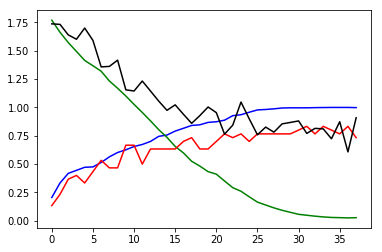

features range [0, 40]
chosen_subject: 2 s12
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1227, 1366, 40) (1227, 6)
Max melgram frames len input 1366
Dataset Construído
criando dataset de teste
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s12_ha_2.wav.npy', 's12_di_2.wav.npy', 's12_sa_1.wav.npy', 's12_an_1.wav.npy', 's12_an_2.wav.npy', 's12_sa_2.wav.npy', 's12_ha_1.wav.npy', 's12_fe_2.wav.npy', 's12_su_2.wav.npy', 's12_fe_1.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(30, 1366, 40) (30, 6)
Max melgram frames len input 1366
Dataset Construído
X_train.shape: (1227, 1366, 40), Y_tra

1227/1227 [==============================] - 19s - loss: 0.6028 - acc: 0.8036 - val_loss: 0.9253 - val_acc: 0.7333
Epoch 19/100
1227/1227 [==============================] - 19s - loss: 0.5356 - acc: 0.8289 - val_loss: 0.8028 - val_acc: 0.6333
Epoch 20/100
1227/1227 [==============================] - 19s - loss: 0.4746 - acc: 0.8533 - val_loss: 0.8156 - val_acc: 0.6667
Epoch 21/100
1227/1227 [==============================] - 19s - loss: 0.4064 - acc: 0.9022 - val_loss: 0.9997 - val_acc: 0.5667
Epoch 22/100
1227/1227 [==============================] - 19s - loss: 0.3724 - acc: 0.9030 - val_loss: 0.8442 - val_acc: 0.6000
Epoch 23/100
1227/1227 [==============================] - 19s - loss: 0.3240 - acc: 0.9242 - val_loss: 0.8860 - val_acc: 0.6333
Epoch 24/100
1227/1227 [==============================] - 19s - loss: 0.2761 - acc: 0.9405 - val_loss: 0.8572 - val_acc: 0.6333
Epoch 25/100
1227/1227 [==============================] - 19s - loss: 0.2396 - acc: 0.9487 - val_loss: 0.9751 - val_a

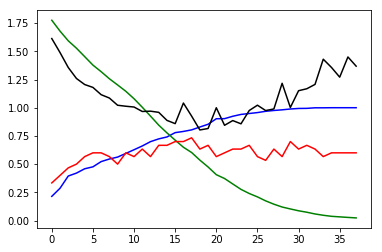

features range [0, 40]
chosen_subject: 3 s13
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's25_ha_5.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1227, 1366, 40) (1227, 6)
Max melgram frames len input 1366
Dataset Construído
criando dataset de teste
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s13_sa_3.wav.npy', 's13_ha_5.wav.npy', 's13_di_5.wav.npy', 's13_ha_1.wav.npy', 's13_sa_2.wav.npy', 's13_fe_5.wav.npy', 's13_di_3.wav.npy', 's13_su_2.wav.npy', 's13_ha_2.wav.npy', 's13_ha_4.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(30, 1366, 40) (30, 6)
Max melgram frames len input 1366
Dataset Construído
X_train.shape: (1227, 1366, 40), Y_tra

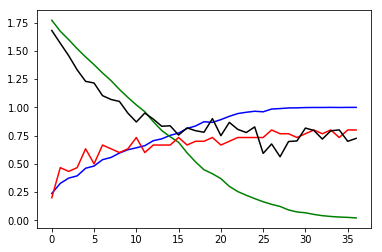

features range [0, 40]
chosen_subject: 4 s14
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy', 's25_ha_5.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1227, 1366, 40) (1227, 6)
Max melgram frames len input 1366
Dataset Construído
criando dataset de teste
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s14_di_2.wav.npy', 's14_di_5.wav.npy', 's14_ha_4.wav.npy', 's14_fe_3.wav.npy', 's14_ha_3.wav.npy', 's14_di_4.wav.npy', 's14_ha_5.wav.npy', 's14_ha_2.wav.npy', 's14_sa_4.wav.npy', 's14_su_3.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(30, 1366, 40) (30, 6)
Max melgram frames len input 1366
Dataset Construído
X_train.shape: (1227, 1366, 40), Y_tra

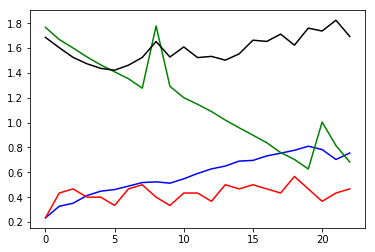

features range [0, 40]
chosen_subject: 5 s15
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1227, 1366, 40) (1227, 6)
Max melgram frames len input 1366
Dataset Construído
criando dataset de teste
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s15_su_1.wav.npy', 's15_su_5.wav.npy', 's15_fe_4.wav.npy', 's15_an_2.wav.npy', 's15_an_4.wav.npy', 's15_di_5.wav.npy', 's15_sa_1.wav.npy', 's15_sa_2.wav.npy', 's15_sa_3.wav.npy', 's15_di_2.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(30, 1366, 40) (30, 6)
Max melgram frames len input 1366
Dataset Construído
X_train.shape: (1227, 1366, 40), Y_tra

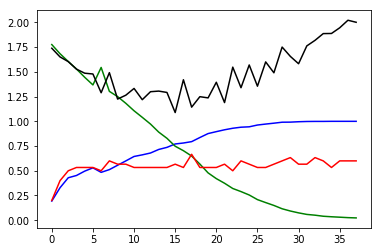

features range [0, 40]
chosen_subject: 6 s16
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1227, 1366, 40) (1227, 6)
Max melgram frames len input 1366
Dataset Construído
criando dataset de teste
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s16_ha_5.wav.npy', 's16_sa_5.wav.npy', 's16_sa_2.wav.npy', 's16_di_5.wav.npy', 's16_an_3.wav.npy', 's16_di_1.wav.npy', 's16_sa_4.wav.npy', 's16_di_4.wav.npy', 's16_ha_2.wav.npy', 's16_fe_4.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(30, 1366, 40) (30, 6)
Max melgram frames len input 1366
Dataset Construído
X_train.shape: (1227, 1366, 40), Y_tra

1227/1227 [==============================] - 19s - loss: 0.3742 - acc: 0.8973 - val_loss: 1.8138 - val_acc: 0.5000
Epoch 22/100
1227/1227 [==============================] - 18s - loss: 0.3451 - acc: 0.9022 - val_loss: 2.1844 - val_acc: 0.3667
Epoch 23/100
1227/1227 [==============================] - 19s - loss: 0.3090 - acc: 0.9169 - val_loss: 2.1810 - val_acc: 0.4333
Epoch 24/100
1227/1227 [==============================] - 18s - loss: 0.2470 - acc: 0.9470 - val_loss: 2.0334 - val_acc: 0.4333
Epoch 25/100
1227/1227 [==============================] - 19s - loss: 0.2125 - acc: 0.9584 - val_loss: 1.9141 - val_acc: 0.5333
Epoch 26/100
1227/1227 [==============================] - 19s - loss: 0.1748 - acc: 0.9764 - val_loss: 1.9262 - val_acc: 0.5000
Epoch 27/100
1227/1227 [==============================] - 18s - loss: 0.1391 - acc: 0.9821 - val_loss: 1.8073 - val_acc: 0.5333
Epoch 28/100
1227/1227 [==============================] - 19s - loss: 0.1136 - acc: 0.9878 - val_loss: 2.0091 - val_a

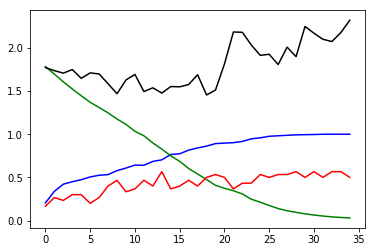

features range [0, 40]
chosen_subject: 7 s17
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1227, 1366, 40) (1227, 6)
Max melgram frames len input 1366
Dataset Construído
criando dataset de teste
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s17_an_2.wav.npy', 's17_di_4.wav.npy', 's17_su_1.wav.npy', 's17_ha_4.wav.npy', 's17_fe_5.wav.npy', 's17_fe_4.wav.npy', 's17_sa_4.wav.npy', 's17_sa_3.wav.npy', 's17_ha_3.wav.npy', 's17_di_5.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(30, 1366, 40) (30, 6)
Max melgram frames len input 1366
Dataset Construído
X_train.shape: (1227, 1366, 40), Y_tra

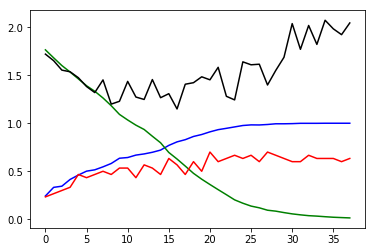

features range [0, 40]
chosen_subject: 8 s18
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1227, 1366, 40) (1227, 6)
Max melgram frames len input 1366
Dataset Construído
criando dataset de teste
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s18_sa_4.wav.npy', 's18_ha_4.wav.npy', 's18_ha_5.wav.npy', 's18_di_2.wav.npy', 's18_di_4.wav.npy', 's18_fe_5.wav.npy', 's18_ha_3.wav.npy', 's18_su_3.wav.npy', 's18_an_1.wav.npy', 's18_sa_1.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(30, 1366, 40) (30, 6)
Max melgram frames len input 1366
Dataset Construído
X_train.shape: (1227, 1366, 40), Y_tra

1227/1227 [==============================] - 19s - loss: 0.0384 - acc: 0.9992 - val_loss: 1.0004 - val_acc: 0.6000
Epoch 43/100
1227/1227 [==============================] - 19s - loss: 0.0325 - acc: 1.0000 - val_loss: 1.1444 - val_acc: 0.5667
Epoch 44/100
1227/1227 [==============================] - 19s - loss: 0.0278 - acc: 1.0000 - val_loss: 1.1708 - val_acc: 0.6000
Epoch 45/100
1227/1227 [==============================] - 19s - loss: 0.0238 - acc: 1.0000 - val_loss: 1.0911 - val_acc: 0.6000
Epoch 46/100
1227/1227 [==============================] - 19s - loss: 0.0207 - acc: 1.0000 - val_loss: 1.0763 - val_acc: 0.6000
Epoch 00045: early stopping
BestValAcc 0.700000047684
Test score: 1.07632684708
Test accuracy: 0.600000083447
Best Vall Acc 0.700000047684
['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 13]


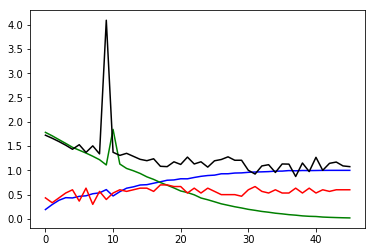

features range [0, 40]
chosen_subject: 14 s23
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1230, 1366, 40) (1230, 6)
Max melgram frames len input 1366
Dataset Construído
criando dataset de teste
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s23_su_4.wav.npy', 's23_sa_3.wav.npy', 's23_fe_2.wav.npy', 's23_sa_5.wav.npy', 's23_su_5.wav.npy', 's23_fe_4.wav.npy', 's23_an_1.wav.npy', 's23_sa_4.wav.npy', 's23_fe_3.wav.npy', 's23_an_5.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(27, 1366, 40) (27, 6)
Max melgram frames len input 1366
Dataset Construído
X_train.shape: (1230, 1366, 40), Y_tr

1230/1230 [==============================] - 19s - loss: 0.5725 - acc: 0.8203 - val_loss: 1.0348 - val_acc: 0.7037
Epoch 21/100
1230/1230 [==============================] - 19s - loss: 0.5330 - acc: 0.8407 - val_loss: 0.8839 - val_acc: 0.7778
Epoch 22/100
1230/1230 [==============================] - 19s - loss: 0.4540 - acc: 0.8756 - val_loss: 0.7568 - val_acc: 0.7778
Epoch 23/100
1230/1230 [==============================] - 19s - loss: 0.4218 - acc: 0.8797 - val_loss: 0.8329 - val_acc: 0.7778
Epoch 24/100
1230/1230 [==============================] - 18s - loss: 0.3506 - acc: 0.9171 - val_loss: 0.9006 - val_acc: 0.7778
Epoch 25/100
1230/1230 [==============================] - 19s - loss: 0.1303 - acc: 0.9878 - val_loss: 0.7888 - val_acc: 0.7407
Epoch 31/100
1230/1230 [==============================] - 19s - loss: 0.1139 - acc: 0.9919 - val_loss: 0.8015 - val_acc: 0.7407
Epoch 32/100
1230/1230 [==============================] - 19s - loss: 0.1031 - acc: 0.9902 - val_loss: 0.7794 - val_a

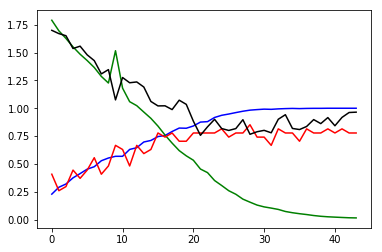

features range [0, 40]
chosen_subject: 15 s24
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy', 's25_ha_5.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1227, 1366, 40) (1227, 6)
Max melgram frames len input 1366
Dataset Construído
criando dataset de teste
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s24_ha_2.wav.npy', 's24_di_1.wav.npy', 's24_an_1.wav.npy', 's24_ha_4.wav.npy', 's24_di_3.wav.npy', 's24_su_2.wav.npy', 's24_di_5.wav.npy', 's24_fe_3.wav.npy', 's24_su_4.wav.npy', 's24_sa_4.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(30, 1366, 40) (30, 6)
Max melgram frames len input 1366
Dataset Construído
X_train.shape: (1227, 1366, 40), Y_tr

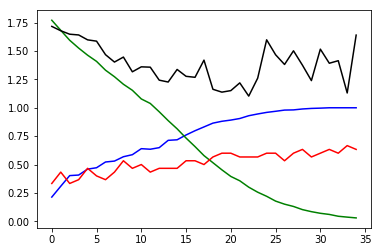

features range [0, 40]
chosen_subject: 16 s25
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1227, 1366, 40) (1227, 6)
Max melgram frames len input 1366
Dataset Construído
criando dataset de teste
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s25_ha_5.wav.npy', 's25_su_4.wav.npy', 's25_an_4.wav.npy', 's25_fe_5.wav.npy', 's25_su_1.wav.npy', 's25_fe_4.wav.npy', 's25_di_3.wav.npy', 's25_su_3.wav.npy', 's25_di_2.wav.npy', 's25_fe_1.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(30, 1366, 40) (30, 6)
Max melgram frames len input 1366
Dataset Construído
X_train.shape: (1227, 1366, 40), Y_tr

1227/1227 [==============================] - 20s - loss: 0.4332 - acc: 0.8835 - val_loss: 1.2118 - val_acc: 0.5000
Epoch 21/100
1227/1227 [==============================] - 19s - loss: 0.3748 - acc: 0.9095 - val_loss: 1.3465 - val_acc: 0.3667
Epoch 22/100
1227/1227 [==============================] - 19s - loss: 0.3193 - acc: 0.9356 - val_loss: 1.3151 - val_acc: 0.3667
Epoch 23/100
1227/1227 [==============================] - 19s - loss: 0.2671 - acc: 0.9405 - val_loss: 1.2590 - val_acc: 0.4333
Epoch 24/100
1227/1227 [==============================] - 19s - loss: 0.2250 - acc: 0.9690 - val_loss: 1.2237 - val_acc: 0.4333
Epoch 25/100
1227/1227 [==============================] - 19s - loss: 0.1932 - acc: 0.9707 - val_loss: 1.2543 - val_acc: 0.4333
Epoch 26/100
1227/1227 [==============================] - 20s - loss: 0.1534 - acc: 0.9829 - val_loss: 1.3782 - val_acc: 0.3667
Epoch 27/100
1227/1227 [==============================] - 19s - loss: 0.1390 - acc: 0.9804 - val_loss: 1.4301 - val_a

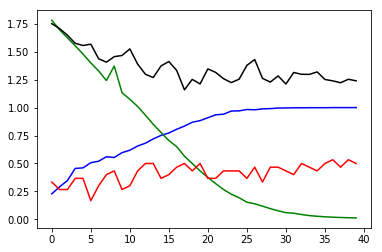

features range [0, 40]
chosen_subject: 17 s26
criando dataset de treino
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s30_su_3.wav.npy', 's39_sa_5.wav.npy', 's30_sa_3.wav.npy', 's29_ha_4.wav.npy', 's32_di_5.wav.npy', 's24_ha_2.wav.npy', 's14_di_2.wav.npy', 's36_ha_5.wav.npy', 's38_an_5.wav.npy', 's13_sa_3.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(1227, 1366, 40) (1227, 6)
Max melgram frames len input 1366
Dataset Construído
criando dataset de teste
* Gerando batch
	path: data/proc_audio_enterface
first 10 selected_files ['s26_sa_1.wav.npy', 's26_ha_3.wav.npy', 's26_di_1.wav.npy', 's26_di_5.wav.npy', 's26_an_3.wav.npy', 's26_fe_2.wav.npy', 's26_fe_5.wav.npy', 's26_fe_1.wav.npy', 's26_ha_5.wav.npy', 's26_an_4.wav.npy']
	nclasses 6
	features_range [0, 40]
	max_frames_len_out 1366
mel_dims: (430, 40)
(30, 1366, 40) (30, 6)
Max melgram frames len input 1366
Dataset Construído
X_train.shape: (1227, 1366, 40), Y_tr

In [ ]:
import gc
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os

nb_epoch = 100
verbose = 1
max_frames_len = None


resultados = []
setups = []
melhor_val_acc = {}

if __name__ == '__main__':

    
    files = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('.wav.npy')]
    print("first 10 FILES:", files[:10])

    subjects = [f.split('_')[0] for f in files]
    print("first 10 SUBJECTS:", subjects[:10])
    subject_names = sorted(list(set(subjects)))
    print("all SUBJECTS:", subject_names)

    classes = [f.split('_')[1] for f in files]
    print("first 10 CLASSES:", classes[:10])
    class_names = list(set(classes))
    print("all CLASS NAMES:", class_names)

    nsubjects = len(subject_names)
    nclasses = len(class_names)

    print('number of subjects:', nsubjects)
    print('number of classes:', nclasses)


    lindex_subject_out = range(len(subjects))
    llr = [1e-03, 1e-04]
    lbatch_size = [256, 128]
    lfeatures_range = [ [0,40], [0, 30] ]
    lpath = ['data/proc_audio_enterface']
    
    for path in lpath:
        for lr in llr:
            for batch_size in lbatch_size:
                for features_range in lfeatures_range:
                    for build_batch_func in [build_set]:
                        for bn_option in [False, True]:
                            for index_subject_out in range(len(subject_names)): #[0, 1, ... 41]

                                setup = [path, lr, batch_size, features_range, str(build_batch_func).split(' ')[1], bn_option, index_subject_out]
                                setups.append(setup)

                                print("features range", features_range)

                                chosen_subject = subject_names[index_subject_out]
                                print("chosen_subject:", index_subject_out, chosen_subject)

                                files_train = [f for f in files if f.split('_')[0] != chosen_subject]
                                files_test = [f for f in files if f.split('_')[0] == chosen_subject]


                                if 'X_Train' in locals():
                                    del X_train, Y_train, X_test, Y_test
                                if 'model' in locals():
                                    K.clear_session()
                                    del model, optimizer
                                gc.collect()


                                # get the data
                                print('criando dataset de treino')
                                X_train, Y_train = build_batch_func(path, files_train, nclasses, features_range, 1366)   
                                print('criando dataset de teste')
                                X_test, Y_test = build_batch_func(path, files_test, nclasses, features_range, 1366)

                                print('X_train.shape: {}, Y_train.shape: {}'.format(X_train.shape, Y_train.shape))
                                print('X_test.shape: {}, Y_test.shape: {}'.format(X_test.shape, Y_test.shape))

                                # make the model
                                model = build_model(X_train, Y_train, bn=bn_option)

                                checkpoint_filepath = 'weights_{}_{}_{}_{}_{}_{}_new.hdf5'.format(subject_names[index_subject_out], lr, batch_size, features_range, str(build_batch_func).split(' ')[1], bn_option)

                                # load weights
                                #model.load_weights(checkpoint_filepath)

                                optimizer = Adam(lr=lr)
                                model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

                                model.summary()

                                checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_best_only=True)
                                earlystopping = EarlyStopping(monitor='acc', min_delta=0, patience=2, verbose=1, mode='auto')
                                #bestvalacc = BestValAcc()

                                results = model.fit(X_train,
                                                    Y_train,
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    epochs=nb_epoch,
                                                    verbose=verbose,
                                                    validation_data=(X_test, Y_test),
                                                    callbacks=[checkpointer, earlystopping])#, bestvalacc])

                                resultados.append(results)
                                melhor_val_acc['{}'.format(subject_names[index_subject_out])] = bestvalacc

                                score = model.evaluate(X_test, Y_test, verbose=0)
                                print('Test score:', score[0])
                                print('Test accuracy:', score[1])
                                #print('Best Vall Acc', bestvalacc.val_acc)
                                print (setup)
                                # plot the training accuracies
                                plt.plot(results.history['acc'], 'b')
                                plt.plot(results.history['loss'], 'g')
                                plt.plot(results.history['val_acc'], 'r')
                                plt.plot(results.history['val_loss'], 'k')
                                plt.show()

    print('=============================================')
    print('Todos os gráficos:')
    print('=============================================')
    for index_ in range(len(resultados)):
        setup = setups[index_]
        results = resultados[index_]
        print (setup)
        # plot the training accuracies
        plt.plot(results.history['acc'], 'b')
        plt.plot(results.history['loss'], 'g')
        plt.plot(results.history['val_acc'], 'r')
        plt.plot(results.history['val_loss'], 'k')
        plt.show()

# Resultados 

In [31]:
print(resultados)

[<keras.callbacks.History object at 0x7f2e7926a860>, <keras.callbacks.History object at 0x7f2e267860f0>, <keras.callbacks.History object at 0x7f2e25084eb8>, <keras.callbacks.History object at 0x7f2e23948908>, <keras.callbacks.History object at 0x7f2e221a0a58>, <keras.callbacks.History object at 0x7f2e20a20cc0>, <keras.callbacks.History object at 0x7f2e1f2bb940>, <keras.callbacks.History object at 0x7f2e1d902cf8>, <keras.callbacks.History object at 0x7f2e1c1deba8>, <keras.callbacks.History object at 0x7f2e18a2c9b0>, <keras.callbacks.History object at 0x7f2e17342860>, <keras.callbacks.History object at 0x7f2e15c1c898>, <keras.callbacks.History object at 0x7f2e1446fe10>, <keras.callbacks.History object at 0x7f2e12d1d6d8>, <keras.callbacks.History object at 0x7f2e106449e8>, <keras.callbacks.History object at 0x7f2e0fe87b70>, <keras.callbacks.History object at 0x7f2e0e79bb38>, <keras.callbacks.History object at 0x7f2e0cf63fd0>, <keras.callbacks.History object at 0x7f2e0b823a20>, <keras.call

In [32]:
print(setups)

[['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 0], ['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 1], ['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 2], ['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 3], ['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 4], ['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 5], ['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 6], ['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 7], ['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 8], ['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 9], ['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 10], ['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 11], ['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 

Todos os gráficos:
['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 0]


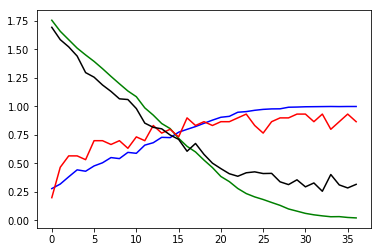

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 1]


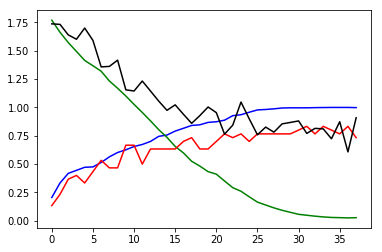

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 2]


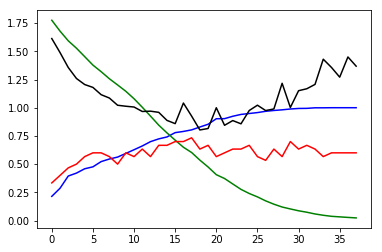

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 3]


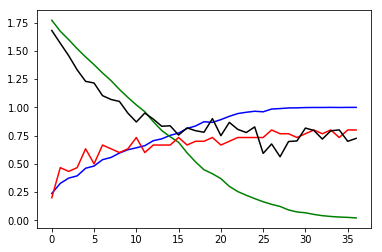

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 4]


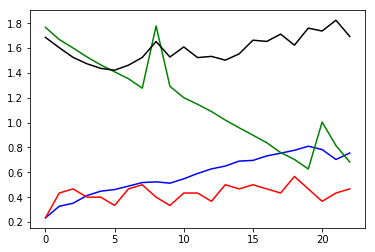

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 5]


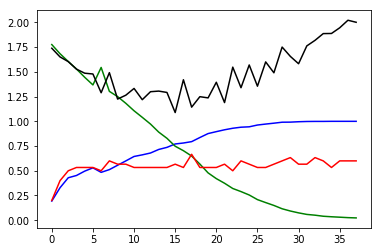

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 6]


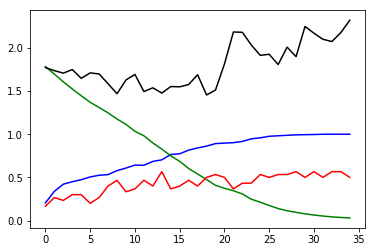

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 7]


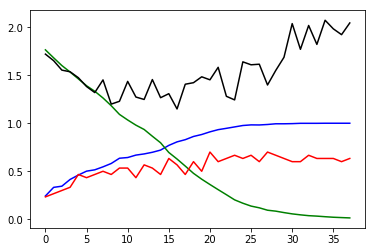

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 8]


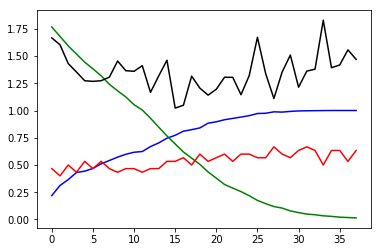

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 9]


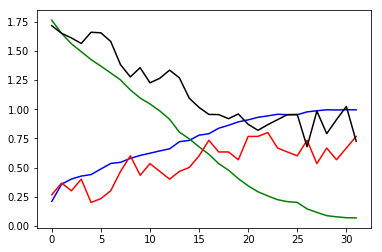

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 10]


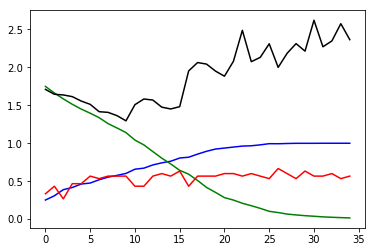

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 11]


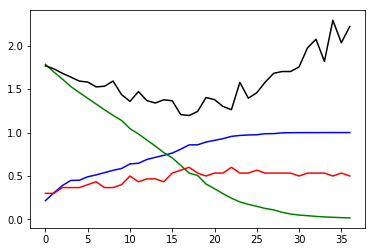

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 12]


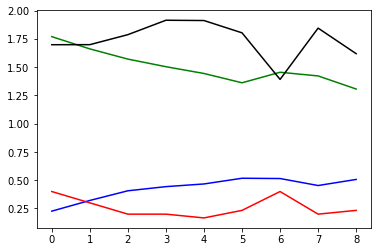

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 13]


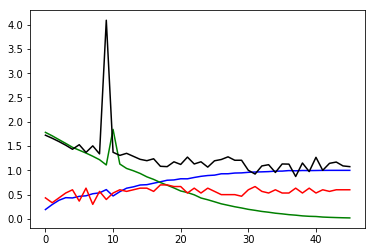

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 14]


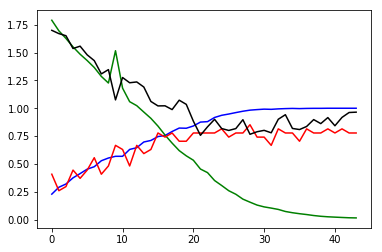

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 15]


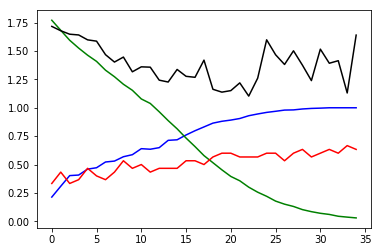

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 16]


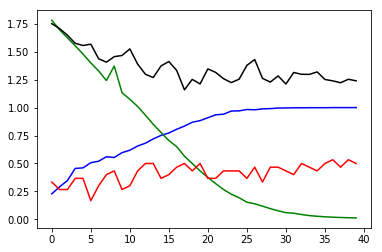

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 17]


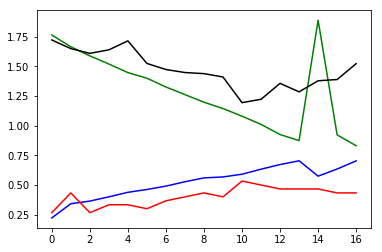

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 18]


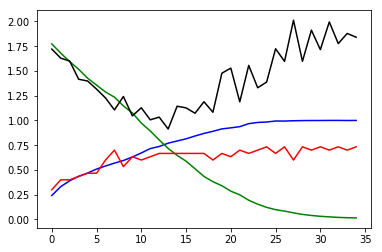

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 19]


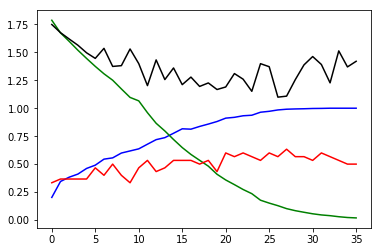

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 20]


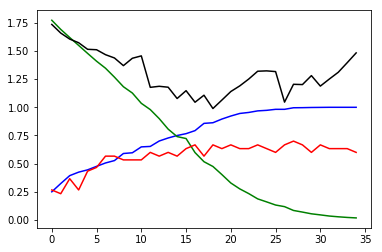

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 21]


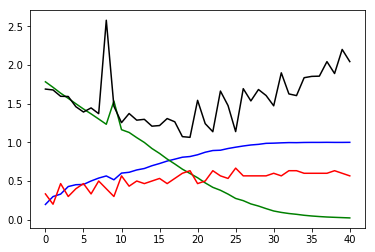

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 22]


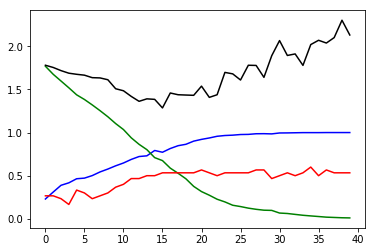

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 23]


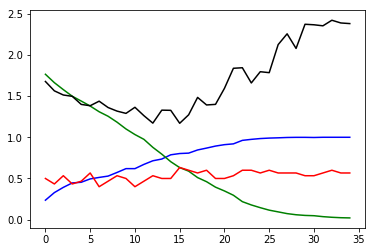

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 24]


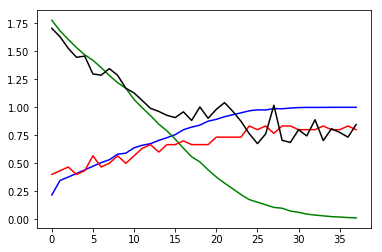

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 25]


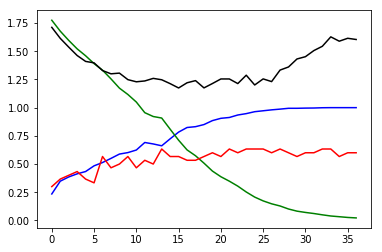

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 26]


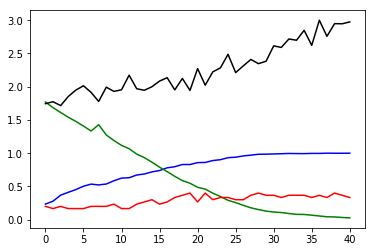

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 27]


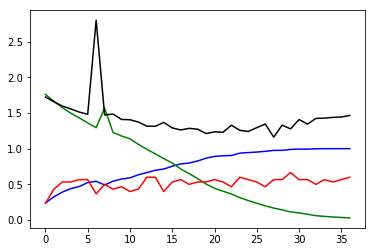

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 28]


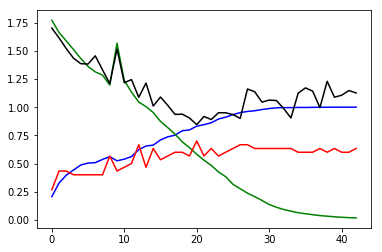

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 29]


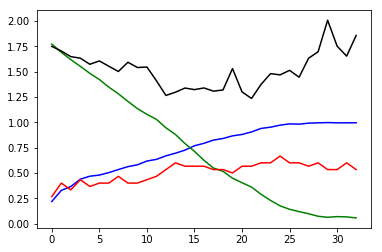

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 30]


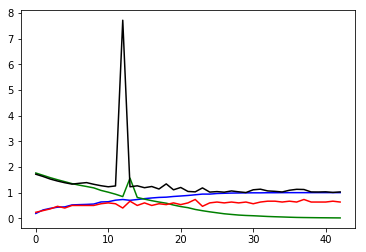

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 31]


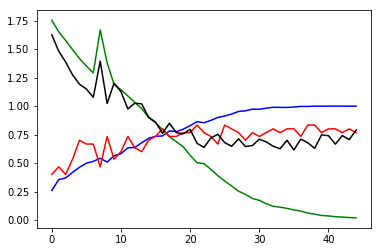

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 32]


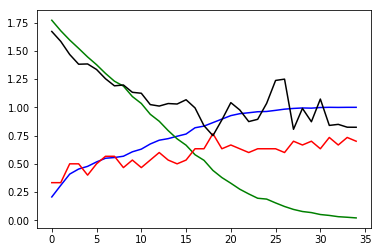

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 33]


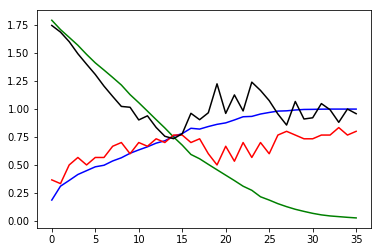

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 34]


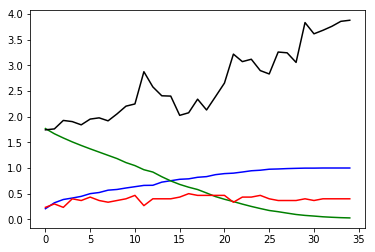

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 35]


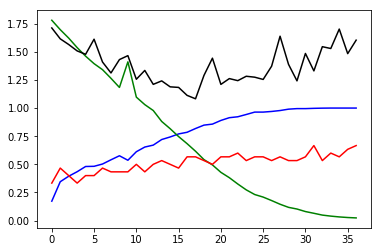

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 36]


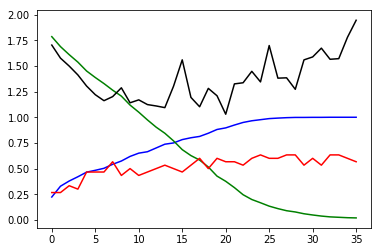

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 37]


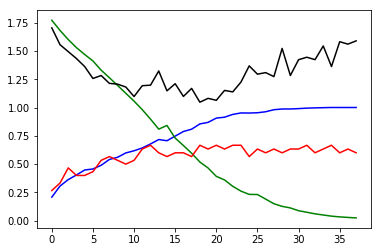

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 38]


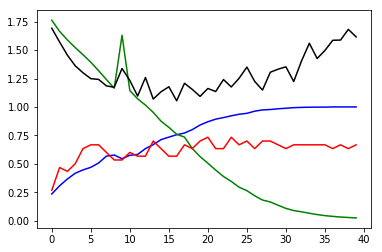

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 39]


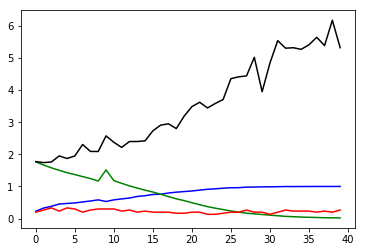

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 40]


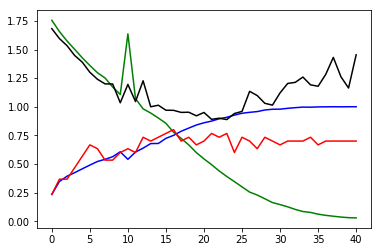

['data/proc_audio_enterface', 0.001, 256, [0, 40], 'build_batch', False, 41]


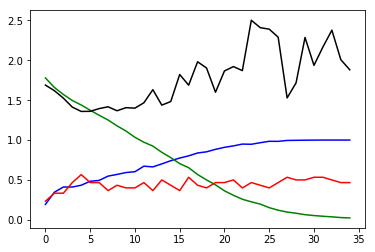

In [51]:
print('=============================================')
print('Todos os gráficos:')
print('=============================================')
for index_ in range(len(resultados)):
    setup = setups[index_]
    results = resultados[index_]
    print (setup)
    # plot the training accuracies
    plt.plot(results.history['acc'], 'b')
    plt.plot(results.history['loss'], 'g')
    plt.plot(results.history['val_acc'], 'r')
    plt.plot(results.history['val_loss'], 'k')
    plt.show()

for i in range(5):
    print('=============================================')

with open('workfile', 'w') as f:
    f.write('='*80 + '\n')
    f.write('subject_index, subject_name\n')
    for index_ in range(len(subject_names)):
        f.write('{},{}\n'.format(index_, subject_names[index_]))
    f.write('='*80 + '\n')
    
    f.write('setup,lr,batch_size,features_range_start,features_range_end,trainset_method,bach_normalization,subject\n')
    for index_ in range(len(setups)):
        setup = setups[index_]
        f.write('setup,{},{},{},{},{},{},{}\n'.format(setup[1],setup[2],setup[3][0],setup[3][1],setup[4],setup[5],setup[6]))
    f.write('='*80 + '\n')
    
    f.write('results,acc,loss,val_acc,val_loss\n')
    for index_ in range(len(resultados)):        
        results = resultados[index_]
        f.write('results,{},{},{},{}\n'.format(results.history['acc'], results.history['loss'], results.history['val_acc'], results.history['val_loss']))
        
        
with open('workpythonfile.py', 'w') as f:
    f.write('subject_names = []\n')
    for index_ in range(len(subject_names)):
        f.write('subject_names.append(\'{}\')\n'.format(subject_names[index_]))
    
    f.write('\n#setup = [lr,batch_size,features_range_start,features_range_end,trainset_method,bach_normalization,subject]\n')
    f.write('setups = []\n')
    for index_ in range(len(setups)):
        setup = setups[index_]
        f.write('setups.append([{},{},{},{},\'{}\',{},{}])\n'.format(setup[1],setup[2],setup[3][0],setup[3][1],setup[4],setup[5],setup[6]))

    
    f.write('#results = [acc,loss,val_acc,val_loss]\n')
    f.write('results = []\n')
    for index_ in range(len(resultados)):        
        results = resultados[index_]
        f.write('results.append([{},{},{},{}])\n'.format(results.history['acc'], results.history['loss'], results.history['val_acc'], results.history['val_loss']))


In [47]:
!head workpythonfile.py

subject_names = []
subject_names.append('s1')
subject_names.append('s10')
subject_names.append('s12')
subject_names.append('s13')
subject_names.append('s14')
subject_names.append('s15')
subject_names.append('s16')
subject_names.append('s17')
subject_names.append('s18')


In [52]:
!cat workpythonfile.py

subject_names = []
subject_names.append('s1')
subject_names.append('s10')
subject_names.append('s12')
subject_names.append('s13')
subject_names.append('s14')
subject_names.append('s15')
subject_names.append('s16')
subject_names.append('s17')
subject_names.append('s18')
subject_names.append('s19')
subject_names.append('s2')
subject_names.append('s20')
subject_names.append('s21')
subject_names.append('s22')
subject_names.append('s23')
subject_names.append('s24')
subject_names.append('s25')
subject_names.append('s26')
subject_names.append('s27')
subject_names.append('s28')
subject_names.append('s29')
subject_names.append('s3')
subject_names.append('s30')
subject_names.append('s31')
subject_names.append('s32')
subject_names.append('s33')
subject_names.append('s34')
subject_names.append('s35')
subject_names.append('s36')
subject_names.append('s37')
subject_names.append('s38')
subject_names.append('s39')
subject_names.append('s4')
subject_names.append('s40')
subject_names.append('s41')
subje

# Resultados

In [2]:
subject_names = []
subject_names.append('s1')
subject_names.append('s10')
subject_names.append('s12')
subject_names.append('s13')
subject_names.append('s14')
subject_names.append('s15')
subject_names.append('s16')
subject_names.append('s17')
subject_names.append('s18')
subject_names.append('s19')
subject_names.append('s2')
subject_names.append('s20')
subject_names.append('s21')
subject_names.append('s22')
subject_names.append('s23')
subject_names.append('s24')
subject_names.append('s25')
subject_names.append('s26')
subject_names.append('s27')
subject_names.append('s28')
subject_names.append('s29')
subject_names.append('s3')
subject_names.append('s30')
subject_names.append('s31')
subject_names.append('s32')
subject_names.append('s33')
subject_names.append('s34')
subject_names.append('s35')
subject_names.append('s36')
subject_names.append('s37')
subject_names.append('s38')
subject_names.append('s39')
subject_names.append('s4')
subject_names.append('s40')
subject_names.append('s41')
subject_names.append('s42')
subject_names.append('s43')
subject_names.append('s44')
subject_names.append('s5')
subject_names.append('s7')
subject_names.append('s8')
subject_names.append('s9')

#setup = [lr,batch_size,features_range_start,features_range_end,trainset_method,bach_normalization,subject]
setups = []
setups.append([0.001,256,0,40,'build_batch',False,0])
setups.append([0.001,256,0,40,'build_batch',False,1])
setups.append([0.001,256,0,40,'build_batch',False,2])
setups.append([0.001,256,0,40,'build_batch',False,3])
setups.append([0.001,256,0,40,'build_batch',False,4])
setups.append([0.001,256,0,40,'build_batch',False,5])
setups.append([0.001,256,0,40,'build_batch',False,6])
setups.append([0.001,256,0,40,'build_batch',False,7])
setups.append([0.001,256,0,40,'build_batch',False,8])
setups.append([0.001,256,0,40,'build_batch',False,9])
setups.append([0.001,256,0,40,'build_batch',False,10])
setups.append([0.001,256,0,40,'build_batch',False,11])
setups.append([0.001,256,0,40,'build_batch',False,12])
setups.append([0.001,256,0,40,'build_batch',False,13])
setups.append([0.001,256,0,40,'build_batch',False,14])
setups.append([0.001,256,0,40,'build_batch',False,15])
setups.append([0.001,256,0,40,'build_batch',False,16])
setups.append([0.001,256,0,40,'build_batch',False,17])
setups.append([0.001,256,0,40,'build_batch',False,18])
setups.append([0.001,256,0,40,'build_batch',False,19])
setups.append([0.001,256,0,40,'build_batch',False,20])
setups.append([0.001,256,0,40,'build_batch',False,21])
setups.append([0.001,256,0,40,'build_batch',False,22])
setups.append([0.001,256,0,40,'build_batch',False,23])
setups.append([0.001,256,0,40,'build_batch',False,24])
setups.append([0.001,256,0,40,'build_batch',False,25])
setups.append([0.001,256,0,40,'build_batch',False,26])
setups.append([0.001,256,0,40,'build_batch',False,27])
setups.append([0.001,256,0,40,'build_batch',False,28])
setups.append([0.001,256,0,40,'build_batch',False,29])
setups.append([0.001,256,0,40,'build_batch',False,30])
setups.append([0.001,256,0,40,'build_batch',False,31])
setups.append([0.001,256,0,40,'build_batch',False,32])
setups.append([0.001,256,0,40,'build_batch',False,33])
setups.append([0.001,256,0,40,'build_batch',False,34])
setups.append([0.001,256,0,40,'build_batch',False,35])
setups.append([0.001,256,0,40,'build_batch',False,36])
setups.append([0.001,256,0,40,'build_batch',False,37])
setups.append([0.001,256,0,40,'build_batch',False,38])
setups.append([0.001,256,0,40,'build_batch',False,39])
setups.append([0.001,256,0,40,'build_batch',False,40])
setups.append([0.001,256,0,40,'build_batch',False,41])
#results = [acc,loss,val_acc,val_loss]
results = []
results.append([[0.27954360480802082, 0.31947840855873594, 0.38304808395804674, 0.44417278938596583, 0.43194784443846734, 0.47840261289329189, 0.50611246982627311, 0.55175224546503998, 0.54278728198305615, 0.59739202105522937, 0.58924206486541075, 0.66096170179806979, 0.68215158370421392, 0.72942135192168467, 0.72697636570110491, 0.7742461422253355, 0.79951100001611064, 0.82396088004986634, 0.85248574126320542, 0.88019559134675318, 0.90546046356505849, 0.91361042733297371, 0.94947025109425542, 0.95517522028625357, 0.96658517387502063, 0.97473512933617601, 0.97881009987727741, 0.97962509730820158, 0.99348002652764422, 0.99511002216673328, 0.99755500236369776, 0.99836999828871809, 0.99918499421373852, 0.99999999013875884, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884],[1.7566652952798907, 1.659696527487297, 1.5858406332710844, 1.5120531121403975, 1.4522227771707736, 1.3955200202307667, 1.3317484901314744, 1.2641867079575468, 1.1993076696372558, 1.1359851515769182, 1.0858232265773982, 0.98789982593632752, 0.92431909657146449, 0.85047412647303278, 0.8061193810698456, 0.72074697186719527, 0.65040374618287777, 0.60122469040855897, 0.52980414419127564, 0.46406289646075621, 0.38591103502279778, 0.34083377185544056, 0.28065347525776163, 0.23614684177202816, 0.20683912031759358, 0.18405031850644993, 0.15793181235652293, 0.13260422396825014, 0.10105007471548608, 0.081858476567725005, 0.062349729501044934, 0.049682649288147369, 0.040443101422686645, 0.032755416129528259, 0.033875543612018291, 0.026511723986282616, 0.022463614398882267],[0.20000001788139343, 0.46666669845581055, 0.56666672229766846, 0.56666672229766846, 0.53333336114883423, 0.70000004768371582, 0.70000004768371582, 0.66666674613952637, 0.70000004768371582, 0.63333338499069214, 0.73333334922790527, 0.70000004768371582, 0.83333337306976318, 0.76666676998138428, 0.80000007152557373, 0.73333340883255005, 0.90000009536743164, 0.83333337306976318, 0.86666673421859741, 0.83333337306976318, 0.86666673421859741, 0.86666673421859741, 0.90000009536743164, 0.93333339691162109, 0.83333337306976318, 0.7666667103767395, 0.86666673421859741, 0.90000009536743164, 0.90000009536743164, 0.93333339691162109, 0.93333339691162109, 0.86666673421859741, 0.93333339691162109, 0.80000007152557373, 0.86666673421859741, 0.93333339691162109, 0.86666673421859741],[1.6946518421173096, 1.5864795446395874, 1.5231069326400757, 1.4422981739044189, 1.2972902059555054, 1.2572102546691895, 1.1886196136474609, 1.1324615478515625, 1.0671849250793457, 1.0611141920089722, 0.98194015026092529, 0.85420835018157959, 0.81710177659988403, 0.8040650486946106, 0.74980354309082031, 0.71174973249435425, 0.60740220546722412, 0.67561507225036621, 0.57998621463775635, 0.50296372175216675, 0.45485922694206238, 0.41008317470550537, 0.38795027136802673, 0.41850680112838745, 0.42658239603042603, 0.41179683804512024, 0.41330462694168091, 0.3391420841217041, 0.31481581926345825, 0.35666102170944214, 0.29508799314498901, 0.32912129163742065, 0.25629189610481262, 0.40323460102081299, 0.31201612949371338, 0.28549027442932129, 0.31694597005844116]])
results.append([[0.20537897106487768, 0.3333333313416541, 0.418092914028875, 0.4449877837079273, 0.471882641339749, 0.47514262275668595, 0.51426242834781377, 0.56397717671367142, 0.60228198606402483, 0.62591687847952004, 0.65525672497939758, 0.67318663834165338, 0.70008150240999956, 0.74490626769621582, 0.75631623493527234, 0.79136104149456998, 0.81581091550471052, 0.84107578845167896, 0.8467807644445331, 0.867970672922593, 0.87367562622973471, 0.88753057517165956, 0.92746536111870526, 0.93561531201357173, 0.95762021869979652, 0.97799511303625752, 0.98207007750516606, 0.98777505655840536, 0.99511001458863657, 0.99674000643867733, 0.99674000643867733, 0.99674000036648458, 0.99836999828871809, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99836999828871809],[1.7695925361078351, 1.6633620787755008, 1.5727812901880067, 1.494000743634349, 1.4148186933926286, 1.3681022539892718, 1.3198476132087427, 1.2333879106493626, 1.1693941767660698, 1.10080438361677, 1.0268804469337867, 0.95548904661055789, 0.88138910955593852, 0.80372573397658953, 0.73616209103989227, 0.65596290881204333, 0.59900165974073716, 0.52516178911841782, 0.48238043660736707, 0.43335895018064596, 0.41132000746917413, 0.35080293610315549, 0.29192322312862579, 0.26032112974797988, 0.21144715017094881, 0.16439296633078007, 0.13889005488147557, 0.11378851996851629, 0.092319980646258168, 0.074385918385387925, 0.056730110091995981, 0.048544107534798937, 0.040453064755613277, 0.033752233816193876, 0.029148373481101785, 0.027382701028141436, 0.025021338360209529, 0.027067869714937177],[0.13333334028720856, 0.23333334922790527, 0.36666667461395264, 0.40000003576278687, 0.33333337306976318, 0.43333336710929871, 0.533333420753479, 0.46666672825813293, 0.46666672825813293, 0.66666674613952637, 0.66666674613952637, 0.5, 0.63333344459533691, 0.63333344459533691, 0.63333338499069214, 0.63333344459533691, 0.70000004768371582, 0.73333340883255005, 0.63333338499069214, 0.63333338499069214, 0.70000004768371582, 0.76666676998138428, 0.73333340883255005, 0.76666676998138428, 0.70000004768371582, 0.76666676998138428, 0.76666676998138428, 0.76666676998138428, 0.76666676998138428, 0.76666676998138428, 0.80000007152557373, 0.83333337306976318, 0.76666676998138428, 0.83333337306976318, 0.80000007152557373, 0.76666676998138428, 0.83333337306976318, 0.73333340883255005],[1.7377510070800781, 1.7330288887023926, 1.6404576301574707, 1.6018075942993164, 1.70066237449646, 1.5917861461639404, 1.3579416275024414, 1.3622015714645386, 1.4173698425292969, 1.1556605100631714, 1.1450474262237549, 1.233109712600708, 1.1447602510452271, 1.0558419227600098, 0.97462105751037598, 1.0229120254516602, 0.93989306688308716, 0.8598170280456543, 0.92804896831512451, 1.004001259803772, 0.95426023006439209, 0.76425802707672119, 0.84373688697814941, 1.0474936962127686, 0.89983034133911133, 0.75851881504058838, 0.82666981220245361, 0.78171724081039429, 0.85507595539093018, 0.86759662628173828, 0.88102763891220093, 0.77083444595336914, 0.81543701887130737, 0.81086122989654541, 0.72360110282897949, 0.87402868270874023, 0.60771393775939941, 0.90885269641876221]])
results.append([[0.21434392696876495, 0.28606357215960626, 0.39445802571818223, 0.42053790372274907, 0.4588427004186526, 0.47595762667271213, 0.52241239216430657, 0.54523226664915447, 0.56234718568944897, 0.59494702949111988, 0.62754686430594542, 0.66096168654472143, 0.69926650425041215, 0.7237163782119751, 0.74083128127025799, 0.77913611325774623, 0.78973104668129923, 0.80358599334007952, 0.82885085938903702, 0.8533007356823219, 0.90220047908773637, 0.90301548934313181, 0.92420538344223901, 0.94050530349712791, 0.94865525516923499, 0.95680521820848707, 0.96821516344191683, 0.97555012905024474, 0.98125508915824233, 0.98859004490532909, 0.99348002273859581, 0.99429501866361625, 0.99918499421373852, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7753198039949474, 1.6788938263129101, 1.5931655912741278, 1.5272782666953288, 1.4526373120761054, 1.377739867254691, 1.3193239174728579, 1.2567197185468169, 1.2016955091395607, 1.1455757360489465, 1.0794607845864455, 1.0041015672800302, 0.92542790880801717, 0.84566116537033487, 0.77685696134357407, 0.71236977124466772, 0.64959611437042841, 0.60277281744070144, 0.53556613822049404, 0.47463532172283118, 0.4064031702867833, 0.37241120037744951, 0.32402122098445502, 0.27613728789167863, 0.23964374179070619, 0.20950879721303442, 0.17415363931179823, 0.14474149022825189, 0.11977243142926605, 0.10265866679176627, 0.086395704124453798, 0.073574096960271382, 0.058156650990077705, 0.046630879735062546, 0.037419763446072785, 0.03249552574527876, 0.027644082398351946, 0.023170302351048638],[0.33333337306976318, 0.40000003576278687, 0.46666669845581055, 0.5, 0.56666672229766846, 0.60000002384185791, 0.60000002384185791, 0.56666672229766846, 0.5, 0.60000002384185791, 0.56666672229766846, 0.63333338499069214, 0.56666672229766846, 0.66666674613952637, 0.66666674613952637, 0.70000004768371582, 0.70000004768371582, 0.73333334922790527, 0.63333332538604736, 0.66666668653488159, 0.56666672229766846, 0.60000002384185791, 0.63333338499069214, 0.63333332538604736, 0.66666668653488159, 0.56666672229766846, 0.53333336114883423, 0.63333338499069214, 0.56666672229766846, 0.70000004768371582, 0.63333332538604736, 0.66666668653488159, 0.63333332538604736, 0.56666672229766846, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791],[1.613041877746582, 1.489037036895752, 1.3565504550933838, 1.2589454650878906, 1.205436110496521, 1.1799603700637817, 1.1155169010162354, 1.0857653617858887, 1.021811842918396, 1.0131046772003174, 1.0060828924179077, 0.96662729978561401, 0.96938037872314453, 0.95894873142242432, 0.88769495487213135, 0.85887205600738525, 1.0412627458572388, 0.92530596256256104, 0.80278551578521729, 0.81562292575836182, 0.99966329336166382, 0.84416162967681885, 0.88603538274765015, 0.85723096132278442, 0.97506523132324219, 1.0222839117050171, 0.97472906112670898, 0.98925083875656128, 1.2165182828903198, 1.0020912885665894, 1.1507368087768555, 1.1680554151535034, 1.2067153453826904, 1.430048942565918, 1.3569813966751099, 1.2708046436309814, 1.4498777389526367, 1.3682315349578857]])
results.append([[0.23797881221907258, 0.32681336726905275, 0.37408313133314364, 0.39364304043164366, 0.46128769203133962, 0.48084759007844868, 0.53708232483828855, 0.55664222708735511, 0.59576202925376609, 0.62510186963287329, 0.64221679697992751, 0.66096169723178089, 0.70497147868878485, 0.7212713972377699, 0.75224123558768818, 0.77261613599634205, 0.81336593302460147, 0.83537081692795878, 0.87286064618957071, 0.86715566941947597, 0.89160555780856898, 0.92094539444720536, 0.94539527146915348, 0.95680520684134207, 0.9657701741609519, 0.9608801894782516, 0.98533008015048917, 0.98940504311349398, 0.99511000851644382, 0.9959250143027053, 0.99836999828871809, 0.99918499421373852, 0.99918499421373852, 0.99999999013875884, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884],[1.7714579937024726, 1.6743720809715787, 1.5996228222353437, 1.5197510868918147, 1.4464106673424868, 1.377988754585689, 1.3050238314739746, 1.2375716779323351, 1.1592233517156352, 1.0882883755871213, 1.021688156916829, 0.96183560845710048, 0.87407435298257463, 0.79541104764790682, 0.74010224398696145, 0.6906792939729387, 0.59744091488621343, 0.5176646735674012, 0.44802574277798529, 0.41268468573507294, 0.36917139661438403, 0.30085024813276634, 0.25469136488272487, 0.22223686126304432, 0.19235090326029008, 0.16461802207801821, 0.14150802232476881, 0.12317817899252013, 0.092137253414399267, 0.074277221628243878, 0.067054852989017241, 0.052459579395295747, 0.041436490117774907, 0.034231690469804392, 0.029345570104811477, 0.026207653254562018, 0.021496540173803196],[0.20000001788139343, 0.46666669845581055, 0.43333336710929871, 0.46666669845581055, 0.63333338499069214, 0.5, 0.66666674613952637, 0.63333338499069214, 0.60000002384185791, 0.63333338499069214, 0.73333340883255005, 0.60000002384185791, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.73333340883255005, 0.66666674613952637, 0.70000004768371582, 0.70000004768371582, 0.73333334922790527, 0.66666674613952637, 0.70000004768371582, 0.73333340883255005, 0.73333334922790527, 0.73333334922790527, 0.73333340883255005, 0.80000007152557373, 0.76666676998138428, 0.76666676998138428, 0.73333340883255005, 0.76666676998138428, 0.80000007152557373, 0.76666676998138428, 0.80000007152557373, 0.73333340883255005, 0.80000007152557373, 0.80000007152557373],[1.6806310415267944, 1.5680263042449951, 1.4574947357177734, 1.3324923515319824, 1.2305281162261963, 1.2157828807830811, 1.1040802001953125, 1.0701677799224854, 1.0525946617126465, 0.9490625262260437, 0.87077301740646362, 0.94987630844116211, 0.89648228883743286, 0.83312296867370605, 0.83702230453491211, 0.75542426109313965, 0.81851291656494141, 0.79357516765594482, 0.77984237670898438, 0.90051579475402832, 0.74953579902648926, 0.86709129810333252, 0.80529659986495972, 0.77737724781036377, 0.82706797122955322, 0.59272193908691406, 0.6761023998260498, 0.56305712461471558, 0.69772732257843018, 0.70294547080993652, 0.81680113077163696, 0.79601967334747314, 0.71967315673828125, 0.79271924495697021, 0.80064338445663452, 0.69985079765319824, 0.72548741102218628]])
results.append([[0.23308883415506249, 0.32681336544739492, 0.35126324361091527, 0.41320293427679533, 0.44824776517344184, 0.46128769778777839, 0.48899755083455626, 0.51752241505970287, 0.52322738420312354, 0.51263243800367686, 0.54767726428545682, 0.59087204233649893, 0.62754686654051239, 0.65036675627870877, 0.69030156267690002, 0.69600653041157179, 0.7318663412026496, 0.75387124181668153, 0.77750612140770547, 0.81010595010176067, 0.78321108205005607, 0.70334148688732168, 0.75550122540854003],[1.7666888646022421, 1.6687185373749303, 1.6007188334150244, 1.5286748029394857, 1.4644678405561191, 1.4089014244545934, 1.3532362210624278, 1.2769583376229248, 1.777806797354029, 1.2920676635938053, 1.2006060386345263, 1.1474303458897002, 1.0893695917961164, 1.0203985960967383, 0.95868954599243694, 0.89876652249691447, 0.83790230809330646, 0.75910819791251305, 0.7032646305112209, 0.6271703620217346, 1.0042796434186394, 0.81539284876914364, 0.68293494321314807],[0.23333334922790527, 0.43333333730697632, 0.46666669845581055, 0.40000003576278687, 0.40000003576278687, 0.3333333432674408, 0.46666669845581055, 0.5, 0.40000003576278687, 0.33333337306976318, 0.43333336710929871, 0.43333339691162109, 0.36666667461395264, 0.5, 0.46666669845581055, 0.5, 0.46666669845581055, 0.43333339691162109, 0.56666672229766846, 0.46666669845581055, 0.36666667461395264, 0.43333336710929871, 0.46666669845581055],[1.6856294870376587, 1.6030173301696777, 1.5248346328735352, 1.4737322330474854, 1.4364928007125854, 1.4218974113464355, 1.4621062278747559, 1.5245238542556763, 1.6525498628616333, 1.5280027389526367, 1.6090474128723145, 1.5232057571411133, 1.5329469442367554, 1.5026931762695312, 1.5529476404190063, 1.6632665395736694, 1.6533541679382324, 1.7121858596801758, 1.6232461929321289, 1.76025390625, 1.7372281551361084, 1.8238191604614258, 1.6931722164154053]])
results.append([[0.19396902957191872, 0.32844335880333947, 0.42950285661482868, 0.45232273535021167, 0.49633251794878797, 0.52974734786281574, 0.48410758021505462, 0.51181744207865643, 0.55582723043367155, 0.59983700431257903, 0.6446617855322293, 0.66096170403263677, 0.67970660423591256, 0.71556643178624257, 0.73675631301230105, 0.77098615701935014, 0.78076610510778699, 0.79462103733903722, 0.8361858166906051, 0.87612061929974794, 0.89568052606652593, 0.91442542855294628, 0.92991035569462233, 0.94050530199122406, 0.94458027933318145, 0.96251019803896709, 0.97229013398301822, 0.98125508915824233, 0.99103503496353473, 0.99185003088855506, 0.99592501051365701, 0.99836999828871809, 0.99918499421373852, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7761129269098594, 1.6836197322815925, 1.6049177500904335, 1.5291528551191844, 1.4452642134368761, 1.3680867662056735, 1.5447891427912941, 1.3029803440837036, 1.2500150368868479, 1.1820860357914111, 1.1065515560548094, 1.0403492634337221, 0.97217668764165677, 0.89087634652051484, 0.82831672516506483, 0.748241351694233, 0.70301430305039481, 0.64906020881494275, 0.56780508828532339, 0.47862569627085644, 0.42064038888166472, 0.37390952935622979, 0.32081477670720077, 0.28958147764205933, 0.25501569452184725, 0.20840405879850396, 0.17832255050139206, 0.14943789092621962, 0.11578133989492857, 0.093076891929955621, 0.074363433850812247, 0.058697125527585728, 0.050946816058181223, 0.040257654671224039, 0.034937916346313318, 0.030620440676771925, 0.026170101807662986, 0.023295803743960321],[0.20000001788139343, 0.40000003576278687, 0.50000005960464478, 0.533333420753479, 0.53333336114883423, 0.533333420753479, 0.5, 0.60000002384185791, 0.56666672229766846, 0.56666672229766846, 0.53333336114883423, 0.53333336114883423, 0.53333336114883423, 0.533333420753479, 0.53333336114883423, 0.56666672229766846, 0.53333336114883423, 0.66666674613952637, 0.533333420753479, 0.533333420753479, 0.533333420753479, 0.56666672229766846, 0.50000005960464478, 0.60000002384185791, 0.56666672229766846, 0.533333420753479, 0.53333336114883423, 0.56666672229766846, 0.60000008344650269, 0.63333338499069214, 0.56666672229766846, 0.56666672229766846, 0.63333338499069214, 0.60000002384185791, 0.53333336114883423, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791],[1.7389922142028809, 1.6512460708618164, 1.6039429903030396, 1.5276837348937988, 1.4866734743118286, 1.4787436723709106, 1.2890057563781738, 1.4923300743103027, 1.224998950958252, 1.2642996311187744, 1.3325512409210205, 1.2188370227813721, 1.2995405197143555, 1.3057029247283936, 1.2920396327972412, 1.0887128114700317, 1.4204628467559814, 1.1434708833694458, 1.249179482460022, 1.2370069026947021, 1.395003080368042, 1.1895055770874023, 1.5479955673217773, 1.3399149179458618, 1.5699794292449951, 1.3551695346832275, 1.6008056402206421, 1.490795373916626, 1.7510020732879639, 1.6565952301025391, 1.5824153423309326, 1.7626062631607056, 1.8189579248428345, 1.8871544599533081, 1.8883614540100098, 1.9457876682281494, 2.0221290588378906, 2.0015645027160645]])
results.append([[0.20537897179354084, 0.338223305337295, 0.42135290074076415, 0.44987775167995286, 0.47351263433136198, 0.50529747317258966, 0.52485738066803078, 0.53219234098140655, 0.57864710948480857, 0.60798695744201237, 0.64303177930323596, 0.64058679978635702, 0.6854115666756323, 0.70334149218227382, 0.76528117495430326, 0.77343113949945907, 0.81581092002242195, 0.84107579525253495, 0.86226568021906425, 0.89160553507427909, 0.89731050878398866, 0.90220048666583297, 0.91687040952715138, 0.94702527167453154, 0.95843519640823838, 0.97636511360812017, 0.98207008508326277, 0.98777505276935706, 0.99266502074138263, 0.99511001609454042, 0.99674000643867733, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7841736445508551, 1.6963497002919514, 1.6072248429327158, 1.5241647915035705, 1.4458170870794158, 1.3700154518439893, 1.3095321807806921, 1.2472728454882087, 1.1762525192974249, 1.1141260231813961, 1.0340197710555652, 0.98243874928381936, 0.89917397212476968, 0.82808765392528871, 0.7495152645219898, 0.68642212641171163, 0.60292841752758819, 0.53938953713274818, 0.47554692924751335, 0.40779094943304611, 0.3741667233741468, 0.34512780231485157, 0.3090495980407712, 0.24702854292997034, 0.21251615268628385, 0.17476447090542988, 0.13912054038961047, 0.11361414783716979, 0.095402891431140432, 0.077474631132298397, 0.064210079795549629, 0.05227480587999609, 0.042741229910989456, 0.035919630452201146, 0.030717693994879818],[0.16666668653488159, 0.26666668057441711, 0.23333334922790527, 0.30000001192092896, 0.30000001192092896, 0.20000001788139343, 0.26666668057441711, 0.40000003576278687, 0.46666669845581055, 0.33333337306976318, 0.36666667461395264, 0.46666672825813293, 0.40000003576278687, 0.56666672229766846, 0.36666667461395264, 0.40000003576278687, 0.46666669845581055, 0.40000003576278687, 0.5, 0.533333420753479, 0.5, 0.36666667461395264, 0.43333339691162109, 0.43333333730697632, 0.533333420753479, 0.50000005960464478, 0.533333420753479, 0.533333420753479, 0.56666672229766846, 0.5, 0.56666672229766846, 0.50000005960464478, 0.56666672229766846, 0.56666672229766846, 0.5],[1.7724871635437012, 1.7364073991775513, 1.7080698013305664, 1.7490519285202026, 1.6476068496704102, 1.7107686996459961, 1.6981714963912964, 1.5846762657165527, 1.4691500663757324, 1.6288621425628662, 1.6926738023757935, 1.4942981004714966, 1.5377273559570312, 1.4769822359085083, 1.5523173809051514, 1.5496175289154053, 1.5757174491882324, 1.689403772354126, 1.4548063278198242, 1.5118876695632935, 1.8137727975845337, 2.1844453811645508, 2.180955171585083, 2.0334227085113525, 1.9141249656677246, 1.9261947870254517, 1.8073450326919556, 2.0091185569763184, 1.8987641334533691, 2.2487895488739014, 2.1703152656555176, 2.0999925136566162, 2.0735988616943359, 2.1775522232055664, 2.3205196857452393]])
results.append([[0.24286878639687925, 0.33251833386215235, 0.34474327880965078, 0.41483292690407675, 0.46047270103693982, 0.50122249884243986, 0.51507743792312366, 0.54604726257417491, 0.58109209492814762, 0.63569683030842761, 0.64303178382094739, 0.66829665744800149, 0.68052159865502915, 0.69763651842398666, 0.72045640053550886, 0.76935615457940509, 0.80603096819351427, 0.82885086016627763, 0.86226568099630496, 0.88264059806705586, 0.91035044970508505, 0.93317032423851054, 0.94702525345795308, 0.96169519074680165, 0.97636510981907176, 0.98288507721923479, 0.98207007750516606, 0.98696005305528833, 0.99429502245266455, 0.99429501259142339, 0.99592501051365701, 0.99918499421373852, 0.99918499800278682, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7638636954742033, 1.6808312545487234, 1.6003264119786369, 1.5330594363208698, 1.4620212466131892, 1.3903822498585796, 1.3328008942227103, 1.2629798264064338, 1.1823546053825011, 1.0920381071903691, 1.0338451049147142, 0.98008282959898407, 0.93505613922392727, 0.86474311832693795, 0.79656918945600075, 0.69559856061539027, 0.62745845667598887, 0.55398964541854179, 0.47853522093779882, 0.41738584907247267, 0.36226846259497197, 0.3086653741375644, 0.25614650553576618, 0.20251138629763712, 0.16745751972303413, 0.13753725945366624, 0.11961904138375222, 0.094617314788512125, 0.084912175399167025, 0.069884154062107892, 0.056433967702521869, 0.046428453930165578, 0.037868952368004298, 0.033160467988097193, 0.027006304217919937, 0.021472093772929475, 0.017904687408713083, 0.014448850739750323],[0.23333334922790527, 0.26666668057441711, 0.30000001192092896, 0.33333337306976318, 0.46666672825813293, 0.43333336710929871, 0.46666669845581055, 0.50000005960464478, 0.46666672825813293, 0.53333336114883423, 0.53333336114883423, 0.43333336710929871, 0.56666672229766846, 0.533333420753479, 0.46666672825813293, 0.63333338499069214, 0.56666672229766846, 0.46666669845581055, 0.60000002384185791, 0.5, 0.70000004768371582, 0.60000002384185791, 0.63333338499069214, 0.66666674613952637, 0.63333338499069214, 0.66666674613952637, 0.60000002384185791, 0.70000004768371582, 0.66666674613952637, 0.63333338499069214, 0.60000002384185791, 0.60000002384185791, 0.66666674613952637, 0.63333338499069214, 0.63333338499069214, 0.63333338499069214, 0.60000002384185791, 0.63333338499069214],[1.7193458080291748, 1.6509957313537598, 1.5528957843780518, 1.5356080532073975, 1.4741404056549072, 1.3820505142211914, 1.3192307949066162, 1.4509766101837158, 1.1991074085235596, 1.2283159494400024, 1.4355075359344482, 1.2726762294769287, 1.2475436925888062, 1.4545303583145142, 1.2658636569976807, 1.3075127601623535, 1.1486837863922119, 1.4061553478240967, 1.4220011234283447, 1.4833633899688721, 1.452017068862915, 1.5821056365966797, 1.2803406715393066, 1.2429847717285156, 1.6390594244003296, 1.6084243059158325, 1.6144014596939087, 1.3982325792312622, 1.5495884418487549, 1.6863324642181396, 2.0370235443115234, 1.7694470882415771, 2.0175855159759521, 1.8206394910812378, 2.0720930099487305, 1.9825689792633057, 1.9220144748687744, 2.043968677520752]])
results.append([[0.21923389804975327, 0.3121434413959267, 0.36593317405033032, 0.43113284389858042, 0.44335778583427127, 0.46862265499219141, 0.51100244085868396, 0.54115730373472726, 0.57212714359054939, 0.59820701251111574, 0.61695192330429582, 0.62347188686683297, 0.66911165419884011, 0.70252648484153091, 0.74572127498838114, 0.77261613599634205, 0.81010595617395353, 0.8239608747549142, 0.84026081069465952, 0.88345558034178684, 0.89649551893116108, 0.91524042447796661, 0.92746537170860954, 0.93969029163867357, 0.95273022342719194, 0.97229013320577762, 0.97473512554712771, 0.98777505655840536, 0.98533006727744044, 0.99185003467760346, 0.99592501051365701, 0.99755500236369776, 0.99836999828871809, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7660213670987079, 1.6795629954668401, 1.5928827002462373, 1.5179899737615359, 1.4437177763202858, 1.3824811259614032, 1.3185054195927912, 1.2409563817527105, 1.1802350100989059, 1.1243542865125162, 1.0530056632818394, 1.0044018561604942, 0.92909068418112628, 0.84714048362497207, 0.76655064677453755, 0.69269298234409493, 0.61997737200549685, 0.56315764121729472, 0.50561169399511741, 0.43624774041754888, 0.37911164539561781, 0.32129234420446817, 0.28820423260877653, 0.255989069849277, 0.21832159179784266, 0.17484410248010646, 0.14545284116909382, 0.11901360672474295, 0.10444117345359137, 0.078787413238264631, 0.063058662959226477, 0.04959642270484297, 0.043438276614517143, 0.033545582215950658, 0.02852692918361642, 0.021390654325800982, 0.017859436784124803, 0.014383837466827231],[0.46666669845581055, 0.40000003576278687, 0.5, 0.43333339691162109, 0.533333420753479, 0.46666669845581055, 0.53333336114883423, 0.46666672825813293, 0.43333336710929871, 0.46666672825813293, 0.46666669845581055, 0.43333336710929871, 0.46666672825813293, 0.46666672825813293, 0.53333336114883423, 0.53333336114883423, 0.56666672229766846, 0.5, 0.60000008344650269, 0.53333336114883423, 0.56666672229766846, 0.60000008344650269, 0.53333336114883423, 0.60000002384185791, 0.60000002384185791, 0.56666672229766846, 0.56666672229766846, 0.66666674613952637, 0.60000002384185791, 0.56666672229766846, 0.63333338499069214, 0.66666674613952637, 0.63333338499069214, 0.5, 0.63333338499069214, 0.63333338499069214, 0.53333336114883423, 0.63333338499069214],[1.665962815284729, 1.6031064987182617, 1.4304208755493164, 1.353055477142334, 1.2729815244674683, 1.2675976753234863, 1.2732124328613281, 1.3060243129730225, 1.4539635181427002, 1.365422248840332, 1.3597441911697388, 1.4112292528152466, 1.1665149927139282, 1.3175771236419678, 1.4614636898040771, 1.0222917795181274, 1.0481107234954834, 1.315086841583252, 1.2053146362304688, 1.140986442565918, 1.1951662302017212, 1.3053123950958252, 1.3041979074478149, 1.1450631618499756, 1.3202719688415527, 1.6722421646118164, 1.3383671045303345, 1.1100447177886963, 1.3527989387512207, 1.5089349746704102, 1.2140671014785767, 1.3614547252655029, 1.3790322542190552, 1.828230619430542, 1.3928852081298828, 1.4177426099777222, 1.5563573837280273, 1.4689220190048218]])
results.append([[0.2094539525116374, 0.35696821581472105, 0.40097800183801408, 0.42624286533665057, 0.43928280543192871, 0.48736756386655855, 0.53463732953370835, 0.54441727907947146, 0.57783211433702886, 0.60391198466634399, 0.62265689628534227, 0.64221680154621652, 0.66014669372866386, 0.72127139189424028, 0.73268132726642887, 0.777506109991983, 0.78973104740996236, 0.83700081334428855, 0.86226569314069057, 0.89160554945323167, 0.90872045173427396, 0.93072534326430545, 0.94295028821180382, 0.95680521364219806, 0.95273023479433694, 0.95273022643899952, 0.9771801057440922, 0.98696006291652949, 0.99511001837768498, 0.99348002045545136, 0.99511001458863657, 0.99511001458863657],[1.7635401657371863, 1.6510183915143686, 1.5614872450933479, 1.4940912444706165, 1.4261126329768647, 1.3696017261433622, 1.3113668935514604, 1.2514431463962856, 1.1652118066703778, 1.0960379294875005, 1.0452278701872386, 0.98539176085370284, 0.91335011281516365, 0.80321958925827019, 0.74604667768113087, 0.67705701261200157, 0.61315251567447293, 0.53346806716025119, 0.47676981177967354, 0.40444061636147505, 0.34277445260061901, 0.29145066975672845, 0.25654090947024494, 0.22375640055709675, 0.20695049601691276, 0.20070992632425211, 0.14488508747230242, 0.11471162117052194, 0.086882264417851948, 0.07685488204987144, 0.069149743641112621, 0.067400120927389798],[0.26666668057441711, 0.36666670441627502, 0.30000001192092896, 0.40000003576278687, 0.20000001788139343, 0.23333334922790527, 0.30000001192092896, 0.46666669845581055, 0.60000002384185791, 0.43333336710929871, 0.533333420753479, 0.46666669845581055, 0.40000003576278687, 0.46666669845581055, 0.50000005960464478, 0.60000002384185791, 0.73333340883255005, 0.63333332538604736, 0.63333338499069214, 0.56666672229766846, 0.76666676998138428, 0.76666676998138428, 0.80000007152557373, 0.66666674613952637, 0.63333338499069214, 0.60000002384185791, 0.73333334922790527, 0.533333420753479, 0.66666674613952637, 0.56666672229766846, 0.66666674613952637, 0.76666676998138428],[1.7162622213363647, 1.6515406370162964, 1.6117433309555054, 1.564024806022644, 1.6605120897293091, 1.6555593013763428, 1.581739068031311, 1.3821370601654053, 1.2775576114654541, 1.3564233779907227, 1.2267898321151733, 1.265507698059082, 1.335540771484375, 1.2687985897064209, 1.094696044921875, 1.0154368877410889, 0.95542812347412109, 0.95408028364181519, 0.91884279251098633, 0.95918488502502441, 0.87061309814453125, 0.81916642189025879, 0.86752593517303467, 0.91064059734344482, 0.95369875431060791, 0.95525974035263062, 0.67812776565551758, 0.9842028021812439, 0.79021179676055908, 0.91104239225387573, 1.0239048004150391, 0.72622776031494141]])
results.append([[0.25101874670364455, 0.30725346625871353, 0.38793806215564508, 0.41646292026002135, 0.4621026955344566, 0.47514262047354144, 0.51833740724425248, 0.55338223882098458, 0.57620212472155508, 0.60228199063031385, 0.65770171503760311, 0.67155665028066103, 0.71393643692439424, 0.74164628627927887, 0.76283618183571245, 0.80521598285839824, 0.81581093600443344, 0.85656071709925896, 0.89405052663838858, 0.923390384505411, 0.93643031852849634, 0.94947025260015916, 0.96251017831648478, 0.96658517159187607, 0.97881009987727741, 0.99429502245266455, 0.99348002652764422, 0.99674000415553288, 0.99918499421373852, 0.99918499421373852, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7495120189592133, 1.6626636840117688, 1.5848828656166283, 1.5138772457910925, 1.450507707001236, 1.3962025324697891, 1.3373358746126791, 1.2585684089225391, 1.2008411075006002, 1.1406713172295468, 1.041922278003957, 0.97795694852710835, 0.8901957415329701, 0.80314522102390151, 0.72685648356401156, 0.64280588649207238, 0.59195457591987177, 0.5085563954047877, 0.41757682422456843, 0.35188311892208668, 0.28314761898822677, 0.25070667252272438, 0.20846761304038078, 0.17639020854074389, 0.14124014314200301, 0.10243675626431817, 0.085968037531350627, 0.06591376046533981, 0.054629982650255711, 0.044867088057301156, 0.037339320157357803, 0.029124228279208787, 0.023798352892236585, 0.019229447478223548, 0.015401857242461812],[0.33333337306976318, 0.43333336710929871, 0.26666668057441711, 0.46666672825813293, 0.46666669845581055, 0.56666672229766846, 0.53333336114883423, 0.56666672229766846, 0.56666672229766846, 0.56666672229766846, 0.43333336710929871, 0.43333336710929871, 0.56666672229766846, 0.60000008344650269, 0.56666672229766846, 0.63333338499069214, 0.43333336710929871, 0.56666672229766846, 0.56666672229766846, 0.56666672229766846, 0.60000002384185791, 0.60000002384185791, 0.56666672229766846, 0.60000002384185791, 0.56666672229766846, 0.53333336114883423, 0.66666674613952637, 0.60000002384185791, 0.53333336114883423, 0.63333338499069214, 0.56666672229766846, 0.56666672229766846, 0.60000002384185791, 0.53333336114883423, 0.56666672229766846],[1.7101905345916748, 1.6459007263183594, 1.6367348432540894, 1.6147050857543945, 1.5562865734100342, 1.5130631923675537, 1.4159866571426392, 1.4071429967880249, 1.3636786937713623, 1.2956809997558594, 1.5087277889251709, 1.5835129022598267, 1.5695483684539795, 1.4757010936737061, 1.4520955085754395, 1.4823164939880371, 1.953545093536377, 2.0640726089477539, 2.0436868667602539, 1.9512100219726562, 1.884056568145752, 2.080087423324585, 2.4885711669921875, 2.075270414352417, 2.1327967643737793, 2.3115265369415283, 2.0003154277801514, 2.1857914924621582, 2.3137669563293457, 2.21437668800354, 2.621891975402832, 2.2721846103668213, 2.3488011360168457, 2.5765647888183594, 2.3656094074249268]])
results.append([[0.21597392110195021, 0.30643847188817452, 0.38956804601468004, 0.44906275352036557, 0.45069275294850292, 0.49062755555764581, 0.51263245014806247, 0.53871230536976189, 0.56560717162409735, 0.58598207742485853, 0.63895681551441297, 0.6462917705328366, 0.69030155888785161, 0.71475143134351071, 0.73757132108170709, 0.76365118082111794, 0.80847595062504574, 0.85819071123244417, 0.85900570565156076, 0.89079055430545195, 0.91035045048232577, 0.92991033903252529, 0.95599022306070736, 0.96658517387502063, 0.97229013320577762, 0.97473511796903101, 0.98696004926624004, 0.98777504898030877, 0.99674000643867733, 0.99836999828871809, 0.99918499421373852, 0.99918499421373852, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7852177797727888, 1.6971857736240874, 1.6157131159120979, 1.529850500331434, 1.4616861186964103, 1.3941454152897692, 1.3281380684276665, 1.2615488240071788, 1.1977278816087904, 1.1400985461284012, 1.0452933477597599, 0.98385685113939503, 0.91387760056260159, 0.84416466897934939, 0.76928553351951789, 0.70834452715363072, 0.62260662086046903, 0.53302058526531115, 0.50594175580855594, 0.40764414659339232, 0.3537355937312654, 0.29634631267872497, 0.24465574400640641, 0.20129142202491573, 0.17351802477966796, 0.15075826848923141, 0.12596074548817884, 0.11003155167159163, 0.081691635048476874, 0.062657291235094059, 0.049992278345785394, 0.043125885732307995, 0.03459412649504616, 0.028833626935709369, 0.024264904622598789, 0.020657466346520957, 0.017323267638543659],[0.30000001192092896, 0.30000001192092896, 0.36666667461395264, 0.36666667461395264, 0.36666670441627502, 0.40000003576278687, 0.43333336710929871, 0.36666670441627502, 0.36666667461395264, 0.40000003576278687, 0.50000005960464478, 0.43333336710929871, 0.46666669845581055, 0.46666669845581055, 0.43333336710929871, 0.53333336114883423, 0.56666672229766846, 0.60000002384185791, 0.53333336114883423, 0.5, 0.53333336114883423, 0.53333336114883423, 0.60000002384185791, 0.53333336114883423, 0.533333420753479, 0.56666672229766846, 0.53333336114883423, 0.53333336114883423, 0.53333336114883423, 0.53333336114883423, 0.5, 0.53333336114883423, 0.53333336114883423, 0.53333336114883423, 0.5, 0.53333336114883423, 0.50000005960464478],[1.7686722278594971, 1.7339138984680176, 1.682443380355835, 1.6386337280273438, 1.5926735401153564, 1.5814594030380249, 1.5257536172866821, 1.5335619449615479, 1.593048095703125, 1.4377597570419312, 1.3587815761566162, 1.4716651439666748, 1.3679141998291016, 1.3401520252227783, 1.3773590326309204, 1.3660628795623779, 1.2069182395935059, 1.1964236497879028, 1.2430729866027832, 1.4031672477722168, 1.3792634010314941, 1.3009254932403564, 1.2631971836090088, 1.5776551961898804, 1.395460844039917, 1.4581577777862549, 1.5807176828384399, 1.6824517250061035, 1.7027312517166138, 1.7027307748794556, 1.7558070421218872, 1.9749393463134766, 2.0744256973266602, 1.8193627595901489, 2.2930493354797363, 2.0336117744445801, 2.2220921516418457]])
results.append([[0.22656887004602802, 0.32110839314643408, 0.4066829714914989, 0.44335777903341528, 0.4669926684371028, 0.51752240748160627, 0.51507742718748672, 0.45313772899208754, 0.50692745972767828],[1.7697664393383794, 1.6616224336157801, 1.5712942339680305, 1.5040286163440446, 1.4440713011353794, 1.3618054537629343, 1.4549291850885144, 1.4224794751371712, 1.3067009322703516],[0.40000003576278687, 0.30000001192092896, 0.20000001788139343, 0.20000001788139343, 0.16666668653488159, 0.23333334922790527, 0.40000003576278687, 0.20000001788139343, 0.23333334922790527],[1.6985921859741211, 1.6990292072296143, 1.7874891757965088, 1.9149754047393799, 1.9124449491500854, 1.8035354614257812, 1.3917721509933472, 1.8453507423400879, 1.6192572116851807]])
results.append([[0.19315403551713373, 0.29584352403709147, 0.38386307947015802, 0.43765281202740658, 0.43194784480279891, 0.46454767874322872, 0.47595761598565273, 0.5183374147737716, 0.53626731832336394, 0.6039119770882474, 0.47269764027657701, 0.56071720064026409, 0.63243683752434565, 0.66014670509580875, 0.69845149841557308, 0.70497148553821842, 0.73512633097492397, 0.76446618199251293, 0.79625101408146215, 0.80277098221028831, 0.8264058595181677, 0.82559088176114825, 0.85330073869412959, 0.8769356205197204, 0.89323553979736858, 0.90138549297537951, 0.929095348402457, 0.92991034889376645, 0.944580277050037, 0.94784026910545582, 0.95925020826669272, 0.96577016580561459, 0.96903014649388841, 0.97392012733896283, 0.98370007314425523, 0.98451506906927555, 0.99511001837768498, 0.99022004054441815, 0.99674001022772563, 0.99511001458863657, 0.99674000643867733, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7819961448364756, 1.7109200358876584, 1.632278261771509, 1.55506913226702, 1.4745025412280479, 1.41477288739314, 1.3558821736454671, 1.29032214686651, 1.218720937319276, 1.1112992565322912, 1.8432992649156092, 1.1299517519996725, 1.0391604949909201, 0.99182563908428512, 0.93650600506021608, 0.86619490623085504, 0.81371369785473613, 0.74924990760667987, 0.69432512953112357, 0.63775267436821093, 0.57536501331162238, 0.54268146299596909, 0.4962041151164116, 0.43058578909269268, 0.394438065643124, 0.35327392595515761, 0.31079635891179874, 0.28068053634942014, 0.25041603932753753, 0.2255677243948177, 0.1971988013316289, 0.17646610309364549, 0.15394580471097888, 0.13768397000813348, 0.11791243200731549, 0.10409375183593965, 0.087993001308787039, 0.077273388715808536, 0.062661138612901471, 0.053954145217583058, 0.049855242075721909, 0.038379019146030667, 0.032486267081221237, 0.027848389133288787, 0.023802906602693946, 0.020708966655649107],[0.43333336710929871, 0.33333337306976318, 0.43333339691162109, 0.533333420753479, 0.60000008344650269, 0.36666667461395264, 0.63333338499069214, 0.30000001192092896, 0.56666672229766846, 0.40000003576278687, 0.53333336114883423, 0.60000002384185791, 0.56666672229766846, 0.60000002384185791, 0.63333338499069214, 0.63333338499069214, 0.56666672229766846, 0.70000004768371582, 0.70000004768371582, 0.66666668653488159, 0.66666668653488159, 0.53333336114883423, 0.63333338499069214, 0.533333420753479, 0.63333338499069214, 0.56666672229766846, 0.50000005960464478, 0.50000005960464478, 0.5, 0.46666669845581055, 0.60000008344650269, 0.66666674613952637, 0.56666672229766846, 0.53333336114883423, 0.60000002384185791, 0.533333420753479, 0.533333420753479, 0.63333338499069214, 0.533333420753479, 0.63333338499069214, 0.533333420753479, 0.60000002384185791, 0.56666672229766846, 0.60000008344650269, 0.60000008344650269, 0.60000008344650269],[1.7234451770782471, 1.660944938659668, 1.5924917459487915, 1.5178653001785278, 1.4341475963592529, 1.5277960300445557, 1.3690588474273682, 1.5041261911392212, 1.3389554023742676, 4.0901379585266113, 1.371834397315979, 1.3077338933944702, 1.3504399061203003, 1.2888171672821045, 1.2270083427429199, 1.1988658905029297, 1.2382397651672363, 1.0833315849304199, 1.07645583152771, 1.1756974458694458, 1.1215226650238037, 1.2727265357971191, 1.1311986446380615, 1.176185131072998, 1.0664116144180298, 1.1965157985687256, 1.2232389450073242, 1.2781832218170166, 1.20735764503479, 1.2081001996994019, 1.001183032989502, 0.92361879348754883, 1.090709924697876, 1.1165177822113037, 0.95641577243804932, 1.1313389539718628, 1.128199577331543, 0.8736116886138916, 1.1511045694351196, 0.97445166110992432, 1.2679300308227539, 1.0003715753555298, 1.1443636417388916, 1.1707694530487061, 1.0910669565200806, 1.076326847076416]])
results.append([[0.22845528464976364, 0.29024390718801235, 0.31951219764182237, 0.37479675160190923, 0.41300813783475054, 0.45284553935857325, 0.47479675591476567, 0.52845528881724291, 0.55284553679024306, 0.56829267774170977, 0.568292681085385, 0.63008129771162824, 0.64552845257084546, 0.69674796311835929, 0.71056910724174682, 0.74552846129347639, 0.75528455294244656, 0.79105690882457946, 0.82195122610262739, 0.82032520577190371, 0.84065041900650272, 0.87560975900510463, 0.87967479170822516, 0.91707317015019862, 0.93658536750126664, 0.94796747725184372, 0.96097560529786397, 0.97317073151348088, 0.9829268331450175, 0.98780486603093343, 0.99186991462862584, 0.99024389836846327, 0.99430896305456395, 0.99674796747967476, 0.99837398170455682, 0.99674798744480786, 0.99837400370497043, 0.99918699186991866, 0.99918699981720471, 1.0, 1.0000000199651331, 1.0000000199651331, 1.0, 1.0],[1.7904324837816441, 1.6954224985789477, 1.6269630618211699, 1.5510298957669637, 1.4852847713765089, 1.4284697743935313, 1.3660101975851913, 1.2858281976808377, 1.226574344363639, 1.5165862172599731, 1.1805514106905557, 1.0589117548330043, 1.0231772139789612, 0.96573704403590377, 0.90929086460330621, 0.83961669187235644, 0.75900720144675027, 0.68673758390473161, 0.61943095176200558, 0.57253589184303599, 0.53302811839716224, 0.45401065722713624, 0.42178036643237604, 0.35064099513418306, 0.30598948510681712, 0.2592016127051377, 0.22740360377280694, 0.18357905706739039, 0.1563166338496092, 0.13028810625153828, 0.1138917503802757, 0.10309670322794255, 0.091153965078718299, 0.072712808374951532, 0.061508498583140413, 0.052677363260247842, 0.045156826405990412, 0.036364029166175101, 0.029580004664698269, 0.025012616183215042, 0.021885875467120147, 0.018903831347096257, 0.016153823557059941, 0.014877955647321736],[0.40740740299224854, 0.25925928354263306, 0.29629629850387573, 0.4444444477558136, 0.37037038803100586, 0.4444444477558136, 0.55555558204650879, 0.40740740299224854, 0.48148149251937866, 0.66666668653488159, 0.62962961196899414, 0.48148149251937866, 0.66666668653488159, 0.59259259700775146, 0.62962961196899414, 0.77777779102325439, 0.74074077606201172, 0.77777779102325439, 0.70370376110076904, 0.70370376110076904, 0.77777779102325439, 0.77777779102325439, 0.77777779102325439, 0.77777779102325439, 0.81481480598449707, 0.74074077606201172, 0.77777779102325439, 0.77777779102325439, 0.85185182094573975, 0.74074077606201172, 0.74074077606201172, 0.66666668653488159, 0.81481480598449707, 0.77777779102325439, 0.77777779102325439, 0.70370376110076904, 0.81481480598449707, 0.77777779102325439, 0.77777779102325439, 0.81481480598449707, 0.77777779102325439, 0.81481480598449707, 0.77777779102325439, 0.77777779102325439],[1.699915885925293, 1.6704307794570923, 1.6514394283294678, 1.5364797115325928, 1.5575551986694336, 1.4795302152633667, 1.4276437759399414, 1.3083198070526123, 1.3469343185424805, 1.0750155448913574, 1.2759389877319336, 1.2289090156555176, 1.2362139225006104, 1.1906588077545166, 1.0609515905380249, 1.0209430456161499, 1.0218291282653809, 0.98795449733734131, 1.0723304748535156, 1.0348080396652222, 0.8838992714881897, 0.75684094429016113, 0.83292579650878906, 0.90062141418457031, 0.81758147478103638, 0.80061262845993042, 0.81732332706451416, 0.89705276489257812, 0.76607108116149902, 0.7888217568397522, 0.80146348476409912, 0.77941596508026123, 0.90107417106628418, 0.94199275970458984, 0.8184579610824585, 0.80863118171691895, 0.83622413873672485, 0.89799106121063232, 0.86198329925537109, 0.91613423824310303, 0.84249728918075562, 0.91771900653839111, 0.96169745922088623, 0.96478253602981567]])
results.append([[0.21352893346047733, 0.30888345504836912, 0.40260798948609744, 0.40749796814518241, 0.4596577036060156, 0.4718826356318877, 0.522412396682018, 0.53056234679964376, 0.56886715610141958, 0.58679706873501236, 0.63977180541581802, 0.63488182228759915, 0.64873676131970526, 0.7131214402221332, 0.71801140974864008, 0.76039120091008483, 0.79788102103911873, 0.83129584643543497, 0.86471067712670335, 0.88101060777149653, 0.89160553886332738, 0.90546047716677047, 0.92991034811652573, 0.94539526996324974, 0.95925020219449986, 0.96903015407198512, 0.97962509881410542, 0.98125508080290502, 0.98940504690254227, 0.99429502016952009, 0.99674000643867733, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7708596033882882, 1.6822134568230738, 1.5945190768370128, 1.5256357525263555, 1.4630243951164812, 1.4085051082651501, 1.3309738637959947, 1.2734140580324205, 1.207085064201697, 1.1540327281998539, 1.077702939656078, 1.0380963286735609, 0.96469968047293586, 0.8868996314431169, 0.814654228011087, 0.73295455461803649, 0.65803395890567784, 0.5786758508736658, 0.51623537881450143, 0.45343625666945564, 0.39519515072512451, 0.35695508081153243, 0.30074985746746641, 0.25639025758900291, 0.22036404395210324, 0.17807357967774268, 0.15102763907542147, 0.13086633951370563, 0.10301199971342243, 0.085017534138326634, 0.070670240137425497, 0.060693352096869678, 0.044601140199221533, 0.036980983307061392, 0.029956948186689116],[0.33333337306976318, 0.43333336710929871, 0.33333337306976318, 0.36666670441627502, 0.46666669845581055, 0.40000003576278687, 0.36666670441627502, 0.43333336710929871, 0.533333420753479, 0.46666669845581055, 0.5, 0.43333333730697632, 0.46666669845581055, 0.46666669845581055, 0.46666669845581055, 0.533333420753479, 0.533333420753479, 0.5, 0.56666672229766846, 0.60000002384185791, 0.60000002384185791, 0.56666672229766846, 0.56666672229766846, 0.56666672229766846, 0.60000002384185791, 0.60000002384185791, 0.53333336114883423, 0.60000002384185791, 0.63333332538604736, 0.56666672229766846, 0.60000008344650269, 0.63333332538604736, 0.60000002384185791, 0.66666674613952637, 0.63333332538604736],[1.716684103012085, 1.6783549785614014, 1.6478312015533447, 1.6413785219192505, 1.598179817199707, 1.5866768360137939, 1.467718243598938, 1.4026035070419312, 1.446507453918457, 1.3168313503265381, 1.3605284690856934, 1.3575716018676758, 1.2431564331054688, 1.226812481880188, 1.3374881744384766, 1.2770169973373413, 1.2683162689208984, 1.4195297956466675, 1.1627775430679321, 1.1377013921737671, 1.1511027812957764, 1.2192215919494629, 1.1028232574462891, 1.2608954906463623, 1.5985033512115479, 1.4668982028961182, 1.381351113319397, 1.5016121864318848, 1.3751084804534912, 1.2392830848693848, 1.5162864923477173, 1.3921287059783936, 1.4145783185958862, 1.1303102970123291, 1.6399796009063721]])
results.append([[0.22819885920001515, 0.29095354889987829, 0.34637326920236527, 0.45558272621548068, 0.46047270103693982, 0.50692747410663086, 0.51996740361200466, 0.55990220694981074, 0.55338224416451431, 0.59657701910659366, 0.61858190607033614, 0.65607172770527389, 0.68133658850785672, 0.71964139858687326, 0.75142625404162045, 0.77261614357443875, 0.8060309765488517, 0.83455583319590165, 0.86878565063103486, 0.88345558340217201, 0.90953544391882346, 0.93561532415795734, 0.94050530578027247, 0.96903015635512957, 0.97066013984983301, 0.98288508100828309, 0.98044008944417371, 0.98859005476657025, 0.99103504254163133, 0.99592500444146415, 0.99674000643867733, 0.99837000207776638, 0.99836999828871809, 0.99918498814154566, 0.99918499421373852, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7820355925214126, 1.6962329785612025, 1.6249565076517107, 1.5536027192680837, 1.4789260005018239, 1.4001903458154581, 1.328386342807232, 1.242149310084796, 1.3720572814770413, 1.1331572565686538, 1.074383468577409, 1.0101076046820083, 0.93232800291142237, 0.84999016400945804, 0.77754969522053374, 0.70543138657339044, 0.65066955564657458, 0.56464863095520568, 0.50035240121653335, 0.43324805075984324, 0.37479096612215235, 0.31930400901143885, 0.26711297963048347, 0.2249690059028997, 0.19318806005379197, 0.15336764158761493, 0.1389904877667322, 0.11758721435856995, 0.095470343881150818, 0.076224362694741074, 0.059568152475279329, 0.054348787254886892, 0.043005505645041943, 0.033168327904320775, 0.027295583781665578, 0.022449435695046416, 0.018707282434368679, 0.016326048751471728, 0.014011543084728397, 0.012475018395595222],[0.33333337306976318, 0.26666668057441711, 0.26666668057441711, 0.36666667461395264, 0.36666667461395264, 0.1666666716337204, 0.30000001192092896, 0.40000003576278687, 0.43333336710929871, 0.2666667103767395, 0.30000001192092896, 0.43333336710929871, 0.5, 0.5, 0.36666667461395264, 0.40000003576278687, 0.46666669845581055, 0.5, 0.43333336710929871, 0.5, 0.36666667461395264, 0.36666667461395264, 0.43333336710929871, 0.43333336710929871, 0.43333336710929871, 0.36666667461395264, 0.46666669845581055, 0.33333337306976318, 0.46666669845581055, 0.46666669845581055, 0.43333336710929871, 0.40000003576278687, 0.5, 0.46666669845581055, 0.43333336710929871, 0.5, 0.533333420753479, 0.46666669845581055, 0.533333420753479, 0.50000005960464478],[1.7514374256134033, 1.7071641683578491, 1.6483802795410156, 1.5758934020996094, 1.5559632778167725, 1.5679351091384888, 1.4370882511138916, 1.4066140651702881, 1.4560520648956299, 1.4664285182952881, 1.5253353118896484, 1.3893663883209229, 1.2983673810958862, 1.2689467668533325, 1.3733569383621216, 1.4122207164764404, 1.3331183195114136, 1.1593296527862549, 1.2528393268585205, 1.2117506265640259, 1.3464806079864502, 1.3150792121887207, 1.2590231895446777, 1.2237136363983154, 1.2542856931686401, 1.3782186508178711, 1.4300670623779297, 1.2615834474563599, 1.2285330295562744, 1.2837042808532715, 1.2112338542938232, 1.3143719434738159, 1.29820716381073, 1.2973695993423462, 1.3193978071212769, 1.2519114017486572, 1.2393776178359985, 1.2226042747497559, 1.2534925937652588, 1.2397952079772949]])
results.append([[0.2224938930684022, 0.34229829113174476, 0.3643031784598188, 0.40016299797056554, 0.43846780685943226, 0.46210269589878822, 0.49062754797954916, 0.52730236922033258, 0.55990220471524377, 0.56805215939915854, 0.59087205520954766, 0.63325183422660669, 0.67237164241663305, 0.70415647892613864, 0.57457213748638092, 0.63488182835979201, 0.70334148159236953],[1.7646543809623376, 1.6653076724104505, 1.5886117084879359, 1.5200115349978669, 1.4475783038741705, 1.4003364513244878, 1.3261590884192358, 1.2620365248526999, 1.1978197670993322, 1.1444875771375624, 1.0800185956504156, 1.0111766314253927, 0.92527221661810966, 0.87450695066988327, 1.8889133204457813, 0.92221625675101926, 0.8307480968978217],[0.26666668057441711, 0.43333339691162109, 0.26666668057441711, 0.33333337306976318, 0.33333337306976318, 0.30000001192092896, 0.36666667461395264, 0.40000003576278687, 0.43333336710929871, 0.40000003576278687, 0.533333420753479, 0.50000005960464478, 0.46666669845581055, 0.46666669845581055, 0.46666669845581055, 0.43333339691162109, 0.43333333730697632],[1.7228032350540161, 1.6498137712478638, 1.6098300218582153, 1.6393523216247559, 1.7150261402130127, 1.5246894359588623, 1.4734733104705811, 1.4480950832366943, 1.4387156963348389, 1.4106378555297852, 1.1943085193634033, 1.2225061655044556, 1.3568856716156006, 1.2852318286895752, 1.378652811050415, 1.3891587257385254, 1.5230948925018311]])
results.append([[0.24123879897953926, 0.33170333835004107, 0.39038304728323014, 0.43602281986161179, 0.46862265987423446, 0.50855746522800849, 0.5395272967284932, 0.56886715537275645, 0.59494702720797543, 0.63080684790887187, 0.67155663891351602, 0.715566421973579, 0.73675632739125374, 0.77017114438365508, 0.79217604655216844, 0.81418092972686262, 0.84270578710257571, 0.86878565519732387, 0.88997554322423833, 0.91442542170351271, 0.92502037863859632, 0.93724532130295024, 0.96740015007755864, 0.97962509502505712, 0.98370008830044842, 0.99429501259142339, 0.99348002273859581, 0.99674000643867733, 0.99836999828871809, 0.99918499421373852, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99918499421373852, 0.99999999013875884],[1.7736163590142857, 1.6795812660635441, 1.5940307907292584, 1.5166149709704646, 1.426762666368057, 1.3565096138159045, 1.2873353372284719, 1.234881597412439, 1.1460495882143116, 1.0762203022436874, 0.97326036542046823, 0.8935284661197429, 0.80233705111801279, 0.71744263526765717, 0.64682169075214291, 0.58832877371596826, 0.51214481556230962, 0.43416092921877258, 0.38113591733169244, 0.34008611263836314, 0.2852054521040695, 0.24837906582139815, 0.19357833302691396, 0.15416595271766526, 0.12177634938713391, 0.098612731193612038, 0.084093652185911846, 0.066221849854728898, 0.050605002818014333, 0.040002835727772676, 0.031571590682429422, 0.025908178041864433, 0.020488222159244902, 0.017267869700417347, 0.015240641666034322],[0.30000001192092896, 0.40000003576278687, 0.40000003576278687, 0.43333336710929871, 0.46666672825813293, 0.46666669845581055, 0.60000008344650269, 0.70000004768371582, 0.53333336114883423, 0.63333344459533691, 0.60000002384185791, 0.63333338499069214, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.60000002384185791, 0.66666674613952637, 0.63333338499069214, 0.70000004768371582, 0.66666674613952637, 0.70000004768371582, 0.73333334922790527, 0.66666674613952637, 0.73333334922790527, 0.60000002384185791, 0.73333334922790527, 0.70000004768371582, 0.73333334922790527, 0.70000004768371582, 0.73333334922790527, 0.70000004768371582, 0.73333334922790527],[1.7205038070678711, 1.6288993358612061, 1.5993725061416626, 1.4160966873168945, 1.398078441619873, 1.3159909248352051, 1.2267704010009766, 1.1063613891601562, 1.2419552803039551, 1.0458142757415771, 1.1276159286499023, 1.0059922933578491, 1.0332303047180176, 0.91311532258987427, 1.1434521675109863, 1.1266330480575562, 1.0725171566009521, 1.1885902881622314, 1.0828608274459839, 1.477086067199707, 1.5279890298843384, 1.1880197525024414, 1.5558788776397705, 1.3298125267028809, 1.3877944946289062, 1.7239992618560791, 1.5963916778564453, 2.0118858814239502, 1.5971366167068481, 1.9117380380630493, 1.715054988861084, 1.9945967197418213, 1.7764084339141846, 1.87835693359375, 1.8401639461517334]])
results.append([[0.20211899115384452, 0.34474327548208911, 0.38304809075890273, 0.41075794577307106, 0.46128769161843047, 0.4906275503112712, 0.54441727529042316, 0.55582721673480451, 0.59902199852631743, 0.61776692146388323, 0.63651182249297722, 0.67807661466901636, 0.71882640640232365, 0.73675631446962742, 0.77587613106356856, 0.81581090787803634, 0.81255094618358159, 0.83700080804933641, 0.8581907157501556, 0.88101058955491807, 0.91116543805200878, 0.91850040137719213, 0.93235533360844236, 0.93724531673666123, 0.96414017395557383, 0.97229013777206652, 0.98451507285832385, 0.99103503268039017, 0.99348002273859581, 0.99511001837768498, 0.99755500615274606, 0.99836999828871809, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7867946738427309, 1.6737233179802806, 1.5978788349233999, 1.5187629838250183, 1.4451490621209242, 1.3740892180020767, 1.3078630446610455, 1.2504137436743179, 1.1725589476082514, 1.0965579973553483, 1.0657154605363381, 0.95998383491332684, 0.86513146726504131, 0.7965073574337419, 0.72014808421612952, 0.64801009258023101, 0.58653403688662409, 0.53402621311779996, 0.48169044983901915, 0.40930254656605924, 0.3582308251826668, 0.31649047364621213, 0.27301483202388643, 0.23571826050023093, 0.17715576833938329, 0.15130695397035807, 0.12819924960315179, 0.10181531242072922, 0.083522387838693979, 0.069296363358611293, 0.055685041482942128, 0.045493769595291715, 0.038853266650618043, 0.029494466193281447, 0.022501273015430524, 0.018805832014599028],[0.33333337306976318, 0.36666667461395264, 0.36666667461395264, 0.36666667461395264, 0.36666667461395264, 0.46666669845581055, 0.40000003576278687, 0.5, 0.40000003576278687, 0.33333337306976318, 0.46666669845581055, 0.533333420753479, 0.43333336710929871, 0.46666669845581055, 0.53333336114883423, 0.53333336114883423, 0.53333336114883423, 0.5, 0.53333336114883423, 0.43333336710929871, 0.60000002384185791, 0.56666672229766846, 0.60000002384185791, 0.56666672229766846, 0.53333336114883423, 0.60000008344650269, 0.56666672229766846, 0.63333338499069214, 0.56666672229766846, 0.56666672229766846, 0.53333336114883423, 0.60000002384185791, 0.56666672229766846, 0.53333336114883423, 0.5, 0.5],[1.7487586736679077, 1.6757936477661133, 1.6189883947372437, 1.5635006427764893, 1.4955248832702637, 1.4456864595413208, 1.5354373455047607, 1.3737374544143677, 1.3804850578308105, 1.5298862457275391, 1.3987182378768921, 1.2021582126617432, 1.4319648742675781, 1.2560412883758545, 1.3599157333374023, 1.2107918262481689, 1.2783186435699463, 1.1948404312133789, 1.2260336875915527, 1.1671531200408936, 1.189963698387146, 1.3099194765090942, 1.2596781253814697, 1.151269793510437, 1.3984274864196777, 1.3713110685348511, 1.0989310741424561, 1.1079552173614502, 1.2553963661193848, 1.3874568939208984, 1.4621138572692871, 1.3911728858947754, 1.2267903089523315, 1.5126591920852661, 1.3693292140960693, 1.4197250604629517]])
results.append([[0.25020375073004664, 0.3235533828403081, 0.39364302942883028, 0.42461288558241789, 0.44498777617840818, 0.47595762096485084, 0.50611247740436982, 0.52730236465404356, 0.59005705165785316, 0.59657701298582333, 0.64873676136828284, 0.65281174254786611, 0.70089650212406818, 0.72779137143878891, 0.74979625233033853, 0.76609617617427572, 0.79299104476033333, 0.85737571681332758, 0.86308068828847029, 0.89568051469938093, 0.92257537721324567, 0.94539527069191287, 0.95436023422247429, 0.96821516572506139, 0.97310512840213481, 0.98207008129421447, 0.98207008129421447, 0.9959250143027053, 0.99674000036648458, 0.99836999221652523, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7724746049859219, 1.6912105460427307, 1.6195415927806129, 1.5491141091543383, 1.4783576107064009, 1.4090787450181048, 1.346776214866203, 1.2674736414095591, 1.182512147308076, 1.1265852662150997, 1.0352792487264943, 0.97972124202910149, 0.89949894524631013, 0.80631361293326376, 0.73995783286261774, 0.72284804555392401, 0.59826955784601021, 0.5172769044508464, 0.47488927331122327, 0.4031395870636611, 0.32822748064120416, 0.27604147944881746, 0.23429095201018194, 0.1874840633720524, 0.16070296653616983, 0.13291408541781591, 0.11855662910430143, 0.084656953089054562, 0.070293787371947108, 0.054971194937643041, 0.045366983881983798, 0.035217047803340742, 0.028455600048359952, 0.022805517950773044, 0.018513362863827452],[0.26666668057441711, 0.23333334922790527, 0.36666667461395264, 0.2666667103767395, 0.43333336710929871, 0.46666672825813293, 0.56666672229766846, 0.56666672229766846, 0.53333336114883423, 0.533333420753479, 0.53333336114883423, 0.60000008344650269, 0.56666672229766846, 0.60000002384185791, 0.56666672229766846, 0.63333338499069214, 0.66666674613952637, 0.56666672229766846, 0.66666674613952637, 0.63333338499069214, 0.66666674613952637, 0.63333338499069214, 0.63333338499069214, 0.66666674613952637, 0.63333338499069214, 0.60000008344650269, 0.66666674613952637, 0.70000004768371582, 0.66666674613952637, 0.60000002384185791, 0.66666674613952637, 0.63333338499069214, 0.63333338499069214, 0.63333338499069214, 0.60000002384185791],[1.7353010177612305, 1.6587045192718506, 1.6053299903869629, 1.5728594064712524, 1.5146441459655762, 1.5108108520507812, 1.4669666290283203, 1.4376928806304932, 1.3697593212127686, 1.4351284503936768, 1.4562262296676636, 1.1771342754364014, 1.1864199638366699, 1.1782681941986084, 1.0780229568481445, 1.1474779844284058, 1.0449398756027222, 1.1072971820831299, 0.98919498920440674, 1.0640896558761597, 1.1400325298309326, 1.190126895904541, 1.2507627010345459, 1.3200633525848389, 1.3232530355453491, 1.3168811798095703, 1.0459449291229248, 1.2041172981262207, 1.2016358375549316, 1.2810559272766113, 1.1881932020187378, 1.2506513595581055, 1.3107143640518188, 1.3957571983337402, 1.4826724529266357]])
results.append([[0.19722901687888275, 0.2991035032194615, 0.33088834662697814, 0.42868785197013942, 0.45232273644320636, 0.45558272959161988, 0.50040750136293821, 0.53789731697426058, 0.56560717240133807, 0.51589243083633629, 0.6022819958766884, 0.61287693911290497, 0.64303178989314025, 0.6617767037467055, 0.69763651992989051, 0.72616137657694046, 0.75794621230920545, 0.78239607878982675, 0.80766095848907371, 0.81662592580868354, 0.83944581248649464, 0.87204564195779055, 0.89405052207209956, 0.89812550626349041, 0.92013041066657064, 0.93724531450209425, 0.95273023251119238, 0.96577015745027728, 0.97392012583305898, 0.98696005305528833, 0.98940503704130112, 0.99348002273859581, 0.99674000643867733, 0.9959250143027053, 0.99836999828871809, 0.99918499421373852, 0.99918499421373852, 0.99999999013875884, 0.99918499421373852, 0.99918499800278682, 0.99999999013875884],[1.7822551985727448, 1.7110028042478491, 1.6354877264789187, 1.5684164230087081, 1.4989608978972555, 1.4311845010144981, 1.3678700920033475, 1.3012064002642518, 1.2335100114685593, 1.5335394696870663, 1.1634231306424254, 1.1276770267626475, 1.0607743976362953, 0.99837841274491534, 0.92015163550652812, 0.85662122033141741, 0.7841281107799154, 0.72043344317749447, 0.65314553433933586, 0.59726314284302107, 0.54232399485027682, 0.4758126083290859, 0.41832146699484907, 0.38039929575811293, 0.33095895308931378, 0.27472414071470524, 0.24628480460066668, 0.20409527668743088, 0.17662315175070836, 0.14338521790533601, 0.11269703565716452, 0.09424780359599487, 0.07998626298455562, 0.069658931423686052, 0.057159710636008727, 0.047995607452899727, 0.040720994650297465, 0.034845300905327538, 0.030760441524961078, 0.026934208580654817, 0.023116238134402323],[0.33333337306976318, 0.20000001788139343, 0.46666669845581055, 0.30000001192092896, 0.40000003576278687, 0.46666672825813293, 0.33333337306976318, 0.50000005960464478, 0.40000003576278687, 0.30000001192092896, 0.56666672229766846, 0.43333336710929871, 0.50000005960464478, 0.46666669845581055, 0.5, 0.53333336114883423, 0.46666669845581055, 0.53333336114883423, 0.60000002384185791, 0.63333338499069214, 0.46666669845581055, 0.50000005960464478, 0.63333332538604736, 0.56666672229766846, 0.53333336114883423, 0.66666668653488159, 0.56666672229766846, 0.56666672229766846, 0.56666672229766846, 0.56666672229766846, 0.60000002384185791, 0.56666672229766846, 0.63333332538604736, 0.63333332538604736, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791, 0.63333332538604736, 0.60000002384185791, 0.56666672229766846],[1.6883187294006348, 1.6769583225250244, 1.5949881076812744, 1.592642068862915, 1.4605710506439209, 1.3919137716293335, 1.444861888885498, 1.3706079721450806, 2.5779738426208496, 1.4671566486358643, 1.2546663284301758, 1.3725327253341675, 1.286607027053833, 1.2972519397735596, 1.2087812423706055, 1.2170177698135376, 1.3072522878646851, 1.2654837369918823, 1.0735713243484497, 1.064610481262207, 1.5427805185317993, 1.2414867877960205, 1.1371691226959229, 1.6628172397613525, 1.4752180576324463, 1.1387203931808472, 1.6935992240905762, 1.535277247428894, 1.6825895309448242, 1.6052744388580322, 1.4720538854598999, 1.8983596563339233, 1.6255190372467041, 1.6041154861450195, 1.8353047370910645, 1.8524270057678223, 1.8552813529968262, 2.0430765151977539, 1.8893604278564453, 2.2005348205566406, 2.0434365272521973]])
results.append([[0.22982885219162813, 0.31051345457366158, 0.38875305579752095, 0.41727791623361926, 0.46454767495418042, 0.4718826447158882, 0.50122249048710255, 0.54360227858816212, 0.57701711914067166, 0.61450694082418689, 0.64710676422328994, 0.68867156169428123, 0.72208638558469362, 0.73023634400907922, 0.79217605034121674, 0.77180114614351458, 0.81499593546454652, 0.84759575959231281, 0.86389568950844275, 0.90057049933350364, 0.92094539216406091, 0.93724531523075738, 0.95680521441943878, 0.96577017187780745, 0.96984516058690973, 0.9771801019550439, 0.97881009759413296, 0.98614507228646131, 0.98696005305528833, 0.98451506906927555, 0.99511001837768498, 0.9959250143027053, 0.99755500236369776, 0.99918499421373852, 0.99918499421373852, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7684164334820263, 1.6751071793720211, 1.5971358579256327, 1.5188877072485851, 1.4373738326575567, 1.3833357598010174, 1.3203922169132745, 1.2536394681596328, 1.1831032368062275, 1.1041468433373909, 1.034852881497645, 0.9388522139971297, 0.86355743815282937, 0.80187932475369061, 0.70939376976981627, 0.67489055194986869, 0.58744966055964098, 0.52816142857123316, 0.46419655776354191, 0.37604297703616291, 0.3157862508403837, 0.27373194599792833, 0.22715064064700524, 0.19604854926940574, 0.15745020126460915, 0.14221971404314429, 0.12393997686124955, 0.11041172559220516, 0.10007307055454091, 0.097742430216039983, 0.067030866406463274, 0.061894736421987499, 0.051432601099540863, 0.041251061786309239, 0.033768183843953005, 0.026702013106587076, 0.019458158635447059, 0.015911209091131241, 0.012440844371416944, 0.010602448405067952],[0.26666668057441711, 0.26666668057441711, 0.23333334922790527, 0.16666668653488159, 0.33333337306976318, 0.30000001192092896, 0.23333334922790527, 0.26666668057441711, 0.30000001192092896, 0.36666673421859741, 0.40000003576278687, 0.46666669845581055, 0.46666669845581055, 0.50000005960464478, 0.5, 0.53333336114883423, 0.53333336114883423, 0.53333336114883423, 0.533333420753479, 0.533333420753479, 0.56666672229766846, 0.533333420753479, 0.5, 0.533333420753479, 0.533333420753479, 0.53333336114883423, 0.533333420753479, 0.56666672229766846, 0.56666672229766846, 0.46666669845581055, 0.5, 0.53333336114883423, 0.5, 0.533333420753479, 0.60000002384185791, 0.5, 0.56666672229766846, 0.53333336114883423, 0.533333420753479, 0.53333336114883423],[1.7802073955535889, 1.7543615102767944, 1.7178670167922974, 1.688040018081665, 1.6752734184265137, 1.6651296615600586, 1.6362242698669434, 1.6332509517669678, 1.6121972799301147, 1.5078425407409668, 1.4844645261764526, 1.4188547134399414, 1.3620345592498779, 1.3907238245010376, 1.3848131895065308, 1.2855623960494995, 1.4585680961608887, 1.4383583068847656, 1.4348148107528687, 1.4316916465759277, 1.5379170179367065, 1.4077610969543457, 1.4382359981536865, 1.6972687244415283, 1.6802775859832764, 1.6090806722640991, 1.7800981998443604, 1.7779997587203979, 1.6399147510528564, 1.8910353183746338, 2.0659456253051758, 1.8935264348983765, 1.9113373756408691, 1.7786185741424561, 2.0199143886566162, 2.0695300102233887, 2.0375580787658691, 2.1005737781524658, 2.3017969131469727, 2.1308219432830811]])
results.append([[0.23634881699289262, 0.32844336030924332, 0.39201304785293978, 0.44580277246776012, 0.45395273208229542, 0.4947025351827477, 0.51263244407586961, 0.52893234970322833, 0.57294213645518455, 0.619396906513068, 0.6193969027240197, 0.67074164376573631, 0.71475143897018489, 0.73594132996032946, 0.78728605735175672, 0.80277099663781848, 0.80766097442250773, 0.84596578445294668, 0.86878565748046843, 0.8932355329965127, 0.91035045271689263, 0.9201303864263769, 0.96251019046087039, 0.97473514828141761, 0.98451507285832385, 0.99022004433346644, 0.99348002045545136, 0.99755500994179436, 0.99918498814154566, 0.99918499421373852, 0.9975550000805532, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7647260346836255, 1.6627395615503859, 1.5783870294993743, 1.4982657234359777, 1.4395903643302637, 1.3793147711027125, 1.3098973892720229, 1.2552440677509138, 1.1834542010018956, 1.1009809015821226, 1.0331197964435879, 0.9751452496115911, 0.87778589593363465, 0.79513806410698551, 0.70356238510128732, 0.63196091036924817, 0.58894414365437331, 0.51072718403450146, 0.46094633691079656, 0.39450589881355236, 0.34848185402159781, 0.29628920328014735, 0.21867687306757758, 0.17866080141980761, 0.14546037208480181, 0.1153578005895055, 0.094530601646468815, 0.07341451758326023, 0.059686422621271135, 0.051577412809481346, 0.047951317473505214, 0.036576725861335445, 0.028880815969714813, 0.023731669421689531, 0.021210537283713971],[0.50000005960464478, 0.43333333730697632, 0.533333420753479, 0.43333336710929871, 0.46666669845581055, 0.56666672229766846, 0.40000003576278687, 0.46666669845581055, 0.53333336114883423, 0.5, 0.40000003576278687, 0.46666669845581055, 0.53333336114883423, 0.5, 0.5, 0.63333338499069214, 0.60000002384185791, 0.56666672229766846, 0.60000002384185791, 0.5, 0.5, 0.533333420753479, 0.60000002384185791, 0.60000002384185791, 0.56666672229766846, 0.60000002384185791, 0.56666672229766846, 0.56666672229766846, 0.56666672229766846, 0.533333420753479, 0.533333420753479, 0.56666672229766846, 0.60000002384185791, 0.56666672229766846, 0.56666672229766846],[1.6772358417510986, 1.56353759765625, 1.5132136344909668, 1.4970386028289795, 1.3990010023117065, 1.3830106258392334, 1.4382095336914062, 1.3611584901809692, 1.3176805973052979, 1.2900855541229248, 1.364032506942749, 1.2623898983001709, 1.1717071533203125, 1.3292540311813354, 1.3271126747131348, 1.1699415445327759, 1.2727880477905273, 1.4840081930160522, 1.3923238515853882, 1.3993297815322876, 1.5940790176391602, 1.8374502658843994, 1.8439896106719971, 1.659416675567627, 1.7958436012268066, 1.7842737436294556, 2.1250567436218262, 2.2556328773498535, 2.078568696975708, 2.3718490600585938, 2.3655130863189697, 2.3529620170593262, 2.4205622673034668, 2.3875350952148438, 2.3799221515655518]])
results.append([[0.21678891743987969, 0.3463732669677983, 0.37652812107559519, 0.40912795387445278, 0.44009780436875673, 0.47351263656592896, 0.50611247439256213, 0.53137734500780864, 0.58109209575396592, 0.59005705549547904, 0.63814182192111457, 0.66096170179806979, 0.674816629463031, 0.70415647367976408, 0.72860635065313462, 0.75550123366672228, 0.79951100535964037, 0.82314588485350915, 0.84107579981882397, 0.87612061473345892, 0.89242054693273343, 0.91605542725242051, 0.93398531788038641, 0.95028525158556476, 0.96903015557788885, 0.97718011332218879, 0.9763651143367833, 0.98859005097752195, 0.98696006670557779, 0.99348002652764422, 0.99755500236369776, 0.99918499421373852, 0.99918499421373852, 0.99918499800278682, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7780333538801572, 1.683604243332133, 1.6064593219718217, 1.5339667762112792, 1.4694047216098292, 1.420058587846857, 1.3551873196988156, 1.2837859140534467, 1.2202062964342237, 1.1709463539022493, 1.0698294824182064, 0.99525101999004584, 0.92572717454827891, 0.8499814918493972, 0.78940432637128388, 0.71552407532663198, 0.63434837436714886, 0.55835754364218859, 0.5122351340384822, 0.44110747081240503, 0.37736640944651889, 0.32248806579383099, 0.27252418001978596, 0.22006142704148748, 0.17547924624727135, 0.15217338452615092, 0.12900641815586603, 0.10536373710258277, 0.098391959008008553, 0.073042936322522928, 0.06177849371134992, 0.045674109429169593, 0.037093437625172671, 0.030181207625042061, 0.022940584705093574, 0.019381485220588312, 0.01511136443561403, 0.011675267230594848],[0.40000003576278687, 0.43333336710929871, 0.46666669845581055, 0.40000003576278687, 0.43333333730697632, 0.56666672229766846, 0.46666669845581055, 0.50000005960464478, 0.56666672229766846, 0.5, 0.56666672229766846, 0.63333344459533691, 0.66666674613952637, 0.60000008344650269, 0.66666674613952637, 0.66666674613952637, 0.70000004768371582, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.73333334922790527, 0.73333334922790527, 0.73333334922790527, 0.73333334922790527, 0.83333337306976318, 0.80000007152557373, 0.83333337306976318, 0.76666676998138428, 0.83333337306976318, 0.83333337306976318, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.83333337306976318, 0.80000007152557373, 0.80000007152557373, 0.83333337306976318, 0.80000007152557373],[1.705830454826355, 1.6305534839630127, 1.5272382497787476, 1.4466297626495361, 1.4578981399536133, 1.2981436252593994, 1.2870635986328125, 1.3456861972808838, 1.2859728336334229, 1.1703356504440308, 1.1284478902816772, 1.060368537902832, 0.99084609746932983, 0.96347880363464355, 0.92822062969207764, 0.90825569629669189, 0.95956254005432129, 0.88277196884155273, 1.0032616853713989, 0.90211009979248047, 0.98152285814285278, 1.041968822479248, 0.96434330940246582, 0.87533336877822876, 0.76465380191802979, 0.67558860778808594, 0.76191520690917969, 1.0184073448181152, 0.70498257875442505, 0.68649184703826904, 0.7993236780166626, 0.7447170615196228, 0.88896524906158447, 0.70334887504577637, 0.80850356817245483, 0.77593475580215454, 0.73324054479598999, 0.84623372554779053]])
results.append([[0.23471882966056332, 0.34800326136816007, 0.38549307588648779, 0.41320293391246377, 0.43357783432111763, 0.48410758021505462, 0.51344743844640872, 0.55012225735547005, 0.58842705679600471, 0.60146699392805281, 0.6242868827918534, 0.69111654650611221, 0.67807661612634262, 0.66177669461412747, 0.72371638122378279, 0.78321108987104049, 0.8239608785439626, 0.83129584264638667, 0.85004075727719253, 0.88508557224040507, 0.90546046958867377, 0.91279543140795338, 0.93480031987759959, 0.94702526331919423, 0.96414018760586329, 0.97229013019396993, 0.98044008944417371, 0.98696005305528833, 0.99429502624171284, 0.99429501866361625, 0.9959250143027053, 0.99674000643867733, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.775018917124934, 1.6782401923542598, 1.5964945350707598, 1.521292357689594, 1.4598679283137426, 1.3904355739128715, 1.3322208532980038, 1.2551365932411747, 1.1729870003806739, 1.1167099776069809, 1.0495694794106891, 0.9554351253925345, 0.92142344492669015, 0.90785158088562834, 0.80885949684724445, 0.71121729804717537, 0.62530069566880575, 0.57348404954678656, 0.50784783571739944, 0.43756935935537311, 0.38742024495821226, 0.3480207969866444, 0.30408877828981978, 0.25216425614038324, 0.20698357925438357, 0.17324262926660133, 0.14738282247977036, 0.12809017692869432, 0.10126916502512075, 0.082255663382103508, 0.070891988932017688, 0.061231415618602687, 0.049688474118053765, 0.03929204396302368, 0.032962734066405333, 0.02645961517663923, 0.02228289351516996],[0.30000001192092896, 0.36666667461395264, 0.40000003576278687, 0.43333333730697632, 0.36666670441627502, 0.33333337306976318, 0.56666672229766846, 0.46666669845581055, 0.5, 0.56666672229766846, 0.46666669845581055, 0.533333420753479, 0.5, 0.63333338499069214, 0.56666672229766846, 0.56666672229766846, 0.53333336114883423, 0.53333336114883423, 0.56666672229766846, 0.60000002384185791, 0.56666672229766846, 0.63333344459533691, 0.60000008344650269, 0.63333344459533691, 0.63333338499069214, 0.63333338499069214, 0.60000002384185791, 0.63333338499069214, 0.60000008344650269, 0.56666672229766846, 0.60000002384185791, 0.60000008344650269, 0.63333338499069214, 0.63333338499069214, 0.56666672229766846, 0.60000008344650269, 0.60000002384185791],[1.7119638919830322, 1.6145896911621094, 1.53696608543396, 1.4623169898986816, 1.4099967479705811, 1.3972456455230713, 1.3289755582809448, 1.3000530004501343, 1.3061729669570923, 1.248313307762146, 1.2292375564575195, 1.2367554903030396, 1.2595398426055908, 1.2472877502441406, 1.2128106355667114, 1.1744872331619263, 1.2205414772033691, 1.239736795425415, 1.1752206087112427, 1.2138450145721436, 1.2544256448745728, 1.2544173002243042, 1.2134723663330078, 1.2876921892166138, 1.2010715007781982, 1.2549049854278564, 1.2309644222259521, 1.3331660032272339, 1.3606910705566406, 1.4315176010131836, 1.4518693685531616, 1.506141185760498, 1.5440964698791504, 1.6277401447296143, 1.5892174243927002, 1.6151183843612671, 1.6042854785919189]])
results.append([[0.23390382839201326, 0.27791361176783025, 0.36837815840067473, 0.41157294393265842, 0.45232273535021167, 0.50285248685485484, 0.53463732875646763, 0.5224123939859644, 0.53626732133517152, 0.58516707159001946, 0.62510187191601774, 0.63080683586164132, 0.67155664430562323, 0.6870415713987218, 0.71882641247451651, 0.73920130987136268, 0.77995109630971782, 0.79625102088231814, 0.82966585837444251, 0.82966586065758707, 0.85819072104510774, 0.86063570503112063, 0.88916056702170021, 0.90220048433411093, 0.93235533589158681, 0.93969030679486687, 0.95843519567957525, 0.97066014213297747, 0.98370008072235182, 0.98533006120524758, 0.98859005476657025, 0.99185002860541061, 0.9959250143027053, 0.99429502245266455, 0.99348002652764422, 0.99674000643867733, 0.99674000036648458, 0.99999999013875884, 0.99918499421373852, 0.99918499421373852, 0.99999999013875884],[1.7698758371301853, 1.6846351693486818, 1.6125239996571996, 1.5410472536436794, 1.4782838669849201, 1.4079388384908413, 1.3334861940354377, 1.42831313726663, 1.2743331031674958, 1.1907068080987595, 1.117712714852797, 1.0677256161542861, 0.98600089200259999, 0.93378731994582276, 0.86432397511302694, 0.78942829142184212, 0.72253767668763702, 0.65204445137274192, 0.58702293788891258, 0.54807224954738787, 0.48635959882705115, 0.45969280624836562, 0.39820069511828621, 0.3477753643933213, 0.29099906894766225, 0.25660818297880494, 0.2153769374841, 0.17825097638655213, 0.15144814655318334, 0.12854606054037104, 0.1149975547192052, 0.10713717654748184, 0.091995322137172375, 0.079727925402708136, 0.078090063098153153, 0.067100560533971246, 0.055184910439725995, 0.043530738010043132, 0.040813988024564714, 0.033063273655270405, 0.026166670721179116],[0.20000001788139343, 0.1666666716337204, 0.20000001788139343, 0.1666666716337204, 0.1666666716337204, 0.1666666716337204, 0.20000001788139343, 0.20000001788139343, 0.20000001788139343, 0.23333334922790527, 0.1666666716337204, 0.1666666716337204, 0.23333334922790527, 0.26666668057441711, 0.30000001192092896, 0.23333334922790527, 0.2666667103767395, 0.33333337306976318, 0.36666667461395264, 0.40000003576278687, 0.2666667103767395, 0.40000003576278687, 0.30000001192092896, 0.33333337306976318, 0.33333337306976318, 0.30000001192092896, 0.30000001192092896, 0.36666667461395264, 0.40000003576278687, 0.36666670441627502, 0.36666670441627502, 0.33333337306976318, 0.36666667461395264, 0.36666667461395264, 0.36666667461395264, 0.33333337306976318, 0.36666667461395264, 0.33333337306976318, 0.40000003576278687, 0.36666667461395264, 0.33333337306976318],[1.7449386119842529, 1.7744195461273193, 1.7158050537109375, 1.8524032831192017, 1.949327826499939, 2.014279842376709, 1.9147028923034668, 1.778348445892334, 1.9933531284332275, 1.9297312498092651, 1.9540868997573853, 2.173253059387207, 1.9694977998733521, 1.9466006755828857, 1.9999854564666748, 2.0848772525787354, 2.1356995105743408, 1.9527691602706909, 2.1247320175170898, 1.9444643259048462, 2.2727136611938477, 2.0230231285095215, 2.2238314151763916, 2.2837944030761719, 2.487917423248291, 2.2123746871948242, 2.3130607604980469, 2.41050124168396, 2.3468985557556152, 2.3837890625, 2.6144089698791504, 2.5915257930755615, 2.7187104225158691, 2.6993789672851562, 2.8487162590026855, 2.622704029083252, 3.0002374649047852, 2.7582602500915527, 2.9490475654602051, 2.9470925331115723, 2.9752883911132812]])
results.append([[0.23879380508370776, 0.32518337546758957, 0.39201304406389142, 0.44009779870947296, 0.46943765086863426, 0.52485737687898248, 0.54360228772074004, 0.49144253746804517, 0.54441727601908629, 0.57457212985970674, 0.59087204151068073, 0.63488182831121442, 0.66503666616982338, 0.69763651992989051, 0.71475142376541412, 0.75387123802763323, 0.78647107206521816, 0.79869600030204191, 0.82722086374994785, 0.86634067806074455, 0.89160553658018293, 0.9005705054056965, 0.90464546987460503, 0.93724530235770864, 0.94539528434220232, 0.95273023936062595, 0.96251017452743637, 0.97555011311681072, 0.97636511360812017, 0.98940504083034952, 0.99348002652764422, 0.99348002424449966, 0.99836999221652523, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7608842663193682, 1.6633439578947831, 1.5753769303300853, 1.4966047069554225, 1.4317604856172421, 1.3604192834805937, 1.2937834556256258, 1.5673546735698261, 1.2269645700050547, 1.1778275386628427, 1.1380281852529412, 1.0601055055686683, 0.99103197491839345, 0.92765525937954774, 0.86050623631030443, 0.79970463005235359, 0.71628264775583195, 0.65104890413758421, 0.58144330278876943, 0.50438026198548036, 0.44447101279789586, 0.40495126548100996, 0.36502057075889111, 0.3140544421369697, 0.27266913924454284, 0.23544198709381434, 0.19873764701703747, 0.16815209460384786, 0.143167611390668, 0.11439005184703079, 0.10064883220458089, 0.08113517403335424, 0.061454841273532422, 0.051653025466903209, 0.043346488643392085, 0.036486227945792746, 0.030214411486623339],[0.23333334922790527, 0.43333336710929871, 0.53333336114883423, 0.533333420753479, 0.56666672229766846, 0.56666672229766846, 0.36666667461395264, 0.50000005960464478, 0.43333339691162109, 0.46666669845581055, 0.40000003576278687, 0.43333339691162109, 0.60000002384185791, 0.60000002384185791, 0.40000003576278687, 0.533333420753479, 0.56666672229766846, 0.50000005960464478, 0.533333420753479, 0.533333420753479, 0.56666672229766846, 0.53333336114883423, 0.46666669845581055, 0.60000002384185791, 0.56666672229766846, 0.53333336114883423, 0.46666669845581055, 0.56666672229766846, 0.56666672229766846, 0.66666674613952637, 0.56666672229766846, 0.56666672229766846, 0.5, 0.56666672229766846, 0.533333420753479, 0.56666672229766846, 0.60000002384185791],[1.7237076759338379, 1.6562995910644531, 1.5967044830322266, 1.5563912391662598, 1.5128958225250244, 1.4802916049957275, 2.7982661724090576, 1.4724935293197632, 1.4847079515457153, 1.4091578722000122, 1.4052730798721313, 1.3725098371505737, 1.3149819374084473, 1.3133449554443359, 1.3674267530441284, 1.2912318706512451, 1.2617586851119995, 1.2846425771713257, 1.2727787494659424, 1.2113232612609863, 1.2356706857681274, 1.2296414375305176, 1.3279919624328613, 1.2567787170410156, 1.2403159141540527, 1.2945358753204346, 1.3456412553787231, 1.1615234613418579, 1.3293938636779785, 1.2770897150039673, 1.4077394008636475, 1.344348669052124, 1.4238071441650391, 1.4269524812698364, 1.4384030103683472, 1.4432375431060791, 1.4655288457870483]])
results.append([[0.20619396894514416, 0.32681336996510635, 0.39690301427048402, 0.44254279634577526, 0.48655257442664013, 0.50366747826216374, 0.50774246733559758, 0.53626731453431553, 0.56071720515797563, 0.52404237483319172, 0.53871230230937672, 0.56153220186023667, 0.62265689550810166, 0.65525672881702335, 0.6634066781574085, 0.70904645301893465, 0.73675631986173462, 0.75142625025257215, 0.79054604027459752, 0.79788102031045549, 0.83129584264638667, 0.84515077565487751, 0.8614507024620448, 0.89486552708112033, 0.91116543955791263, 0.93398532472981999, 0.9519152540255098, 0.96169519074680165, 0.96821516572506139, 0.97881010517222955, 0.98777505655840536, 0.99429502245266455, 0.9959250143027053, 0.99592501051365701, 0.99755500615274606, 0.99755500236369776, 0.99836999828871809, 0.99918499800278682, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7713031665814438, 1.6626361102327256, 1.5874304435266744, 1.511044628948532, 1.4317020464448689, 1.36157769290237, 1.3131189915642276, 1.2845341280017719, 1.1961937188713552, 1.5675665337376801, 1.237598812473238, 1.1333359920988262, 1.0454453380494557, 1.0048002106636253, 0.95245360414867197, 0.87367646909867636, 0.81883300808064807, 0.76069897840736156, 0.69246606658703924, 0.64054162490630207, 0.58247197169837861, 0.52952697263467385, 0.48322501907333087, 0.42562915677449131, 0.3828108939535752, 0.31538670647892414, 0.2760355083458581, 0.23705190553739, 0.20619587969420494, 0.17189750856224267, 0.13652528217631621, 0.11179401146243428, 0.092149405293136283, 0.076890552764076858, 0.06362100595269829, 0.054224564538268218, 0.045812165241661165, 0.037875642995452534, 0.032739119460015349, 0.02711434921017486, 0.022917301690823778, 0.019657959759283961, 0.017256699226183336],[0.26666668057441711, 0.43333336710929871, 0.43333336710929871, 0.40000003576278687, 0.40000003576278687, 0.40000003576278687, 0.40000003576278687, 0.40000003576278687, 0.56666672229766846, 0.43333336710929871, 0.46666672825813293, 0.5, 0.66666674613952637, 0.46666672825813293, 0.63333338499069214, 0.53333336114883423, 0.56666672229766846, 0.60000002384185791, 0.60000002384185791, 0.56666672229766846, 0.70000004768371582, 0.56666672229766846, 0.63333338499069214, 0.56666672229766846, 0.60000002384185791, 0.63333338499069214, 0.66666674613952637, 0.66666668653488159, 0.63333338499069214, 0.63333338499069214, 0.63333338499069214, 0.63333338499069214, 0.63333338499069214, 0.63333338499069214, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791, 0.63333338499069214, 0.60000002384185791, 0.63333338499069214, 0.60000002384185791, 0.60000002384185791, 0.63333338499069214],[1.7015466690063477, 1.6147854328155518, 1.5191195011138916, 1.4340813159942627, 1.3860833644866943, 1.3826425075531006, 1.4555988311767578, 1.3312473297119141, 1.2088214159011841, 1.5159296989440918, 1.2168883085250854, 1.2445787191390991, 1.0876991748809814, 1.2140891551971436, 1.0100722312927246, 1.0901134014129639, 1.0163700580596924, 0.93557393550872803, 0.93830102682113647, 0.90349012613296509, 0.84489536285400391, 0.91774392127990723, 0.88999485969543457, 0.95054614543914795, 0.95020842552185059, 0.93401014804840088, 0.90020275115966797, 1.161118745803833, 1.1370408535003662, 1.044804573059082, 1.0626572370529175, 1.0589791536331177, 0.98763483762741089, 0.90414512157440186, 1.1246268749237061, 1.1709804534912109, 1.1422643661499023, 0.99587661027908325, 1.2293386459350586, 1.0885045528411865, 1.1058506965637207, 1.1475794315338135, 1.1264452934265137]])
results.append([[0.21841890622953525, 0.32762836023084302, 0.36593317062561359, 0.43846780836533605, 0.46780766207897867, 0.47921760388769169, 0.50366748282845275, 0.53382233506601418, 0.56234719171306424, 0.58027709453399334, 0.61776691621750857, 0.63406683092886773, 0.66911166022245538, 0.69519153064892558, 0.72534638750135361, 0.76854117230467422, 0.7929910280496586, 0.82477589040241694, 0.84026080311656293, 0.86634066815092592, 0.88019559741894593, 0.90546047187181833, 0.93969029620496258, 0.95191524037522035, 0.97229013398301822, 0.98451507664737214, 0.98207007371611776, 0.99185002481636231, 0.99511001837768498, 0.99755500615274606, 0.99511001230549212, 0.99511001458863657, 0.99592500823051244],[1.7729774969034109, 1.6910029263057258, 1.6191644180860574, 1.5529609391042247, 1.4835945387244127, 1.4229858946586491, 1.3472614082361298, 1.2816810126992484, 1.2070106961616385, 1.1354443415841535, 1.0790278296598887, 1.0295894982956635, 0.94589119163488311, 0.88007705743077724, 0.79098959520957091, 0.71345139953695669, 0.62471605328495361, 0.54855802696510947, 0.51631700477662279, 0.44804144770319909, 0.40377229124234765, 0.3603673150554943, 0.28925847057511189, 0.2286084336581615, 0.17530415723891207, 0.14107784215958991, 0.11810779750055672, 0.097372328794235699, 0.072161735992608458, 0.062249581091949974, 0.068899438604894656, 0.066216040278170879, 0.056052888609232118],[0.26666668057441711, 0.40000003576278687, 0.33333337306976318, 0.43333336710929871, 0.36666670441627502, 0.40000003576278687, 0.40000003576278687, 0.46666669845581055, 0.40000003576278687, 0.40000003576278687, 0.43333333730697632, 0.46666669845581055, 0.53333336114883423, 0.60000002384185791, 0.56666672229766846, 0.56666672229766846, 0.56666672229766846, 0.53333336114883423, 0.533333420753479, 0.5, 0.56666672229766846, 0.56666672229766846, 0.60000002384185791, 0.60000002384185791, 0.66666674613952637, 0.60000002384185791, 0.60000002384185791, 0.56666672229766846, 0.60000002384185791, 0.53333336114883423, 0.53333336114883423, 0.60000002384185791, 0.53333336114883423],[1.7503371238708496, 1.7041103839874268, 1.648539662361145, 1.6338129043579102, 1.5732595920562744, 1.6062787771224976, 1.5538069009780884, 1.5020596981048584, 1.5931553840637207, 1.5413872003555298, 1.5461983680725098, 1.4107458591461182, 1.2655205726623535, 1.2974264621734619, 1.3386478424072266, 1.3230291604995728, 1.3396139144897461, 1.3080093860626221, 1.3195295333862305, 1.530914306640625, 1.3004040718078613, 1.2359035015106201, 1.374492883682251, 1.481025218963623, 1.4687490463256836, 1.5134561061859131, 1.445716381072998, 1.632906436920166, 1.6971086263656616, 2.0081171989440918, 1.7520426511764526, 1.6538039445877075, 1.8578035831451416]])
results.append([[0.18826405942051413, 0.32518337583192114, 0.38712307120982281, 0.4327628421851456, 0.44417277682867107, 0.52159739317890097, 0.53219234175864716, 0.54115729465072682, 0.55501223067102534, 0.6365118209384959, 0.64547677310191232, 0.70578647918009429, 0.73186635033522762, 0.70089649381730845, 0.73105134075991784, 0.7660961716565643, 0.79217604271454256, 0.81336593530774604, 0.82314588640799047, 0.85004075577128879, 0.86878565976361288, 0.88916056323265191, 0.91605542574651666, 0.94295028597723685, 0.94213528548592751, 0.96577016429971074, 0.97473512175807941, 0.98288506886389748, 0.9861450647083646, 0.99022003296632155, 0.99266503210852763, 0.99185002860541061, 0.99592501051365701, 0.9959250143027053, 0.99836999828871809, 0.99918499421373852, 0.99918499800278682, 0.99918499800278682, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7644832153677843, 1.6744820809306027, 1.582251666324743, 1.5016343590682759, 1.4267218075055073, 1.3508993714634927, 1.2907968077508045, 1.2393190697527747, 1.1847972476394952, 1.0864499747121634, 1.0168146414783978, 0.9382890003331813, 0.84547975195454894, 1.5623738742399331, 0.81206469362891587, 0.74628409293966746, 0.68638399818998674, 0.63363845054949797, 0.58832087707208636, 0.51699603215989387, 0.45774637807552271, 0.41365194748161088, 0.34494173203723255, 0.29549155807533978, 0.25221837754645965, 0.21431970327922553, 0.17623628411190045, 0.15044413158440842, 0.12607207955047184, 0.11019785634219986, 0.099459494372257484, 0.085513583204565535, 0.071063065077098489, 0.060655961594959534, 0.051934202524249691, 0.042158925870908602, 0.033914794834192533, 0.029218227153958203, 0.025484815658887616, 0.022092943273320759, 0.019833898622642811, 0.017081573443106256, 0.014805434335451255],[0.23333334922790527, 0.30000001192092896, 0.36666667461395264, 0.46666672825813293, 0.40000003576278687, 0.50000005960464478, 0.50000005960464478, 0.50000005960464478, 0.50000005960464478, 0.56666672229766846, 0.60000008344650269, 0.56666672229766846, 0.40000003576278687, 0.66666674613952637, 0.50000005960464478, 0.60000008344650269, 0.5, 0.56666672229766846, 0.533333420753479, 0.60000008344650269, 0.533333420753479, 0.60000008344650269, 0.73333334922790527, 0.46666669845581055, 0.60000008344650269, 0.63333338499069214, 0.60000008344650269, 0.63333338499069214, 0.60000002384185791, 0.63333338499069214, 0.56666672229766846, 0.63333338499069214, 0.66666674613952637, 0.66666668653488159, 0.63333338499069214, 0.66666674613952637, 0.63333338499069214, 0.73333334922790527, 0.63333338499069214, 0.63333338499069214, 0.63333338499069214, 0.66666674613952637, 0.63333338499069214],[1.7173511981964111, 1.6291128396987915, 1.5282555818557739, 1.451482892036438, 1.386216402053833, 1.3316290378570557, 1.3630344867706299, 1.3901581764221191, 1.3245149850845337, 1.2694575786590576, 1.2274913787841797, 1.2604341506958008, 7.7155122756958008, 1.2276242971420288, 1.2652039527893066, 1.1917178630828857, 1.2389553785324097, 1.1407119035720825, 1.3404521942138672, 1.1097643375396729, 1.2007665634155273, 1.0457010269165039, 1.0302944183349609, 1.1843054294586182, 1.0207562446594238, 1.0399832725524902, 1.0170326232910156, 1.0655320882797241, 1.0312309265136719, 1.0035854578018188, 1.1105403900146484, 1.1341556310653687, 1.0662223100662231, 1.050239086151123, 1.0256675481796265, 1.0928395986557007, 1.1290509700775146, 1.1220481395721436, 1.026618480682373, 1.0240706205368042, 1.031268835067749, 1.0082285404205322, 1.0269665718078613]])
results.append([[0.25916870289346311, 0.35452322653375606, 0.36919315354845439, 0.41809290645077835, 0.46291768689318802, 0.49877750229913237, 0.51507742505007481, 0.54197229208165099, 0.50855745687267118, 0.56316219064989226, 0.58190709245622696, 0.63406682709124196, 0.63651182176431409, 0.67807661010272735, 0.71719641683542734, 0.73431132897771079, 0.73757132715389995, 0.78158109117156627, 0.77587611814194224, 0.79706602137362748, 0.82803586273535346, 0.86308068678256644, 0.85330074020003344, 0.87449062744970718, 0.89975550569162777, 0.91279544126919454, 0.92991035948367073, 0.95273023479433694, 0.95843520325767184, 0.97310514506423196, 0.9714751418470462, 0.98125509294729074, 0.98940504083034952, 0.98859005627247409, 0.98777505655840536, 0.99103504633067974, 0.99674000415553288, 0.99674001022772563, 0.99918499421373852, 0.99918499421373852, 0.99918499421373852, 0.99999999013875884, 0.99918499421373852, 0.99918499800278682, 0.99918499421373852],[1.752690539869139, 1.6519319673039219, 1.5751552680885297, 1.495101244156207, 1.4164542061775414, 1.3505581368638329, 1.2911688426498873, 1.6677921628602268, 1.379934079586828, 1.1897292811402287, 1.1429289832966252, 1.0882968535341668, 1.0312106748276255, 0.97699383641999238, 0.90092635708508106, 0.85203435572551922, 0.79469965615696114, 0.7308721286354749, 0.68771564372691474, 0.64239444515038624, 0.56817622143948288, 0.50280919544757041, 0.49530134870448339, 0.44447547299354756, 0.3895019480583623, 0.34200612264332386, 0.2988788154228198, 0.25296881139132682, 0.22514245980331932, 0.18929093671748573, 0.17294051718595266, 0.14368407288604182, 0.12060164466512427, 0.11293905906640327, 0.10254371115830048, 0.088758665530926442, 0.078416453979563303, 0.061709896397959825, 0.051108038607004122, 0.040297728921449949, 0.035919204694328993, 0.029583680898121148, 0.025805097833858724, 0.021836538640471036, 0.01874673843669182],[0.40000003576278687, 0.46666672825813293, 0.40000003576278687, 0.53333336114883423, 0.70000004768371582, 0.66666674613952637, 0.66666674613952637, 0.46666672825813293, 0.73333340883255005, 0.53333336114883423, 0.60000008344650269, 0.73333334922790527, 0.63333338499069214, 0.60000008344650269, 0.70000004768371582, 0.73333340883255005, 0.80000007152557373, 0.73333340883255005, 0.73333340883255005, 0.7666667103767395, 0.76666676998138428, 0.83333337306976318, 0.76666676998138428, 0.73333340883255005, 0.66666674613952637, 0.83333337306976318, 0.80000007152557373, 0.76666676998138428, 0.70000004768371582, 0.76666676998138428, 0.73333334922790527, 0.76666676998138428, 0.80000007152557373, 0.76666676998138428, 0.80000007152557373, 0.80000007152557373, 0.73333340883255005, 0.83333337306976318, 0.83333337306976318, 0.7666667103767395, 0.80000007152557373, 0.80000007152557373, 0.76666676998138428, 0.80000007152557373, 0.76666676998138428],[1.6246068477630615, 1.4814897775650024, 1.3863654136657715, 1.2735275030136108, 1.1918718814849854, 1.1494438648223877, 1.0762102603912354, 1.3939365148544312, 1.0226049423217773, 1.2009927034378052, 1.1261472702026367, 0.97504955530166626, 1.0254321098327637, 1.0190527439117432, 0.89953351020812988, 0.86018913984298706, 0.76044487953186035, 0.8491247296333313, 0.76690882444381714, 0.75575262308120728, 0.79538482427597046, 0.67306309938430786, 0.63697922229766846, 0.72010040283203125, 0.75224840641021729, 0.67959392070770264, 0.64699381589889526, 0.71222782135009766, 0.64412713050842285, 0.65360832214355469, 0.7088388204574585, 0.68571722507476807, 0.64748281240463257, 0.62550520896911621, 0.69953393936157227, 0.61541378498077393, 0.71002382040023804, 0.67869836091995239, 0.62941086292266846, 0.74685829877853394, 0.7397606372833252, 0.66607189178466797, 0.74052715301513672, 0.7060621976852417, 0.78920876979827881]])
results.append([[0.20700896706829833, 0.3096984536694431, 0.40912795319436718, 0.45395272756458399, 0.47758761925141602, 0.51670741233382655, 0.54930725084054544, 0.55582722737328638, 0.56723716653452327, 0.60635696865235678, 0.62999185208100661, 0.67563162388214759, 0.70904646210293509, 0.72290139209961835, 0.74409127478300308, 0.76365118917645525, 0.81907091207784077, 0.83374081905430275, 0.86471068013851105, 0.89568052757242977, 0.92665036213329977, 0.94376528340816113, 0.95191523809207579, 0.96088019404454061, 0.9633251856086501, 0.97310513141394239, 0.98370007693330352, 0.99022003296632155, 0.99429502016952009, 0.99266503060262379, 0.99836999828871809, 0.99999999013875884, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884],[1.7704624613806204, 1.6773855588061108, 1.5952553707307786, 1.5215852620063415, 1.445549845112565, 1.3770952170324597, 1.299795908955121, 1.2310546309168784, 1.1876915620416768, 1.0955352879386659, 1.0340348025503057, 0.93831667476489278, 0.87679017318781549, 0.79413562988788011, 0.72119765196180774, 0.6649866830846014, 0.58056245762444947, 0.53117477374049638, 0.441738856839473, 0.37847610076657134, 0.3282624724053132, 0.27539184912978487, 0.23369328892609892, 0.19545052430691909, 0.18799045429350209, 0.15407420441010372, 0.12254118866544481, 0.096526885309545798, 0.078101423575854825, 0.068490150672275069, 0.051466407019040795, 0.04343741915409606, 0.032299114495953019, 0.027295056382875764, 0.021426162526873717],[0.33333337306976318, 0.33333337306976318, 0.5, 0.5, 0.40000003576278687, 0.5, 0.56666672229766846, 0.56666672229766846, 0.46666669845581055, 0.53333336114883423, 0.46666669845581055, 0.53333336114883423, 0.60000002384185791, 0.53333336114883423, 0.5, 0.53333336114883423, 0.63333338499069214, 0.63333338499069214, 0.76666676998138428, 0.63333338499069214, 0.66666674613952637, 0.63333338499069214, 0.60000002384185791, 0.63333338499069214, 0.63333338499069214, 0.63333338499069214, 0.60000002384185791, 0.70000004768371582, 0.66666674613952637, 0.70000004768371582, 0.63333332538604736, 0.73333340883255005, 0.66666674613952637, 0.73333340883255005, 0.70000004768371582],[1.6710555553436279, 1.5835253000259399, 1.4674968719482422, 1.3813601732254028, 1.3837592601776123, 1.3346635103225708, 1.2529300451278687, 1.1901859045028687, 1.1975846290588379, 1.1328821182250977, 1.1244947910308838, 1.0240617990493774, 1.0111335515975952, 1.0334786176681519, 1.0292325019836426, 1.0669817924499512, 0.99486160278320312, 0.83759534358978271, 0.74951303005218506, 0.88878357410430908, 1.041450023651123, 0.97653168439865112, 0.87379896640777588, 0.89394086599349976, 1.0350769758224487, 1.237903356552124, 1.249342679977417, 0.80558764934539795, 0.99065315723419189, 0.87237471342086792, 1.0731041431427002, 0.83990335464477539, 0.84920680522918701, 0.82410883903503418, 0.82348698377609253]])
results.append([[0.1866340673883076, 0.31051345146469889, 0.36185819291932464, 0.41483292913864372, 0.44906275466193779, 0.48329258693751032, 0.49714751501538063, 0.53545231710339136, 0.56397717977405659, 0.60391199229301817, 0.63406682335077114, 0.66177668781327148, 0.69437652938037553, 0.71556642420814598, 0.75631623036898343, 0.77995110082742924, 0.8272208538887067, 0.81988589969610137, 0.84270579239752785, 0.8622656900803054, 0.87530562415196822, 0.90138549525852407, 0.92991034811652573, 0.9331703303107034, 0.9543602387887633, 0.96821514600257907, 0.98044009323322201, 0.98288507721923479, 0.99022003296632155, 0.99511001458863657, 0.99592501201956085, 0.99755500615274606, 0.99837000207776638, 0.99837000207776638, 0.99837000207776638, 0.99837000207776638],[1.7910401464577312, 1.7077436141105036, 1.6382939397754375, 1.5677636108849238, 1.4863092069618082, 1.4108664757270781, 1.3467361997955682, 1.2808873960421934, 1.2130487036102655, 1.1274680851335532, 1.055632023959016, 0.98023634638937873, 0.90426641182872269, 0.82992919708716739, 0.74976552013663034, 0.67669152747156569, 0.59350486178658513, 0.55490280621014865, 0.50527103931416117, 0.45674316919034541, 0.40853960915319104, 0.36050911797870927, 0.31033490699000155, 0.27384207898655266, 0.21606597838697145, 0.18674293459190425, 0.15453716779785032, 0.12784970211079186, 0.10438466442486281, 0.085518761941010907, 0.068208987010185948, 0.054430535003943667, 0.04499864499004954, 0.038794173745965221, 0.032629078146322238, 0.027369539560818439],[0.36666670441627502, 0.33333337306976318, 0.50000005960464478, 0.56666672229766846, 0.5, 0.56666672229766846, 0.56666672229766846, 0.66666674613952637, 0.70000004768371582, 0.60000002384185791, 0.70000004768371582, 0.66666668653488159, 0.73333340883255005, 0.70000004768371582, 0.76666676998138428, 0.76666676998138428, 0.70000004768371582, 0.73333340883255005, 0.60000002384185791, 0.50000005960464478, 0.66666674613952637, 0.53333336114883423, 0.70000004768371582, 0.56666672229766846, 0.70000004768371582, 0.60000002384185791, 0.76666676998138428, 0.80000007152557373, 0.76666676998138428, 0.73333340883255005, 0.73333340883255005, 0.76666676998138428, 0.76666676998138428, 0.83333337306976318, 0.76666676998138428, 0.80000007152557373],[1.7445628643035889, 1.6853301525115967, 1.5999802350997925, 1.4920101165771484, 1.3986523151397705, 1.3074469566345215, 1.2035093307495117, 1.1112766265869141, 1.0221718549728394, 1.0145983695983887, 0.90157747268676758, 0.93825101852416992, 0.83452612161636353, 0.75589418411254883, 0.73406803607940674, 0.77860081195831299, 0.96067202091217041, 0.90374410152435303, 0.9654618501663208, 1.223736047744751, 0.95984828472137451, 1.124778151512146, 0.98180544376373291, 1.2387981414794922, 1.1648591756820679, 1.0740787982940674, 0.95432442426681519, 0.85583686828613281, 1.0662686824798584, 0.90987294912338257, 0.92074781656265259, 1.0474518537521362, 0.99254721403121948, 0.8803633451461792, 0.99881523847579956, 0.95722568035125732]])
results.append([[0.20700896779696146, 0.32192339099026734, 0.38630806760955072, 0.41483292840998059, 0.44743275637537266, 0.50040749907979365, 0.52241239216430657, 0.56805216620001442, 0.58190710003432355, 0.61043194448841032, 0.63569682501347546, 0.66096169873768462, 0.66340668879589026, 0.72453137486565866, 0.75224123558768818, 0.77995109703838095, 0.78891604915321989, 0.81907091134917764, 0.83211084313769601, 0.87041565010774979, 0.89079053079392134, 0.89975549277000144, 0.92176038051098463, 0.94621025223798061, 0.95680521063039048, 0.97636510981907176, 0.9812550876523386, 0.98859004490532909, 0.99348001666640307, 0.99755500615274606, 0.9975549962915049, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.768600981023706, 1.6672401278603826, 1.585120047411495, 1.5087182773451739, 1.4390610486584752, 1.3731455793201972, 1.3098932273424828, 1.2466867475268699, 1.1837541864670285, 1.1053806979576553, 1.0468075335657296, 0.96665799923805851, 0.92144595644001859, 0.83009932385097218, 0.74866780587688342, 0.68019020499110516, 0.62588557608261663, 0.58066796649250441, 0.5133726367789162, 0.44312495826314696, 0.39086438784680916, 0.34618892053714495, 0.29653808598413445, 0.25127489533284475, 0.21050322846416156, 0.17218228543105898, 0.14857840646717155, 0.12093557479329098, 0.094462647354010165, 0.076404378990040822, 0.063577314011430783, 0.049436231144531627, 0.040055543141775049, 0.032503515293710872, 0.027521408811976681],[0.23333334922790527, 0.30000001192092896, 0.23333334922790527, 0.40000003576278687, 0.36666667461395264, 0.43333336710929871, 0.36666667461395264, 0.33333337306976318, 0.36666667461395264, 0.40000003576278687, 0.46666669845581055, 0.2666667103767395, 0.40000003576278687, 0.40000003576278687, 0.40000003576278687, 0.43333333730697632, 0.50000005960464478, 0.46666669845581055, 0.46666669845581055, 0.46666669845581055, 0.46666669845581055, 0.33333337306976318, 0.43333333730697632, 0.43333333730697632, 0.46666669845581055, 0.40000003576278687, 0.36666667461395264, 0.36666667461395264, 0.36666667461395264, 0.40000003576278687, 0.36666667461395264, 0.40000003576278687, 0.40000003576278687, 0.40000003576278687, 0.40000003576278687],[1.7436456680297852, 1.7616646289825439, 1.9267981052398682, 1.9041600227355957, 1.8411062955856323, 1.9530038833618164, 1.9772696495056152, 1.9191063642501831, 2.0541925430297852, 2.2050027847290039, 2.2481036186218262, 2.8761842250823975, 2.5801825523376465, 2.4071483612060547, 2.4008533954620361, 2.0257892608642578, 2.0761661529541016, 2.3410134315490723, 2.1308321952819824, 2.391035795211792, 2.6550636291503906, 3.2188951969146729, 3.0727865695953369, 3.1190433502197266, 2.8983333110809326, 2.8323216438293457, 3.2595250606536865, 3.244307279586792, 3.0575909614562988, 3.8333353996276855, 3.6145377159118652, 3.6830453872680664, 3.760676383972168, 3.8576574325561523, 3.8789653778076172]])
results.append([[0.17277913780453347, 0.34555827473467116, 0.39445803220328413, 0.43439283216495095, 0.48084760559897355, 0.48247759365996601, 0.50285249256271602, 0.5403422995029471, 0.57620212093250678, 0.53626732216098971, 0.61206194090474009, 0.65362673312935682, 0.67074163919944729, 0.72045640660770172, 0.74327629177960908, 0.77017115730528141, 0.78484109153374482, 0.8182559184359649, 0.84841076013219974, 0.85737571224703868, 0.88997555838043163, 0.91442542626980172, 0.92257537643600496, 0.94295029204942971, 0.96414017774462213, 0.96414016866062169, 0.96984515757510215, 0.97799511153035368, 0.99022004282756271, 0.99511001837768498, 0.99511001458863657, 0.99755500236369776, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7802283854239727, 1.6965027209113259, 1.6215517229439285, 1.5370986519932455, 1.4609757350923185, 1.3945091163227981, 1.3410152954693819, 1.2643556939749185, 1.1832123529454412, 1.4105751522207222, 1.0970936330625849, 1.0305840330776783, 0.97821446318109539, 0.88091949641267364, 0.81665358877609484, 0.74656407635874544, 0.68383531426645039, 0.61641408509127771, 0.54192990516392114, 0.49489636606284049, 0.42890809241988936, 0.38137353469709506, 0.32524456177286337, 0.27321028920723933, 0.23185171613191918, 0.20906993488082093, 0.17814435509277149, 0.14549796532812212, 0.11787437437483228, 0.1030275467919837, 0.080478774955968307, 0.06510493989362888, 0.049061882430300442, 0.039987605541774482, 0.03281167698773603, 0.027547333372822114, 0.023981935334769128],[0.33333337306976318, 0.46666669845581055, 0.40000003576278687, 0.3333333432674408, 0.40000003576278687, 0.40000003576278687, 0.46666669845581055, 0.43333336710929871, 0.43333336710929871, 0.43333336710929871, 0.5, 0.43333336710929871, 0.5, 0.533333420753479, 0.5, 0.46666669845581055, 0.56666672229766846, 0.56666672229766846, 0.53333336114883423, 0.5, 0.56666672229766846, 0.56666672229766846, 0.60000002384185791, 0.53333336114883423, 0.56666672229766846, 0.56666672229766846, 0.53333336114883423, 0.56666672229766846, 0.53333336114883423, 0.53333336114883423, 0.56666672229766846, 0.66666674613952637, 0.53333336114883423, 0.60000002384185791, 0.56666672229766846, 0.63333338499069214, 0.66666674613952637],[1.7117270231246948, 1.6150532960891724, 1.5646295547485352, 1.5077645778656006, 1.4776498079299927, 1.611689567565918, 1.4090213775634766, 1.3119133710861206, 1.430678129196167, 1.4656989574432373, 1.2558479309082031, 1.3343641757965088, 1.2105797529220581, 1.2414894104003906, 1.1885422468185425, 1.1834783554077148, 1.1128638982772827, 1.0822947025299072, 1.2902231216430664, 1.4432313442230225, 1.2103345394134521, 1.2618262767791748, 1.2435575723648071, 1.2826159000396729, 1.2743513584136963, 1.2542843818664551, 1.3718081712722778, 1.6383820772171021, 1.3884177207946777, 1.2416538000106812, 1.4850882291793823, 1.3302593231201172, 1.5453066825866699, 1.529080867767334, 1.7017641067504883, 1.4836516380310059, 1.6034607887268066]])
results.append([[0.22330888561728338, 0.32844335501429117, 0.37897310392003575, 0.42053790185251366, 0.46536267279801374, 0.48329258771475098, 0.50285248763209545, 0.54197229737660313, 0.57375713544059015, 0.61858190830490312, 0.65036675093517915, 0.66422167942595856, 0.70089650819626104, 0.73757131496093675, 0.74979625388481996, 0.78239609773506846, 0.80032599744703481, 0.81336593831955362, 0.84433577288042361, 0.8810105872717735, 0.89649551897973867, 0.92420537513547929, 0.94947025867235202, 0.96577016658285519, 0.97636510603002347, 0.98696005684433663, 0.9918500323944589, 0.99592500823051244, 0.99836999828871809, 0.99836999828871809, 0.99918499421373852, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.785090874051698, 1.688003625146917, 1.6097559613140016, 1.5370048402088292, 1.4506873044913244, 1.3872012408069216, 1.3280697681112996, 1.2638217551784003, 1.2058515855716123, 1.1187121529062298, 1.0494187752600113, 0.9739730994975363, 0.9035213992861878, 0.8442076868222026, 0.76990542109651883, 0.68463979091893001, 0.62661023089432966, 0.58305088703284536, 0.51546412696659616, 0.42676162695437792, 0.37632224366931094, 0.3146536207189381, 0.24542340896143211, 0.19887403801338596, 0.16723807989190823, 0.1342564397282783, 0.11017495924462704, 0.089727693046849244, 0.077587240634405627, 0.060117372570478923, 0.048173494473063273, 0.037631341001928192, 0.02972898890659784, 0.025701028760143092, 0.021673297934604548, 0.019597985191967492],[0.26666668057441711, 0.26666668057441711, 0.33333337306976318, 0.30000001192092896, 0.46666669845581055, 0.46666669845581055, 0.46666669845581055, 0.56666672229766846, 0.43333333730697632, 0.5, 0.43333333730697632, 0.46666669845581055, 0.50000005960464478, 0.53333336114883423, 0.5, 0.46666669845581055, 0.53333336114883423, 0.60000002384185791, 0.5, 0.60000002384185791, 0.56666672229766846, 0.56666672229766846, 0.53333336114883423, 0.60000002384185791, 0.63333332538604736, 0.60000002384185791, 0.60000002384185791, 0.63333338499069214, 0.63333338499069214, 0.53333336114883423, 0.60000002384185791, 0.53333336114883423, 0.63333338499069214, 0.63333338499069214, 0.60000002384185791, 0.56666672229766846],[1.7030560970306396, 1.57572340965271, 1.4986326694488525, 1.4122329950332642, 1.3041398525238037, 1.2199028730392456, 1.161348819732666, 1.2011606693267822, 1.286882758140564, 1.1408792734146118, 1.169461727142334, 1.1234810352325439, 1.1100229024887085, 1.0937526226043701, 1.3023837804794312, 1.559221625328064, 1.1933443546295166, 1.1023545265197754, 1.2812517881393433, 1.2094249725341797, 1.0296127796173096, 1.3249185085296631, 1.3360466957092285, 1.4473748207092285, 1.3444144725799561, 1.6984822750091553, 1.3808512687683105, 1.3841617107391357, 1.2722504138946533, 1.558906078338623, 1.5875920057296753, 1.6730760335922241, 1.564661979675293, 1.5708420276641846, 1.7786515951156616, 1.9449191093444824]])
results.append([[0.20863895476495919, 0.30643846686039888, 0.3634881881455046, 0.40423798179762482, 0.44824776060715282, 0.45721271920709367, 0.48981255433767329, 0.54115729533081236, 0.56071719534531195, 0.59902201752013662, 0.61776691087397895, 0.64303179067038085, 0.67807661010272735, 0.71719640998599388, 0.70660147437645149, 0.7473512668384219, 0.7881010631380182, 0.80847596505257591, 0.8549307252492182, 0.86878565369142002, 0.90627545793559749, 0.91442542704704244, 0.93887531242432787, 0.95191523658617205, 0.95110024143839234, 0.95354522314126067, 0.96251017831648478, 0.980440088666933, 0.98696005305528833, 0.98696005684433663, 0.99022003296632155, 0.99429501638047169, 0.99674001022772563, 0.99837000207776638, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7704202678015102, 1.6805242458396359, 1.6000269985626456, 1.5283545017631053, 1.4679280203731446, 1.4112507352619124, 1.3293864809602085, 1.2632065452787093, 1.1946802555105991, 1.1251370767898061, 1.0562415425138154, 0.98062328876473603, 0.89731207929594103, 0.80885111838700618, 0.84155552748654461, 0.72988937779374496, 0.66428774060907647, 0.59624352888450838, 0.5186184115932545, 0.46585905313880444, 0.39195502739469501, 0.36038163612796315, 0.30388489817348846, 0.26136317912310048, 0.23292011536275262, 0.23166327016957911, 0.19123218577133511, 0.15030514228460551, 0.12721245216711227, 0.1132044878461153, 0.088733727617922503, 0.075115312021392683, 0.061134860721077489, 0.050845105735358907, 0.040734492867772136, 0.034165811133681029, 0.029323610676772825, 0.025103015711298783],[0.2666667103767395, 0.33333337306976318, 0.46666669845581055, 0.40000003576278687, 0.40000003576278687, 0.43333336710929871, 0.53333336114883423, 0.56666672229766846, 0.533333420753479, 0.5, 0.533333420753479, 0.63333338499069214, 0.66666674613952637, 0.60000002384185791, 0.56666672229766846, 0.60000002384185791, 0.60000008344650269, 0.56666672229766846, 0.66666674613952637, 0.63333338499069214, 0.66666674613952637, 0.63333338499069214, 0.66666674613952637, 0.66666674613952637, 0.56666672229766846, 0.63333338499069214, 0.60000002384185791, 0.63333338499069214, 0.60000002384185791, 0.63333338499069214, 0.63333338499069214, 0.66666674613952637, 0.60000002384185791, 0.63333338499069214, 0.66666674613952637, 0.60000002384185791, 0.63333338499069214, 0.60000002384185791],[1.7030239105224609, 1.5545858144760132, 1.4931813478469849, 1.4320392608642578, 1.3613659143447876, 1.256274938583374, 1.2823331356048584, 1.2131047248840332, 1.2062041759490967, 1.1806495189666748, 1.0970118045806885, 1.1924405097961426, 1.1971275806427002, 1.3226149082183838, 1.1471943855285645, 1.210059642791748, 1.0979856252670288, 1.1685274839401245, 1.0466725826263428, 1.0809036493301392, 1.0635273456573486, 1.1509511470794678, 1.1377166509628296, 1.2250124216079712, 1.367464542388916, 1.2942982912063599, 1.3080910444259644, 1.2727274894714355, 1.5214695930480957, 1.282670259475708, 1.4219694137573242, 1.4438631534576416, 1.4224816560745239, 1.5431448221206665, 1.3618721961975098, 1.5807241201400757, 1.5596195459365845, 1.5884366035461426]])
results.append([[0.23390383181673002, 0.30643846545165015, 0.36593316875537818, 0.4164629191670266, 0.44580277662113998, 0.46862266028714356, 0.50692747410663086, 0.56723716196823426, 0.57701711914067166, 0.54441728213985663, 0.57457213136561047, 0.58190708861860108, 0.63325182431678806, 0.66829666279153122, 0.71230644128530518, 0.73431133281533667, 0.75550122837177014, 0.77017116109432981, 0.8003259974956124, 0.84107578767443836, 0.86960065797177777, 0.89242053172796265, 0.90627545944150134, 0.92176038051098463, 0.93561531429671618, 0.94376527126377541, 0.96251019046087039, 0.97392012126676997, 0.9771801057440922, 0.98370007314425523, 0.98859005627247409, 0.99348002652764422, 0.99592500444146415, 0.99755500236369776, 0.99836999828871809, 0.99836999828871809, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7626731647353107, 1.6649175659854332, 1.5891607029222334, 1.522230847734888, 1.4591447551170791, 1.3933251230524337, 1.3185631612888078, 1.2410855270928256, 1.164758980322778, 1.6308865031286672, 1.1441210437423346, 1.0710094342313361, 1.016079812780472, 0.95229826778926396, 0.87453851256801918, 0.82038805357498568, 0.75956774894649071, 0.73477651869852367, 0.6343895256179275, 0.56301688263837946, 0.5047245760612985, 0.4445073613327698, 0.38807420664525361, 0.34424505543689371, 0.29380938425332237, 0.2632095848241276, 0.21840268084453002, 0.18090269909511278, 0.16399834597120463, 0.13505969032001572, 0.10725646534632548, 0.088327559180248053, 0.07727851807318184, 0.064472954398432494, 0.05308170994620743, 0.043649757546604211, 0.036995942958652633, 0.031215380695090608, 0.027349848611418464, 0.023562399893634768],[0.2666667103767395, 0.46666669845581055, 0.43333336710929871, 0.50000005960464478, 0.63333338499069214, 0.66666674613952637, 0.66666674613952637, 0.60000002384185791, 0.53333336114883423, 0.533333420753479, 0.60000008344650269, 0.56666672229766846, 0.56666672229766846, 0.70000004768371582, 0.63333338499069214, 0.56666672229766846, 0.56666672229766846, 0.66666674613952637, 0.63333344459533691, 0.70000004768371582, 0.73333334922790527, 0.63333338499069214, 0.63333338499069214, 0.73333334922790527, 0.66666674613952637, 0.70000004768371582, 0.63333338499069214, 0.70000004768371582, 0.70000004768371582, 0.66666674613952637, 0.63333338499069214, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.63333338499069214, 0.66666674613952637, 0.63333338499069214, 0.66666674613952637],[1.6921805143356323, 1.5710699558258057, 1.4555755853652954, 1.3622003793716431, 1.300400972366333, 1.2488570213317871, 1.2420580387115479, 1.1852397918701172, 1.1729738712310791, 1.3382086753845215, 1.2328811883926392, 1.0955963134765625, 1.2587563991546631, 1.0693572759628296, 1.1334599256515503, 1.1772310733795166, 1.0541650056838989, 1.2081489562988281, 1.1543158292770386, 1.0927269458770752, 1.1624794006347656, 1.1354973316192627, 1.2407910823822021, 1.175778865814209, 1.2520449161529541, 1.3505322933197021, 1.2244837284088135, 1.1485174894332886, 1.3052308559417725, 1.3322501182556152, 1.3528313636779785, 1.2234935760498047, 1.404637336730957, 1.5600693225860596, 1.4260184764862061, 1.4967901706695557, 1.5864982604980469, 1.588340163230896, 1.6822702884674072, 1.6158721446990967]])
results.append([[0.22819885920001515, 0.3276283651614636, 0.38223308762011726, 0.45395272637443418, 0.47106764883944535, 0.48655256383673584, 0.51833740449962129, 0.54767726652002369, 0.58272209139305498, 0.532192343264551, 0.58272209071296932, 0.61287692623985623, 0.63977180240401044, 0.68867156553190711, 0.71230643749625677, 0.75142624418037929, 0.75794621386368677, 0.79625101859917369, 0.82233089048297014, 0.84107579447529424, 0.85982071595553378, 0.88590056131599193, 0.91198044534417411, 0.92665036742825191, 0.94621025602702891, 0.95925019840545156, 0.96251018667182209, 0.97881009987727741, 0.98125508915824233, 0.98777504519126036, 0.98940503704130112, 0.99266503060262379, 0.99755500236369776, 0.99674000643867733, 0.99837000207776638, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.765284163153259, 1.6665239215577241, 1.5798896037181802, 1.5023484623519598, 1.4294724112715096, 1.3688688358836962, 1.3079004845389917, 1.2448563346458628, 1.1691684646147873, 1.5155960916987063, 1.1819590377729894, 1.0978915522325885, 1.0185099909144295, 0.95038804142282762, 0.88344063754963897, 0.82797470273481899, 0.75768577158693973, 0.68406567592006828, 0.61530004727131193, 0.55983660467873775, 0.49435942036501257, 0.43182276846338502, 0.37182707255121744, 0.32446568536389231, 0.28072876285855713, 0.23687559569037436, 0.20166287927629506, 0.16977072528395695, 0.14785540609118797, 0.12710515282799192, 0.10728428863177186, 0.088975568157002125, 0.069153771654512211, 0.059155715354691704, 0.047917619550990789, 0.040631117224814745, 0.033776831036674948, 0.027443941506483542, 0.02481753539716022, 0.021173473033134105],[0.20000001788139343, 0.26666668057441711, 0.33333337306976318, 0.23333334922790527, 0.33333337306976318, 0.30000001192092896, 0.20000001788139343, 0.2666667103767395, 0.30000001192092896, 0.30000001192092896, 0.30000001192092896, 0.23333334922790527, 0.26666668057441711, 0.20000001788139343, 0.23333334922790527, 0.20000001788139343, 0.20000001788139343, 0.20000001788139343, 0.1666666716337204, 0.1666666716337204, 0.20000001788139343, 0.20000001788139343, 0.13333334028720856, 0.13333334028720856, 0.1666666716337204, 0.20000001788139343, 0.20000001788139343, 0.2666667103767395, 0.20000001788139343, 0.20000001788139343, 0.13333334028720856, 0.20000001788139343, 0.2666667103767395, 0.23333334922790527, 0.23333334922790527, 0.23333334922790527, 0.20000001788139343, 0.23333334922790527, 0.20000001788139343, 0.26666668057441711],[1.7741024494171143, 1.7420958280563354, 1.7624382972717285, 1.9509735107421875, 1.8705266714096069, 1.949162483215332, 2.3060436248779297, 2.0907459259033203, 2.0881426334381104, 2.5739643573760986, 2.3751451969146729, 2.2157349586486816, 2.3976459503173828, 2.399381160736084, 2.419837474822998, 2.7308673858642578, 2.9090063571929932, 2.949873685836792, 2.8011400699615479, 3.1850950717926025, 3.4838516712188721, 3.6208813190460205, 3.443411111831665, 3.5829436779022217, 3.7049293518066406, 4.3539743423461914, 4.4121379852294922, 4.4397926330566406, 5.0193066596984863, 3.9477262496948242, 4.8390874862670898, 5.5397791862487793, 5.3029575347900391, 5.3177099227905273, 5.2676329612731934, 5.4081859588623047, 5.6424603462219238, 5.3840517997741699, 6.172943115234375, 5.3191623687744141]])
results.append([[0.23390383031082621, 0.3463732699310284, 0.39282803428105056, 0.42379788472677693, 0.45721271541804537, 0.4898125528317695, 0.52159738710670811, 0.54034229488808061, 0.56316218608360324, 0.6063569664177898, 0.54034230630380309, 0.60391198539500712, 0.6381418158974993, 0.67807661316311252, 0.67889160602774767, 0.72371638501283109, 0.74979625689662754, 0.78565606244133079, 0.81336593453050532, 0.84026080918875568, 0.85982071673277438, 0.87449062817837031, 0.89486552712969791, 0.9079054550805904, 0.92665036820549251, 0.94295027383285124, 0.95110024143839234, 0.95762020733265152, 0.97147514563609449, 0.97799509788006422, 0.97881010896127785, 0.9861450533412196, 0.99185003467760346, 0.99674000036648458, 0.99592501201956085, 0.99836999828871809, 0.99918499421373852, 0.99999999013875884, 0.99918499421373852, 0.99999999013875884, 0.99999999013875884],[1.7558560038156983, 1.6572317847801401, 1.5745140853312896, 1.5019323133120424, 1.4280503775496354, 1.3607874396572097, 1.2970508167971027, 1.2511849783257731, 1.1723120506934839, 1.1071591651235642, 1.636785130531883, 1.0712110914636066, 0.98145261448189414, 0.94472655811830564, 0.901513351496391, 0.854898228039077, 0.77738715816340798, 0.72318888900721079, 0.66649265481673714, 0.59908338684130225, 0.54398138190831413, 0.49375012378529404, 0.43871285605450033, 0.39043810460853112, 0.34553440946238551, 0.29972349956158029, 0.25413670961023249, 0.22811306659633199, 0.19574555861532153, 0.16240899300031189, 0.14497114391276383, 0.1253477644172255, 0.10240413736136054, 0.084305180314117656, 0.076289951959177066, 0.061126428740531716, 0.050723079840949425, 0.043218095827097805, 0.035751783881813118, 0.030713536069950829, 0.028370799261472433],[0.23333334922790527, 0.36666667461395264, 0.36666667461395264, 0.46666669845581055, 0.56666672229766846, 0.66666674613952637, 0.63333338499069214, 0.533333420753479, 0.533333420753479, 0.60000002384185791, 0.63333338499069214, 0.60000002384185791, 0.73333340883255005, 0.70000004768371582, 0.73333334922790527, 0.7666667103767395, 0.80000007152557373, 0.70000004768371582, 0.73333340883255005, 0.66666674613952637, 0.70000004768371582, 0.7666667103767395, 0.73333340883255005, 0.7666667103767395, 0.60000002384185791, 0.73333340883255005, 0.70000004768371582, 0.63333344459533691, 0.73333340883255005, 0.70000004768371582, 0.66666674613952637, 0.70000004768371582, 0.70000004768371582, 0.70000004768371582, 0.73333340883255005, 0.66666674613952637, 0.70000004768371582, 0.70000004768371582, 0.70000004768371582, 0.70000004768371582, 0.70000004768371582],[1.6826281547546387, 1.5960071086883545, 1.5335969924926758, 1.4482865333557129, 1.3900072574615479, 1.3010164499282837, 1.2401359081268311, 1.1996406316757202, 1.1988785266876221, 1.034599781036377, 1.1951688528060913, 1.0453414916992188, 1.2267324924468994, 0.99952244758605957, 1.0133090019226074, 0.96940839290618896, 0.96863102912902832, 0.95047050714492798, 0.95197582244873047, 0.920570969581604, 0.94999873638153076, 0.88981449604034424, 0.89971756935119629, 0.88771480321884155, 0.94067668914794922, 0.95918595790863037, 1.1346206665039062, 1.0975368022918701, 1.0299628973007202, 1.0141438245773315, 1.1212294101715088, 1.2033927440643311, 1.2131466865539551, 1.2594001293182373, 1.191472053527832, 1.1789512634277344, 1.2823734283447266, 1.4310956001281738, 1.2618837356567383, 1.1635072231292725, 1.4538536071777344]])
results.append([[0.19315403743594667, 0.34555827441891712, 0.4107579487848787, 0.4107579491977878, 0.43357783130930999, 0.48329258387712509, 0.4938875294450637, 0.54767726812308259, 0.56886715760732343, 0.5925020341379621, 0.60309699787390159, 0.67237163561577706, 0.6634066819464568, 0.7008964991122606, 0.74083130400454789, 0.77424613163543121, 0.80195599386336458, 0.83781581913055014, 0.85248573747415701, 0.88345557883588299, 0.90872045479465913, 0.92665036140463652, 0.94947025566054444, 0.94702527089729094, 0.96658516250787563, 0.98451507285832385, 0.98370008451140012, 0.99511000851644382, 0.99674000643867733, 0.99836999828871809, 0.99918499800278682, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884, 0.99999999013875884],[1.7789345841730331, 1.6595652045131022, 1.5722463635185819, 1.496284862116477, 1.4398631188766491, 1.3740613718001746, 1.3112502060193012, 1.2514636813865605, 1.1778750133980749, 1.1133036565858363, 1.0343341854596002, 0.97294063605034165, 0.92441550472837786, 0.84648176456916202, 0.77958189042098369, 0.70485221261208686, 0.65345742115667416, 0.56805978675343294, 0.49940298350729784, 0.43849051202713424, 0.36309666971705651, 0.30722669954696319, 0.25772786428263833, 0.22537682734326608, 0.19656933275732261, 0.15217639044376535, 0.12029998951698574, 0.096741523050202907, 0.082152941529111539, 0.064049768843782953, 0.053074392574340615, 0.044232669501233703, 0.036998745632382944, 0.027701077714088786, 0.023465032117728209],[0.23333334922790527, 0.33333337306976318, 0.33333337306976318, 0.46666669845581055, 0.56666672229766846, 0.46666669845581055, 0.46666669845581055, 0.36666667461395264, 0.43333336710929871, 0.40000003576278687, 0.40000003576278687, 0.46666672825813293, 0.36666667461395264, 0.5, 0.43333336710929871, 0.36666667461395264, 0.533333420753479, 0.43333339691162109, 0.40000003576278687, 0.46666672825813293, 0.46666669845581055, 0.5, 0.40000003576278687, 0.46666672825813293, 0.43333336710929871, 0.40000003576278687, 0.46666672825813293, 0.53333336114883423, 0.5, 0.50000005960464478, 0.533333420753479, 0.533333420753479, 0.5, 0.46666672825813293, 0.46666672825813293],[1.6893197298049927, 1.6193680763244629, 1.5262975692749023, 1.4133814573287964, 1.3589918613433838, 1.3602217435836792, 1.3944571018218994, 1.4172399044036865, 1.367398738861084, 1.4061543941497803, 1.4001619815826416, 1.46773362159729, 1.6318774223327637, 1.4380234479904175, 1.482952356338501, 1.8221172094345093, 1.6882060766220093, 1.9816544055938721, 1.9032776355743408, 1.6000779867172241, 1.8667441606521606, 1.9214435815811157, 1.8711962699890137, 2.502652645111084, 2.4094083309173584, 2.3910112380981445, 2.290043830871582, 1.528435230255127, 1.7173646688461304, 2.2868762016296387, 1.9368687868118286, 2.1672487258911133, 2.3780128955841064, 2.0078661441802979, 1.8809559345245361]])


In [4]:
MINIMO = 1
MAXIMO = -1
print('subject', 'epochs', 'acc', 'loss','val_acc', 'val_loss', 'max_val_acc')
for index in range(len(setups)):
    if MAXIMO < results[index][2][-1]:
        MAXIMO = results[index][2][-1]
    if MINIMO > results[index][2][-1]:
        MINIMO = results[index][2][-1]
    print(subject_names[setups[index][-1]], len(results[index][0]), results[index][0][-1], results[index][1][-1], results[index][2][-1], results[index][3][-1], max(results[index][2]))
print('maximo:', MAXIMO)
print('minimo:',MINIMO)

subject epochs acc loss val_acc val_loss max_val_acc
s1 37 0.9999999901387588 0.022463614398882267 0.8666667342185974 0.31694597005844116 0.9333333969116211
s10 38 0.9983699982887181 0.027067869714937177 0.73333340883255 0.9088526964187622 0.8333333730697632
s12 38 0.9999999901387588 0.02317030235104864 0.6000000238418579 1.3682315349578857 0.7333333492279053
s13 37 0.9999999901387588 0.021496540173803196 0.8000000715255737 0.7254874110221863 0.8000000715255737
s14 23 0.75550122540854 0.6829349432131481 0.46666669845581055 1.6931722164154053 0.5666667222976685
s15 38 0.9999999901387588 0.02329580374396032 0.6000000238418579 2.0015645027160645 0.6666667461395264
s16 35 0.9999999901387588 0.030717693994879818 0.5 2.3205196857452393 0.5666667222976685
s17 38 0.9999999901387588 0.014448850739750323 0.6333333849906921 2.043968677520752 0.7000000476837158
s18 38 0.9999999901387588 0.014383837466827231 0.6333333849906921 1.4689220190048218 0.6666667461395264
s19 32 0.9951100145886366 0.067400

In [4]:
total = 0.0
total_max = 0.0
for index in range(len(setups)):
    total += results[index][2][-1]
    total_max += max(results[index][2])
print('Média da acurácia de validação final:', total/len(results[index][2]))
print('Média das máximas acurácias de validação final:', total_max/len(results[index][2]))

Média da acurácia de validação final: 0.716507990019662
Média das máximas acurácias de validação final: 0.8043386885098048


/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


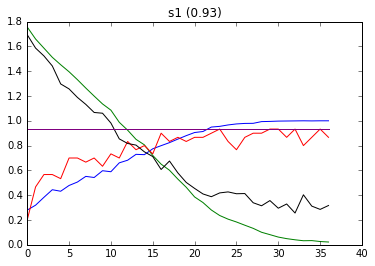

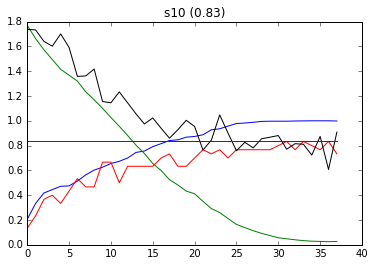

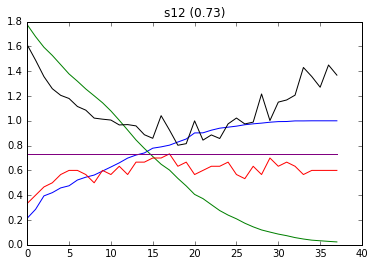

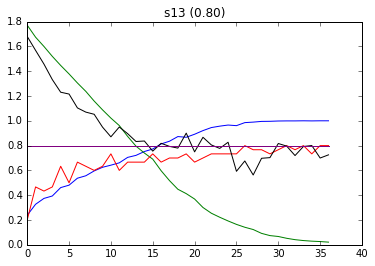

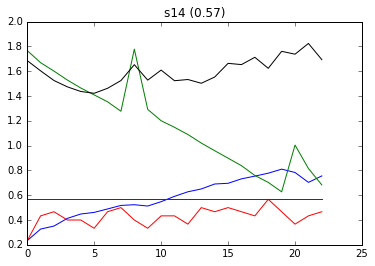

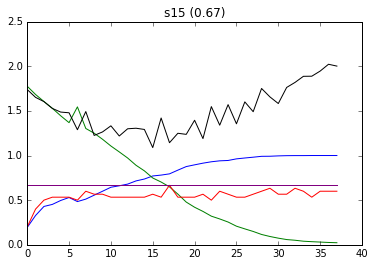

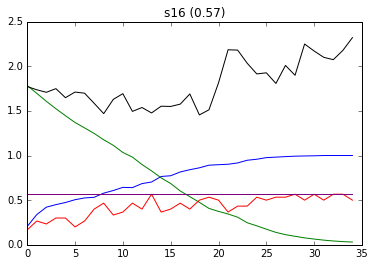

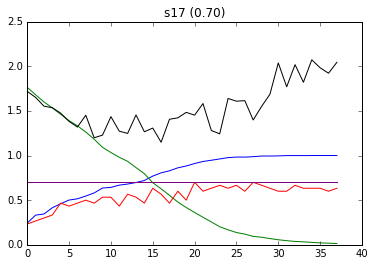

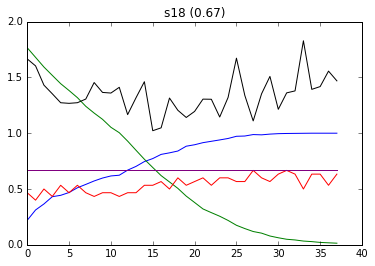

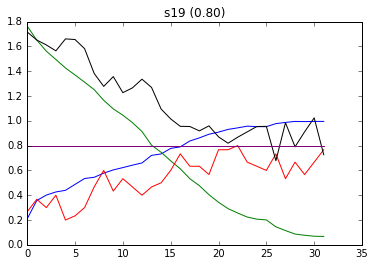

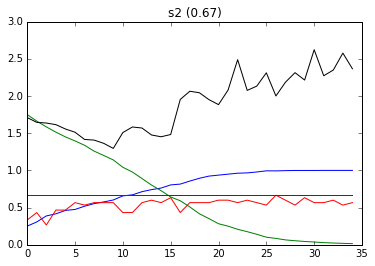

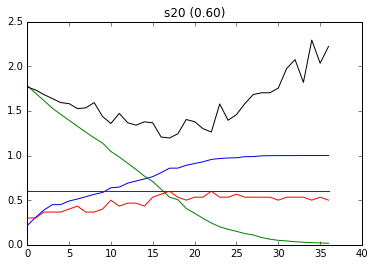

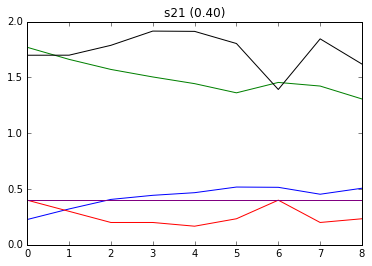

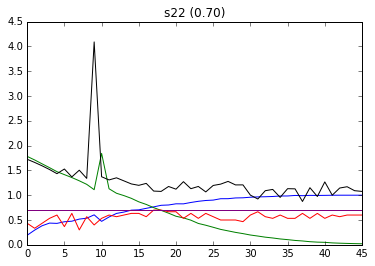

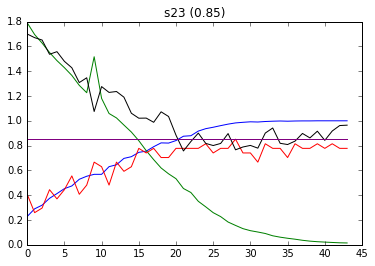

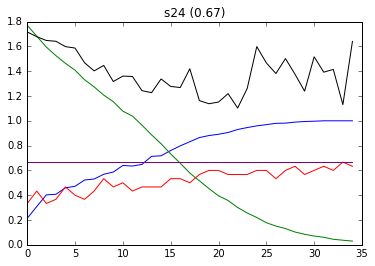

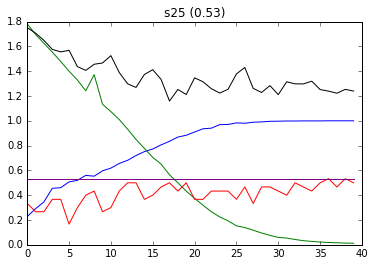

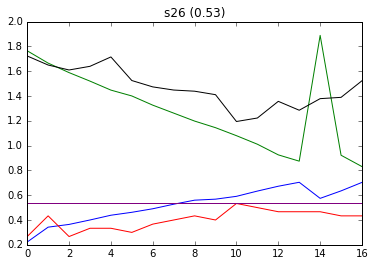

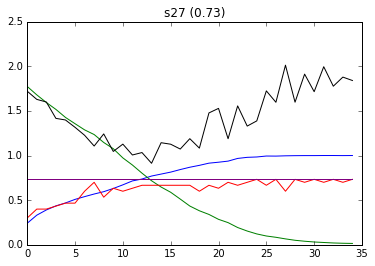

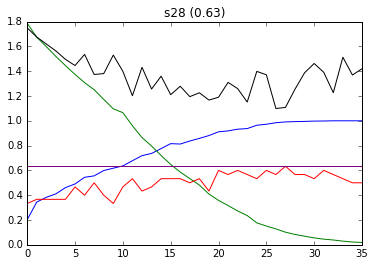

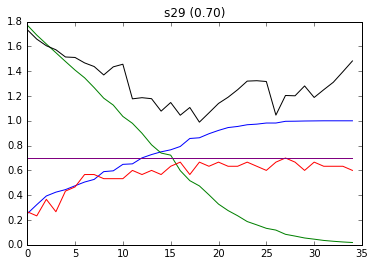

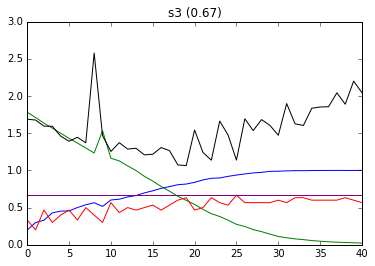

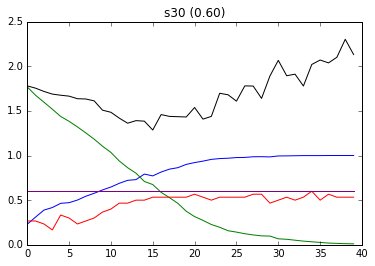

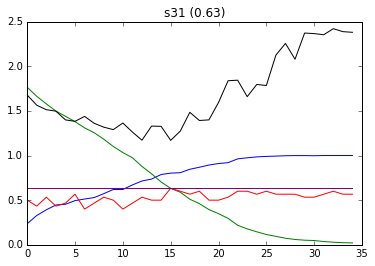

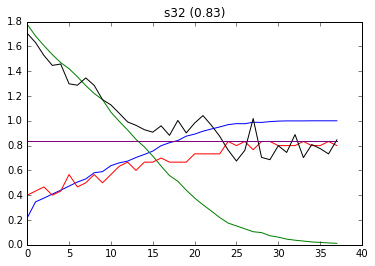

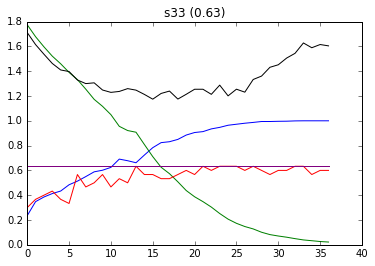

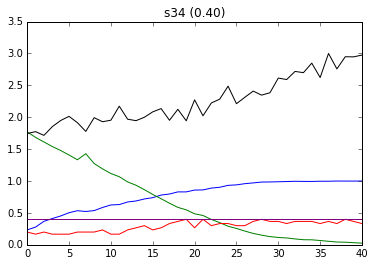

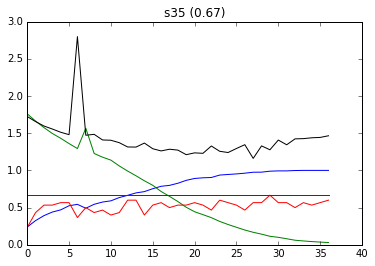

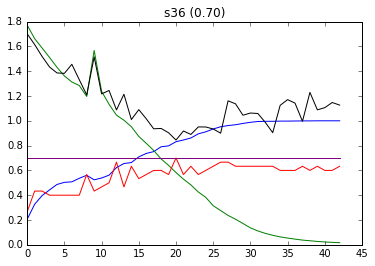

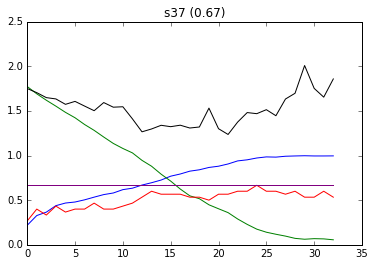

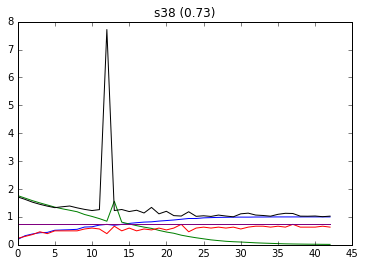

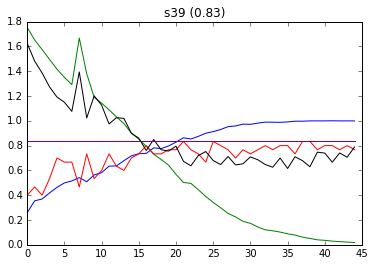

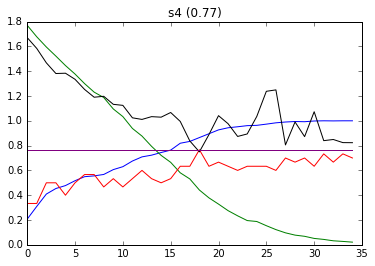

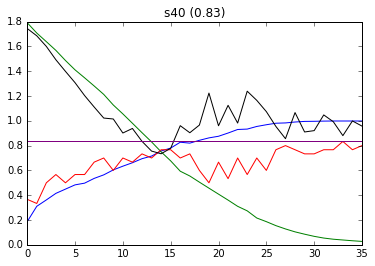

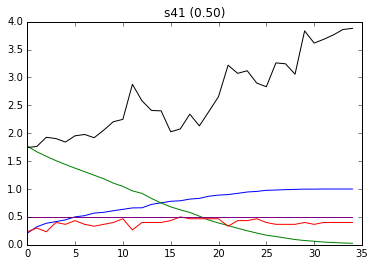

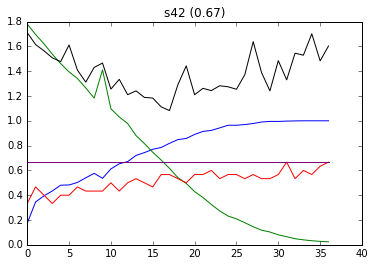

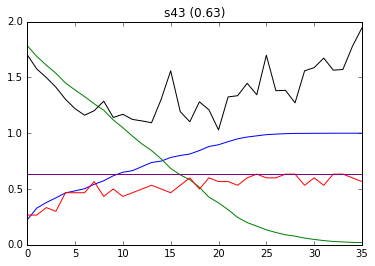

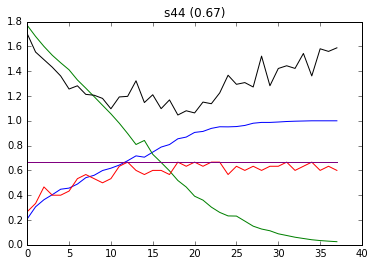

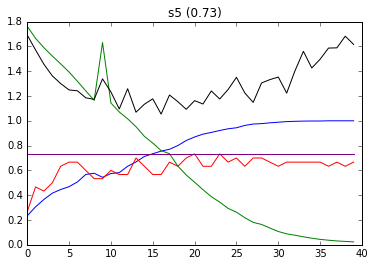

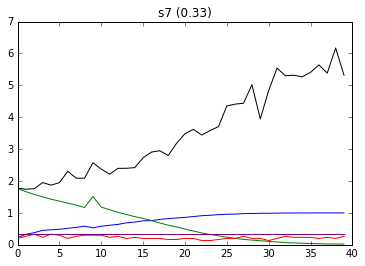

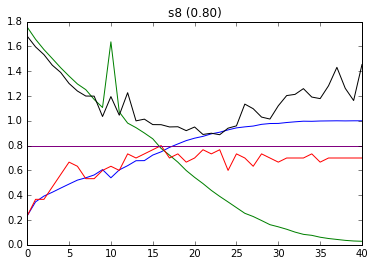

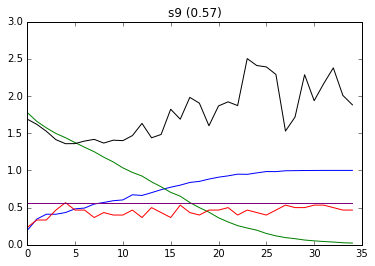

In [5]:
from matplotlib import pyplot as plt
plt.ioff()

for index_ in range(len(results)):
    setup = setups[index_]
    result = results[index_]
    setup.append(result[0][-1])
    setup.append(result[1][-1])
    setup.append(result[2][-1])
    setup.append(result[3][-1])
    setup.append(max(result[2]))
    #print (setup)
    # plot the training accuracies
    
    fig = plt.figure()
    plt.plot(result[0], 'b')
    plt.plot(result[1], 'g')
    plt.plot(result[2], 'r')
    plt.plot(result[3], 'k')
    plt.title(subject_names[setup[6]] + ' (' + ('%.2f' % max(result[2])) + ')')
    plt.plot((0, len(result[0])-1), (max(result[2]),max(result[2])), 'purple')
    plt.show()
    
    #plt.savefig('image_{}_{}_{}_{}_\'{}\'_{}_{}.png'.format(setup[0],setup[1],setup[2],setup[3],setup[4],setup[5],setup[6]))
    plt.close(fig)